## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


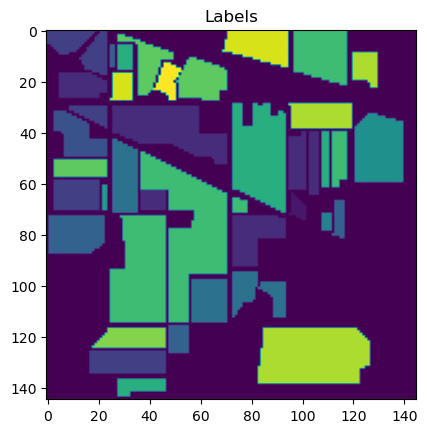

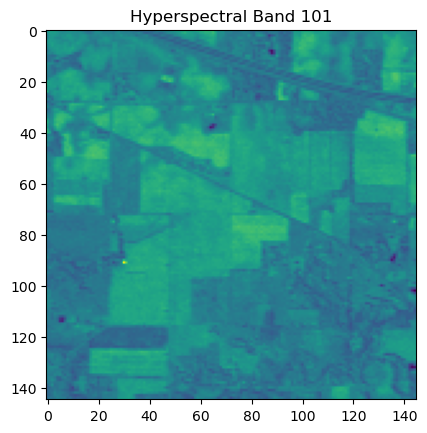

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class '7'
Se


All datasets saved to the 'indices' folder.
(80, 5, 5, 200)
(80, 5, 5, 200)
(10089, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 80
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0778, PSNR: 11.0887


Epoch [1/50] Training Loss: 0.0650, PSNR: 11.4401
	[Val]   Batch [1/33] Loss: 0.0492, PSNR: 12.7436
	[Val]   Batch [10/33] Loss: 0.0486, PSNR: 12.4007
	[Val]   Batch [20/33] Loss: 0.0483, PSNR: 11.9902
	[Val]   Batch [30/33] Loss: 0.0466, PSNR: 12.3925
Epoch [1/50] Validation Loss: 0.0489, PSNR: 12.5678

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0492, PSNR: 12.8564


Epoch [2/50] Training Loss: 0.0395, PSNR: 13.6241
	[Val]   Batch [1/33] Loss: 0.0290, PSNR: 15.0439
	[Val]   Batch [10/33] Loss: 0.0285, PSNR: 14.7145
	[Val]   Batch [20/33] Loss: 0.0282, PSNR: 14.3220
	[Val]   Batch [30/33] Loss: 0.0275, PSNR: 14.6793
Epoch [2/50] Validation Loss: 0.0289, PSNR: 14.8459

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0286, PSNR: 14.8964


Epoch [3/50] Training Loss: 0.0230, PSNR: 15.9623
	[Val]   Batch [1/33] Loss: 0.0173, PSNR: 17.2849
	[Val]   Batch [10/33] Loss: 0.0169, PSNR: 16.9988
	[Val]   Batch [20/33] Loss: 0.0166, PSNR: 16.6347
	[Val]   Batch [30/33] Loss: 0.0161, PSNR: 17.0041
Epoch [3/50] Validation Loss: 0.0173, PSNR: 17.0901

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0165, PSNR: 17.6114


Epoch [4/50] Training Loss: 0.0139, PSNR: 18.1274
	[Val]   Batch [1/33] Loss: 0.0112, PSNR: 19.1618
	[Val]   Batch [10/33] Loss: 0.0108, PSNR: 18.9425
	[Val]   Batch [20/33] Loss: 0.0105, PSNR: 18.6187
	[Val]   Batch [30/33] Loss: 0.0101, PSNR: 19.0108
Epoch [4/50] Validation Loss: 0.0112, PSNR: 18.9790

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0122, PSNR: 18.5223


Epoch [5/50] Training Loss: 0.0093, PSNR: 19.8900
	[Val]   Batch [1/33] Loss: 0.0081, PSNR: 20.5788
	[Val]   Batch [10/33] Loss: 0.0077, PSNR: 20.4267
	[Val]   Batch [20/33] Loss: 0.0074, PSNR: 20.1457
	[Val]   Batch [30/33] Loss: 0.0071, PSNR: 20.5395
Epoch [5/50] Validation Loss: 0.0081, PSNR: 20.4002

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0072, PSNR: 20.9500


Epoch [6/50] Training Loss: 0.0068, PSNR: 21.2334
	[Val]   Batch [1/33] Loss: 0.0062, PSNR: 21.7714
	[Val]   Batch [10/33] Loss: 0.0057, PSNR: 21.6959
	[Val]   Batch [20/33] Loss: 0.0055, PSNR: 21.4623
	[Val]   Batch [30/33] Loss: 0.0053, PSNR: 21.8729
Epoch [6/50] Validation Loss: 0.0061, PSNR: 21.6036

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0067, PSNR: 21.7365


Epoch [7/50] Training Loss: 0.0054, PSNR: 22.2674
	[Val]   Batch [1/33] Loss: 0.0050, PSNR: 22.6473
	[Val]   Batch [10/33] Loss: 0.0046, PSNR: 22.6583
	[Val]   Batch [20/33] Loss: 0.0043, PSNR: 22.4525
	[Val]   Batch [30/33] Loss: 0.0042, PSNR: 22.8574
Epoch [7/50] Validation Loss: 0.0050, PSNR: 22.5010

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0051, PSNR: 22.1527


Epoch [8/50] Training Loss: 0.0044, PSNR: 23.1130
	[Val]   Batch [1/33] Loss: 0.0041, PSNR: 23.5805
	[Val]   Batch [10/33] Loss: 0.0036, PSNR: 23.7095
	[Val]   Batch [20/33] Loss: 0.0034, PSNR: 23.5527
	[Val]   Batch [30/33] Loss: 0.0032, PSNR: 23.9925
Epoch [8/50] Validation Loss: 0.0040, PSNR: 23.4787

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0041, PSNR: 23.1673


Epoch [9/50] Training Loss: 0.0037, PSNR: 23.8804
	[Val]   Batch [1/33] Loss: 0.0035, PSNR: 24.2069
	[Val]   Batch [10/33] Loss: 0.0031, PSNR: 24.4220
	[Val]   Batch [20/33] Loss: 0.0028, PSNR: 24.2859
	[Val]   Batch [30/33] Loss: 0.0027, PSNR: 24.7493
Epoch [9/50] Validation Loss: 0.0034, PSNR: 24.1410

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0039, PSNR: 23.7980


Epoch [10/50] Training Loss: 0.0032, PSNR: 24.4983
	[Val]   Batch [1/33] Loss: 0.0031, PSNR: 24.8104
	[Val]   Batch [10/33] Loss: 0.0026, PSNR: 25.1334
	[Val]   Batch [20/33] Loss: 0.0024, PSNR: 25.0427
	[Val]   Batch [30/33] Loss: 0.0022, PSNR: 25.5622
Epoch [10/50] Validation Loss: 0.0030, PSNR: 24.8095

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0035, PSNR: 24.3092


Epoch [11/50] Training Loss: 0.0028, PSNR: 25.0841
	[Val]   Batch [1/33] Loss: 0.0027, PSNR: 25.3481
	[Val]   Batch [10/33] Loss: 0.0022, PSNR: 25.7586
	[Val]   Batch [20/33] Loss: 0.0021, PSNR: 25.7042
	[Val]   Batch [30/33] Loss: 0.0019, PSNR: 26.2193
Epoch [11/50] Validation Loss: 0.0026, PSNR: 25.3890

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0021, PSNR: 26.1802


Epoch [12/50] Training Loss: 0.0026, PSNR: 25.4979
	[Val]   Batch [1/33] Loss: 0.0026, PSNR: 25.5672
	[Val]   Batch [10/33] Loss: 0.0021, PSNR: 25.9990
	[Val]   Batch [20/33] Loss: 0.0019, PSNR: 25.9584
	[Val]   Batch [30/33] Loss: 0.0018, PSNR: 26.4837
Epoch [12/50] Validation Loss: 0.0025, PSNR: 25.6322

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0019, PSNR: 26.5468


Epoch [13/50] Training Loss: 0.0023, PSNR: 25.9677
	[Val]   Batch [1/33] Loss: 0.0022, PSNR: 26.1699
	[Val]   Batch [10/33] Loss: 0.0018, PSNR: 26.6572
	[Val]   Batch [20/33] Loss: 0.0017, PSNR: 26.6480
	[Val]   Batch [30/33] Loss: 0.0015, PSNR: 27.2283
Epoch [13/50] Validation Loss: 0.0021, PSNR: 26.2609

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0019, PSNR: 26.7282


Epoch [14/50] Training Loss: 0.0021, PSNR: 26.3008
	[Val]   Batch [1/33] Loss: 0.0020, PSNR: 26.5584
	[Val]   Batch [10/33] Loss: 0.0017, PSNR: 27.0299
	[Val]   Batch [20/33] Loss: 0.0015, PSNR: 27.0350
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.6446
Epoch [14/50] Validation Loss: 0.0020, PSNR: 26.6398

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0023, PSNR: 26.1326


Epoch [15/50] Training Loss: 0.0020, PSNR: 26.6334
	[Val]   Batch [1/33] Loss: 0.0018, PSNR: 27.0171
	[Val]   Batch [10/33] Loss: 0.0015, PSNR: 27.4663
	[Val]   Batch [20/33] Loss: 0.0014, PSNR: 27.4842
	[Val]   Batch [30/33] Loss: 0.0013, PSNR: 28.0673
Epoch [15/50] Validation Loss: 0.0018, PSNR: 27.0856

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.2174


Epoch [16/50] Training Loss: 0.0018, PSNR: 26.9678
	[Val]   Batch [1/33] Loss: 0.0017, PSNR: 27.4284
	[Val]   Batch [10/33] Loss: 0.0014, PSNR: 27.8359
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.8538
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.4743
Epoch [16/50] Validation Loss: 0.0016, PSNR: 27.4718

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.6485


Epoch [17/50] Training Loss: 0.0017, PSNR: 27.3204
	[Val]   Batch [1/33] Loss: 0.0015, PSNR: 27.8830
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.2173
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.2466
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 28.8788
Epoch [17/50] Validation Loss: 0.0015, PSNR: 27.8917

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 28.3121


Epoch [18/50] Training Loss: 0.0016, PSNR: 27.6208
	[Val]   Batch [1/33] Loss: 0.0013, PSNR: 28.3966
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.6877
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.7076
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.3653
Epoch [18/50] Validation Loss: 0.0013, PSNR: 28.3730

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.9733


Epoch [19/50] Training Loss: 0.0015, PSNR: 27.9558
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 28.7414
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 29.0403
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.0979
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 29.7845
Epoch [19/50] Validation Loss: 0.0012, PSNR: 28.7359

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.7679


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.2050
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 28.9860
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.2117
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.2972
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 29.9894
Epoch [20/50] Validation Loss: 0.0011, PSNR: 28.9598

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 29.3737


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.4637
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.2018
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.4315
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.5291
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.1952
Epoch [21/50] Validation Loss: 0.0011, PSNR: 29.1745

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.8824


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.6864
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.6146
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.8130
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.9563
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.6334
Epoch [22/50] Validation Loss: 0.0010, PSNR: 29.5886

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.3703


Epoch [23/50] Training Loss: 0.0012, PSNR: 28.9309
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.7948
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.9585
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.1380
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.8628
Epoch [23/50] Validation Loss: 0.0009, PSNR: 29.7718

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.7717


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.0951
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.0371
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.1942
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.3750
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.1067
Epoch [24/50] Validation Loss: 0.0009, PSNR: 30.0384

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 29.1350


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.2579
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.0664
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.1990
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.3880
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.1387
Epoch [25/50] Validation Loss: 0.0009, PSNR: 30.0745

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.6170


Epoch [26/50] Training Loss: 0.0010, PSNR: 29.3879
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.3880
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.5342
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.7768
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.5255
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.3988

LOG: Epoch [27/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.9768


Epoch [27/50] Training Loss: 0.0010, PSNR: 29.5509
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.5615
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.7066
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.9890
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.7759
Epoch [27/50] Validation Loss: 0.0008, PSNR: 30.6021

LOG: Epoch [28/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.4513


Epoch [28/50] Training Loss: 0.0010, PSNR: 29.6713
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.6777
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.8153
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.0929
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.8590
Epoch [28/50] Validation Loss: 0.0008, PSNR: 30.7155

LOG: Epoch [29/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 30.1850


Epoch [29/50] Training Loss: 0.0010, PSNR: 29.8032
	[Val]   Batch [1/33] Loss: 0.0007, PSNR: 30.9164
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 31.0349
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.3440
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 32.1421
Epoch [29/50] Validation Loss: 0.0007, PSNR: 30.9593
Early stopping triggered at epoch 29. No improvement for 3 epochs.


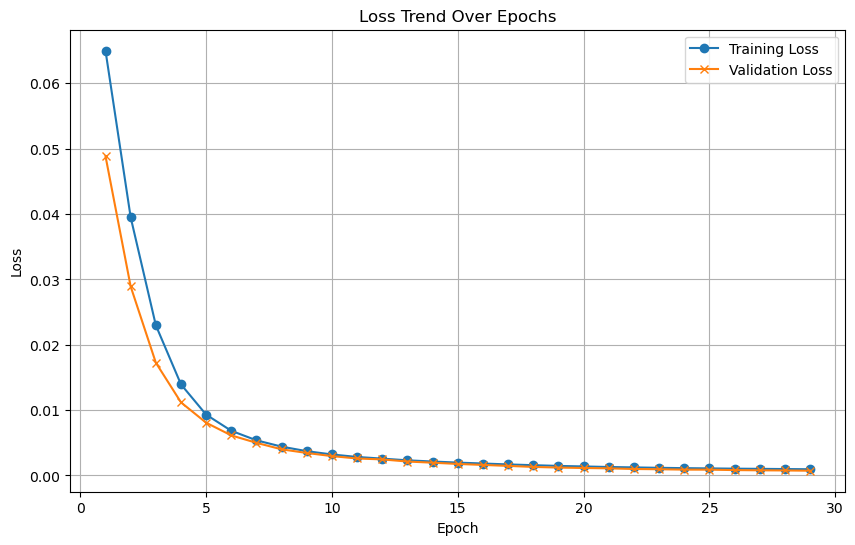

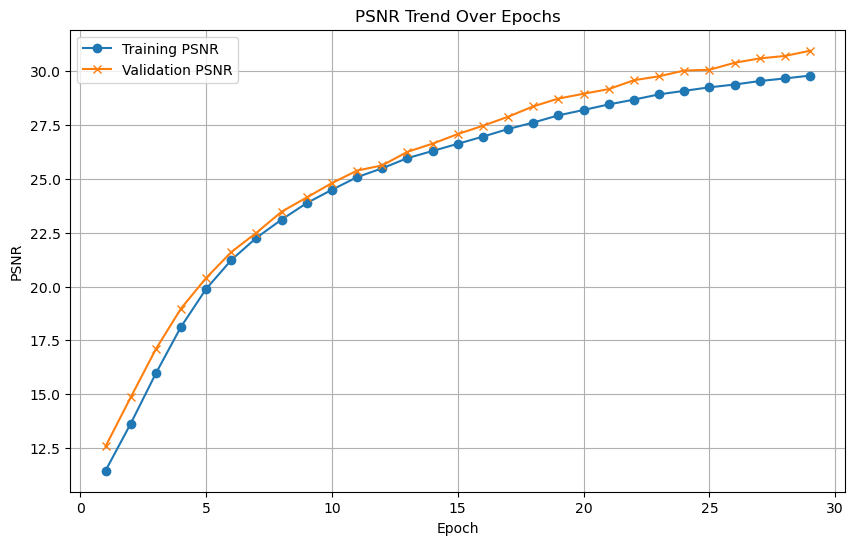

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/40 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7783
    Validation Batch [1/1], Loss: 2.7794
Validation Loss: 2.7794, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7794. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7453
    Validation Batch [1/1], Loss: 2.7794
Validation Loss: 2.7794, Validation Accuracy: 6.25%
Validation loss improved from 2.7794 to 2.7794. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7357
    Validation Batch [1/1], Loss: 2.7794
Validation Loss: 2.7794, Validation Accuracy: 6.25%
Validation loss improved from 2.7794 to 2.7794. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7224
    Validation Batch [1/1], Loss: 2.7793
Validation Loss: 2.7793, Validation Accuracy: 6.25%
Validation loss improved from 2.7794 to 2.7793. Saving model...

LOG: Epoch [5/1000] - 

Epoch [8/1000] completed, Average Training Loss: 2.6732
    Validation Batch [1/1], Loss: 2.7792
Validation Loss: 2.7792, Validation Accuracy: 6.25%
Validation loss improved from 2.7793 to 2.7792. Saving model...

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.6621
    Validation Batch [1/1], Loss: 2.7791
Validation Loss: 2.7791, Validation Accuracy: 6.25%
Validation loss improved from 2.7792 to 2.7791. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.6574
    Validation Batch [1/1], Loss: 2.7790
Validation Loss: 2.7790, Validation Accuracy: 6.25%
Validation loss improved from 2.7791 to 2.7790. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.6539
    Validation Batch [1/1], Loss: 2.7789
Validation Loss: 2.7789, Validation Accuracy: 6.25%
Validation loss improved from 2.7790 to 2.7789. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000]

Epoch [22/1000] completed, Average Training Loss: 2.5561
    Validation Batch [1/1], Loss: 2.7759
Validation Loss: 2.7759, Validation Accuracy: 6.25%
Validation loss improved from 2.7764 to 2.7759. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.5087
    Validation Batch [1/1], Loss: 2.7753
Validation Loss: 2.7753, Validation Accuracy: 6.25%
Validation loss improved from 2.7759 to 2.7753. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.5313
    Validation Batch [1/1], Loss: 2.7748
Validation Loss: 2.7748, Validation Accuracy: 6.25%
Validation loss improved from 2.7753 to 2.7748. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.5298
    Validation Batch [1/1], Loss: 2.7742
Validation Loss: 2.7742, Validation Accuracy: 8.75%
Validation loss improved from 2.7748 to 2.7742. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/10

Epoch [36/1000] completed, Average Training Loss: 2.4244
    Validation Batch [1/1], Loss: 2.7600
Validation Loss: 2.7600, Validation Accuracy: 11.25%
Validation loss improved from 2.7624 to 2.7600. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 2.4174
    Validation Batch [1/1], Loss: 2.7579
Validation Loss: 2.7579, Validation Accuracy: 12.50%
Validation loss improved from 2.7600 to 2.7579. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 2.4292
    Validation Batch [1/1], Loss: 2.7560
Validation Loss: 2.7560, Validation Accuracy: 11.25%
Validation loss improved from 2.7579 to 2.7560. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 2.4253
    Validation Batch [1/1], Loss: 2.7537
Validation Loss: 2.7537, Validation Accuracy: 11.25%
Validation loss improved from 2.7560 to 2.7537. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [4

Epoch [51/1000] completed, Average Training Loss: 2.3094
    Validation Batch [1/1], Loss: 2.6888
Validation Loss: 2.6888, Validation Accuracy: 12.50%
Validation loss improved from 2.7011 to 2.6888. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 2.2934
    Validation Batch [1/1], Loss: 2.6750
Validation Loss: 2.6750, Validation Accuracy: 12.50%
Validation loss improved from 2.6888 to 2.6750. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 2.3171
    Validation Batch [1/1], Loss: 2.6590
Validation Loss: 2.6590, Validation Accuracy: 12.50%
Validation loss improved from 2.6750 to 2.6590. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.2770
    Validation Batch [1/1], Loss: 2.6466
Validation Loss: 2.6466, Validation Accuracy: 13.75%
Validation loss improved from 2.6590 to 2.6466. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [5

Epoch [65/1000] completed, Average Training Loss: 2.1771
    Validation Batch [1/1], Loss: 2.5234
Validation Loss: 2.5234, Validation Accuracy: 20.00%
Validation loss improved from 2.5550 to 2.5234. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 2.1654
    Validation Batch [1/1], Loss: 2.5047
Validation Loss: 2.5047, Validation Accuracy: 21.25%
Validation loss improved from 2.5234 to 2.5047. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 2.1611
    Validation Batch [1/1], Loss: 2.4951
Validation Loss: 2.4951, Validation Accuracy: 17.50%
Validation loss improved from 2.5047 to 2.4951. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 2.1616
    Validation Batch [1/1], Loss: 2.4816
Validation Loss: 2.4816, Validation Accuracy: 20.00%
Validation loss improved from 2.4951 to 2.4816. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [6

    Validation Batch [1/1], Loss: 2.4387
Validation Loss: 2.4387, Validation Accuracy: 31.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.9849
    Validation Batch [1/1], Loss: 2.4470
Validation Loss: 2.4470, Validation Accuracy: 31.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 2.0217
    Validation Batch [1/1], Loss: 2.4392
Validation Loss: 2.4392, Validation Accuracy: 27.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 2.0322
    Validation Batch [1/1], Loss: 2.4453
Validation Loss: 2.4453, Validation Accuracy: 21.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 2.0044
    Validation Batch [1/1], Loss: 2.4223
Validation Loss: 2.4223, Va

Epoch [95/1000] completed, Average Training Loss: 1.8976
    Validation Batch [1/1], Loss: 2.3715
Validation Loss: 2.3715, Validation Accuracy: 36.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.8830
    Validation Batch [1/1], Loss: 2.3210
Validation Loss: 2.3210, Validation Accuracy: 42.50%
Validation loss improved from 2.3542 to 2.3210. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.8989
    Validation Batch [1/1], Loss: 2.3027
Validation Loss: 2.3027, Validation Accuracy: 37.50%
Validation loss improved from 2.3210 to 2.3027. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.9270
    Validation Batch [1/1], Loss: 2.3060
Validation Loss: 2.3060, Validation Accuracy: 41.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Tra

Epoch [111/1000] completed, Average Training Loss: 1.7631
    Validation Batch [1/1], Loss: 2.2742
Validation Loss: 2.2742, Validation Accuracy: 45.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.7709
    Validation Batch [1/1], Loss: 2.2572
Validation Loss: 2.2572, Validation Accuracy: 45.00%
Validation loss improved from 2.2700 to 2.2572. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.7624
    Validation Batch [1/1], Loss: 2.2418
Validation Loss: 2.2418, Validation Accuracy: 47.50%
Validation loss improved from 2.2572 to 2.2418. Saving model...

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training Loss: 1.7475
    Validation Batch [1/1], Loss: 2.2469
Validation Loss: 2.2469, Validation Accuracy: 47.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Av

Epoch [124/1000] completed, Average Training Loss: 1.6365
    Validation Batch [1/1], Loss: 2.2625
Validation Loss: 2.2625, Validation Accuracy: 42.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 1.6241
    Validation Batch [1/1], Loss: 2.2857
Validation Loss: 2.2857, Validation Accuracy: 33.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 1.6427
    Validation Batch [1/1], Loss: 2.2987
Validation Loss: 2.2987, Validation Accuracy: 33.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 1.6367
    Validation Batch [1/1], Loss: 2.2901
Validation Loss: 2.2901, Validation Accuracy: 36.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 1.6181
  

    Validation Batch [1/1], Loss: 2.2283
Validation Loss: 2.2283, Validation Accuracy: 50.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.5321
    Validation Batch [1/1], Loss: 2.1919
Validation Loss: 2.1919, Validation Accuracy: 47.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.5434
    Validation Batch [1/1], Loss: 2.1540
Validation Loss: 2.1540, Validation Accuracy: 43.75%
Validation loss improved from 2.1650 to 2.1540. Saving model...

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 1.4860
    Validation Batch [1/1], Loss: 2.1107
Validation Loss: 2.1107, Validation Accuracy: 50.00%
Validation loss improved from 2.1540 to 2.1107. Saving model...

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Average Training Loss: 1.4719
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 2.0990
Validation Loss: 2.0990, Validation Accuracy: 56.25%
Validation loss improved from 2.1084 to 2.0990. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 1.4548
    Validation Batch [1/1], Loss: 2.0736
Validation Loss: 2.0736, Validation Accuracy: 56.25%
Validation loss improved from 2.0990 to 2.0736. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 1.4273
    Validation Batch [1/1], Loss: 2.0761
Validation Loss: 2.0761, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 1.3839
    Validation Batch [1/1], Loss: 2.1090
Validation Loss: 2.1090, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.4340
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 2.0758
Validation Loss: 2.0758, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 1.2948
    Validation Batch [1/1], Loss: 2.0727
Validation Loss: 2.0727, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 1.2611
    Validation Batch [1/1], Loss: 2.0425
Validation Loss: 2.0425, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 1.2178
    Validation Batch [1/1], Loss: 2.0374
Validation Loss: 2.0374, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 1.2875
    Validation Batch [1/1], Loss: 2.0235
Validation Loss: 2.

Epoch [179/1000] completed, Average Training Loss: 1.2074
    Validation Batch [1/1], Loss: 2.0285
Validation Loss: 2.0285, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 1.2180
    Validation Batch [1/1], Loss: 2.0027
Validation Loss: 2.0027, Validation Accuracy: 55.00%
Validation loss improved from 2.0063 to 2.0027. Saving model...

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.1578
    Validation Batch [1/1], Loss: 1.9840
Validation Loss: 1.9840, Validation Accuracy: 60.00%
Validation loss improved from 2.0027 to 1.9840. Saving model...

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 1.1422
    Validation Batch [1/1], Loss: 2.0197
Validation Loss: 2.0197, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Av

    Validation Batch [1/1], Loss: 1.8725
Validation Loss: 1.8725, Validation Accuracy: 57.50%
Validation loss improved from 1.8962 to 1.8725. Saving model...

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 1.0307
    Validation Batch [1/1], Loss: 1.8602
Validation Loss: 1.8602, Validation Accuracy: 58.75%
Validation loss improved from 1.8725 to 1.8602. Saving model...

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 1.0527
    Validation Batch [1/1], Loss: 1.8949
Validation Loss: 1.8949, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 1.0366
    Validation Batch [1/1], Loss: 1.9148
Validation Loss: 1.9148, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 1.0576
    Validation Batch [1/1], Lo

Epoch [208/1000] completed, Average Training Loss: 1.0101
    Validation Batch [1/1], Loss: 1.9373
Validation Loss: 1.9373, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 1.0147
    Validation Batch [1/1], Loss: 1.8838
Validation Loss: 1.8838, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 1.0128
    Validation Batch [1/1], Loss: 1.8762
Validation Loss: 1.8762, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.9130
    Validation Batch [1/1], Loss: 1.8421
Validation Loss: 1.8421, Validation Accuracy: 60.00%
Validation loss improved from 1.8577 to 1.8421. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training 

Epoch [230/1000] completed, Average Training Loss: 0.8804
    Validation Batch [1/1], Loss: 1.8666
Validation Loss: 1.8666, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.8331
    Validation Batch [1/1], Loss: 1.8311
Validation Loss: 1.8311, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.8075
    Validation Batch [1/1], Loss: 1.8143
Validation Loss: 1.8143, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.7972
    Validation Batch [1/1], Loss: 1.8031
Validation Loss: 1.8031, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.8116
  

Epoch [238/1000] completed, Average Training Loss: 0.8015
    Validation Batch [1/1], Loss: 1.7399
Validation Loss: 1.7399, Validation Accuracy: 60.00%
Validation loss improved from 1.7558 to 1.7399. Saving model...

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.7962
    Validation Batch [1/1], Loss: 1.7519
Validation Loss: 1.7519, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.8202
    Validation Batch [1/1], Loss: 1.7206
Validation Loss: 1.7206, Validation Accuracy: 61.25%
Validation loss improved from 1.7399 to 1.7206. Saving model...

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.7538
    Validation Batch [1/1], Loss: 1.7407
Validation Loss: 1.7407, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Av

Epoch [259/1000] completed, Average Training Loss: 0.6826
    Validation Batch [1/1], Loss: 1.6617
Validation Loss: 1.6617, Validation Accuracy: 62.50%
Validation loss improved from 1.6700 to 1.6617. Saving model...

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.6912
    Validation Batch [1/1], Loss: 1.7071
Validation Loss: 1.7071, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.6306
    Validation Batch [1/1], Loss: 1.7161
Validation Loss: 1.7161, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.6602
    Validation Batch [1/1], Loss: 1.6716
Validation Loss: 1.6716, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training 

Epoch [268/1000] completed, Average Training Loss: 0.6450
    Validation Batch [1/1], Loss: 1.6878
Validation Loss: 1.6878, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.5923
    Validation Batch [1/1], Loss: 1.6553
Validation Loss: 1.6553, Validation Accuracy: 61.25%
Validation loss improved from 1.6617 to 1.6553. Saving model...

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.6200
    Validation Batch [1/1], Loss: 1.6358
Validation Loss: 1.6358, Validation Accuracy: 66.25%
Validation loss improved from 1.6553 to 1.6358. Saving model...

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.6140
    Validation Batch [1/1], Loss: 1.6476
Validation Loss: 1.6476, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Av

    Validation Batch [1/1], Loss: 1.5858
Validation Loss: 1.5858, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.5172
    Validation Batch [1/1], Loss: 1.5754
Validation Loss: 1.5754, Validation Accuracy: 67.50%
Validation loss improved from 1.5832 to 1.5754. Saving model...

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.5015
    Validation Batch [1/1], Loss: 1.5871
Validation Loss: 1.5871, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.5157
    Validation Batch [1/1], Loss: 1.5989
Validation Loss: 1.5989, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.5394
    Validation Batch [1/1], Loss: 1.5876
Vali

    Validation Batch [1/1], Loss: 1.5951
Validation Loss: 1.5951, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.5011
    Validation Batch [1/1], Loss: 1.5928
Validation Loss: 1.5928, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.4976
    Validation Batch [1/1], Loss: 1.5730
Validation Loss: 1.5730, Validation Accuracy: 65.00%
Validation loss improved from 1.5732 to 1.5730. Saving model...

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.4852
    Validation Batch [1/1], Loss: 1.5992
Validation Loss: 1.5992, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.5140
    Validation Batch [1/1], Loss: 1.6187
Vali

    Validation Batch [1/1], Loss: 1.5536
Validation Loss: 1.5536, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.4006
    Validation Batch [1/1], Loss: 1.5902
Validation Loss: 1.5902, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.4418
    Validation Batch [1/1], Loss: 1.5497
Validation Loss: 1.5497, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.4494
    Validation Batch [1/1], Loss: 1.5630
Validation Loss: 1.5630, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.3625
    Validation Batch [1/1], Loss: 1.5774
Validation Loss:

Epoch [329/1000] completed, Average Training Loss: 0.3976
    Validation Batch [1/1], Loss: 1.5124
Validation Loss: 1.5124, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.3696
    Validation Batch [1/1], Loss: 1.4965
Validation Loss: 1.4965, Validation Accuracy: 66.25%
Validation loss improved from 1.4985 to 1.4965. Saving model...

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.3554
    Validation Batch [1/1], Loss: 1.5033
Validation Loss: 1.5033, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.3938
    Validation Batch [1/1], Loss: 1.5090
Validation Loss: 1.5090, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training 

Epoch [346/1000] completed, Average Training Loss: 0.3119
    Validation Batch [1/1], Loss: 1.4976
Validation Loss: 1.4976, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.3559
    Validation Batch [1/1], Loss: 1.4954
Validation Loss: 1.4954, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.3399
    Validation Batch [1/1], Loss: 1.5040
Validation Loss: 1.5040, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.3600
    Validation Batch [1/1], Loss: 1.5373
Validation Loss: 1.5373, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.2962
  

Epoch [356/1000] completed, Average Training Loss: 0.3415
    Validation Batch [1/1], Loss: 1.5621
Validation Loss: 1.5621, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.2817
    Validation Batch [1/1], Loss: 1.4920
Validation Loss: 1.4920, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.3347
    Validation Batch [1/1], Loss: 1.4755
Validation Loss: 1.4755, Validation Accuracy: 63.75%
Validation loss improved from 1.4803 to 1.4755. Saving model...

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.3076
    Validation Batch [1/1], Loss: 1.5218
Validation Loss: 1.5218, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Trainin

Epoch [376/1000] completed, Average Training Loss: 0.2515
    Validation Batch [1/1], Loss: 1.5656
Validation Loss: 1.5656, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.2666
    Validation Batch [1/1], Loss: 1.5284
Validation Loss: 1.5284, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.2841
    Validation Batch [1/1], Loss: 1.4876
Validation Loss: 1.4876, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.2488
    Validation Batch [1/1], Loss: 1.4278
Validation Loss: 1.4278, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.212

    Validation Batch [1/1], Loss: 1.4155
Validation Loss: 1.4155, Validation Accuracy: 58.75%
Validation loss improved from 1.4222 to 1.4155. Saving model...

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.2378
    Validation Batch [1/1], Loss: 1.4096
Validation Loss: 1.4096, Validation Accuracy: 62.50%
Validation loss improved from 1.4155 to 1.4096. Saving model...

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.2311
    Validation Batch [1/1], Loss: 1.4236
Validation Loss: 1.4236, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.2140
    Validation Batch [1/1], Loss: 1.4289
Validation Loss: 1.4289, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.2216
    Validation Batch [1/1], Lo

Epoch [404/1000] completed, Average Training Loss: 0.2114
    Validation Batch [1/1], Loss: 1.4890
Validation Loss: 1.4890, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.2152
    Validation Batch [1/1], Loss: 1.4579
Validation Loss: 1.4579, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.2376
    Validation Batch [1/1], Loss: 1.4742
Validation Loss: 1.4742, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0.2339
    Validation Batch [1/1], Loss: 1.4575
Validation Loss: 1.4575, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [408/1000] - Training
Epoch [408/1000] completed, Average Training Loss: 0.213

Epoch [414/1000] completed, Average Training Loss: 0.2176
    Validation Batch [1/1], Loss: 1.4667
Validation Loss: 1.4667, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.2266
    Validation Batch [1/1], Loss: 1.4294
Validation Loss: 1.4294, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.2290
    Validation Batch [1/1], Loss: 1.3983
Validation Loss: 1.3983, Validation Accuracy: 62.50%
Validation loss improved from 1.4096 to 1.3983. Saving model...

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Average Training Loss: 0.1924
    Validation Batch [1/1], Loss: 1.3702
Validation Loss: 1.3702, Validation Accuracy: 66.25%
Validation loss improved from 1.3983 to 1.3702. Saving model...

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, 

Epoch [430/1000] completed, Average Training Loss: 0.1725
    Validation Batch [1/1], Loss: 1.3966
Validation Loss: 1.3966, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.1914
    Validation Batch [1/1], Loss: 1.3927
Validation Loss: 1.3927, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.1996
    Validation Batch [1/1], Loss: 1.3808
Validation Loss: 1.3808, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.2310
    Validation Batch [1/1], Loss: 1.4051
Validation Loss: 1.4051, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.161

Epoch [447/1000] completed, Average Training Loss: 0.1703
    Validation Batch [1/1], Loss: 1.5312
Validation Loss: 1.5312, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.1716
    Validation Batch [1/1], Loss: 1.5132
Validation Loss: 1.5132, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [449/1000] - Training
Epoch [449/1000] completed, Average Training Loss: 0.1792
    Validation Batch [1/1], Loss: 1.4634
Validation Loss: 1.4634, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training Loss: 0.1632
    Validation Batch [1/1], Loss: 1.4331
Validation Loss: 1.4331, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [451/1000] - Training
Epoch [451/1000] completed, Average Training Loss: 0.158

    Validation Batch [1/1], Loss: 1.4746
Validation Loss: 1.4746, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training Loss: 0.1835
    Validation Batch [1/1], Loss: 1.3798
Validation Loss: 1.3798, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.1487
    Validation Batch [1/1], Loss: 1.3516
Validation Loss: 1.3516, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [464/1000] - Training
Epoch [464/1000] completed, Average Training Loss: 0.1436
    Validation Batch [1/1], Loss: 1.3589
Validation Loss: 1.3589, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.1328
    Validation Batch [1/1], Loss: 1.3986
Validation Loss

    Validation Batch [1/1], Loss: 1.3685
Validation Loss: 1.3685, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.1445
    Validation Batch [1/1], Loss: 1.3640
Validation Loss: 1.3640, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.1194
    Validation Batch [1/1], Loss: 1.3423
Validation Loss: 1.3423, Validation Accuracy: 67.50%
Validation loss improved from 1.3502 to 1.3423. Saving model...

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.1336
    Validation Batch [1/1], Loss: 1.3392
Validation Loss: 1.3392, Validation Accuracy: 67.50%
Validation loss improved from 1.3423 to 1.3392. Saving model...

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.1422
    Validation Batch [1/1], 

Epoch [490/1000] completed, Average Training Loss: 0.1220
    Validation Batch [1/1], Loss: 1.3346
Validation Loss: 1.3346, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.1616
    Validation Batch [1/1], Loss: 1.3374
Validation Loss: 1.3374, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.1261
    Validation Batch [1/1], Loss: 1.3362
Validation Loss: 1.3362, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.1371
    Validation Batch [1/1], Loss: 1.3489
Validation Loss: 1.3489, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.1211
  

Epoch [504/1000] completed, Average Training Loss: 0.1039
    Validation Batch [1/1], Loss: 1.3577
Validation Loss: 1.3577, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [505/1000] - Training
Epoch [505/1000] completed, Average Training Loss: 0.1444
    Validation Batch [1/1], Loss: 1.3540
Validation Loss: 1.3540, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [506/1000] - Training
Epoch [506/1000] completed, Average Training Loss: 0.1572
    Validation Batch [1/1], Loss: 1.5087
Validation Loss: 1.5087, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [507/1000] - Training
Epoch [507/1000] completed, Average Training Loss: 0.1325
    Validation Batch [1/1], Loss: 1.5297
Validation Loss: 1.5297, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [508/1000] - Training
Epoch [508/1000] completed, Average Training Loss: 0.148

    Validation Batch [1/1], Loss: 1.4212
Validation Loss: 1.4212, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.1306
    Validation Batch [1/1], Loss: 1.4787
Validation Loss: 1.4787, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.1256
    Validation Batch [1/1], Loss: 1.5079
Validation Loss: 1.5079, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.1147
    Validation Batch [1/1], Loss: 1.4750
Validation Loss: 1.4750, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.0967
    Validation Batch [1/1], Loss: 1.4941
Validation Loss

    Validation Batch [1/1], Loss: 1.4610
Validation Loss: 1.4610, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.1200
    Validation Batch [1/1], Loss: 1.4789
Validation Loss: 1.4789, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [535/1000] - Training
Epoch [535/1000] completed, Average Training Loss: 0.0975
    Validation Batch [1/1], Loss: 1.4035
Validation Loss: 1.4035, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [536/1000] - Training
Epoch [536/1000] completed, Average Training Loss: 0.1077
    Validation Batch [1/1], Loss: 1.3541
Validation Loss: 1.3541, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [537/1000] - Training
Epoch [537/1000] completed, Average Training Loss: 0.1029
    Validation Batch [1/1], Loss: 1.3797
Validation Loss

    Validation Batch [1/1], Loss: 1.4222
Validation Loss: 1.4222, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [551/1000] - Training
Epoch [551/1000] completed, Average Training Loss: 0.1048
    Validation Batch [1/1], Loss: 1.4042
Validation Loss: 1.4042, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.0954
    Validation Batch [1/1], Loss: 1.3283
Validation Loss: 1.3283, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [553/1000] - Training
Epoch [553/1000] completed, Average Training Loss: 0.1075
    Validation Batch [1/1], Loss: 1.5334
Validation Loss: 1.5334, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [554/1000] - Training
Epoch [554/1000] completed, Average Training Loss: 0.1156
    Validation Batch [1/1], Loss: 1.4258
Validation Loss

Epoch [563/1000] completed, Average Training Loss: 0.0926
    Validation Batch [1/1], Loss: 1.3820
Validation Loss: 1.3820, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [564/1000] - Training
Epoch [564/1000] completed, Average Training Loss: 0.0870
    Validation Batch [1/1], Loss: 1.3726
Validation Loss: 1.3726, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [565/1000] - Training
Epoch [565/1000] completed, Average Training Loss: 0.0821
    Validation Batch [1/1], Loss: 1.3504
Validation Loss: 1.3504, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [566/1000] - Training
Epoch [566/1000] completed, Average Training Loss: 0.1064
    Validation Batch [1/1], Loss: 1.3405
Validation Loss: 1.3405, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [567/1000] - Training
Epoch [567/1000] completed, Average Training Loss: 0.121

Epoch [579/1000] completed, Average Training Loss: 0.1149
    Validation Batch [1/1], Loss: 1.3720
Validation Loss: 1.3720, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [580/1000] - Training
Epoch [580/1000] completed, Average Training Loss: 0.0826
    Validation Batch [1/1], Loss: 1.3718
Validation Loss: 1.3718, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.0901
    Validation Batch [1/1], Loss: 1.3788
Validation Loss: 1.3788, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0980
    Validation Batch [1/1], Loss: 1.4090
Validation Loss: 1.4090, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.099

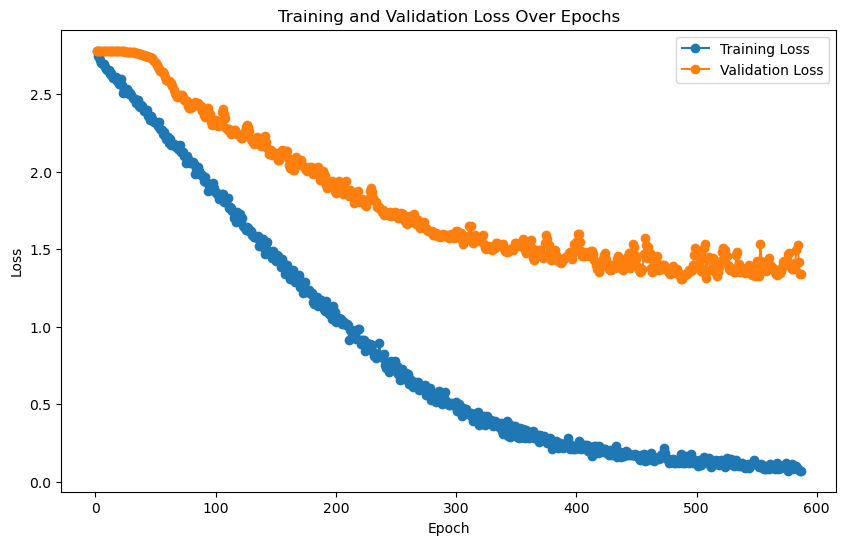

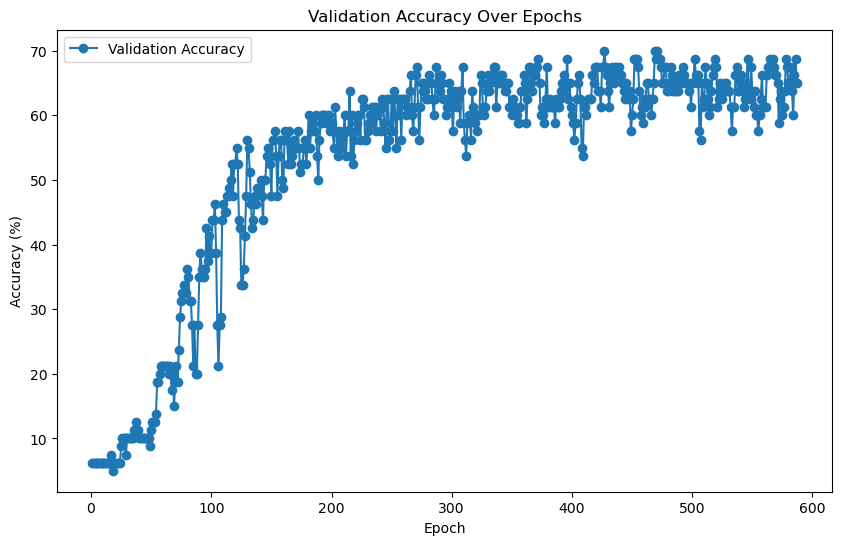


Evaluating on the test set...
    Test Batch [1/40], Loss: 3.9887

Final Test Loss: 1.7097, Test Accuracy: 53.16%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/40 for test dataset.
  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.


  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)

LOG: Training features shape: (80, 64), Training labels shape: (80,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (10089, 64), Test labels shape: (10089,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 52.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.50      0.40      0.44         5
           4       1.00      0.80      0.89         5
           5       0.50      1.00      0.67         5
           6       0.38      0.60      0.46         5
           7       0.33      0.20      0.25         5
           8       0.71      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)
Train reps shape: (80, 64)
Train labels shape: (80,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (10089, 64)
Test labels shape: (10089,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 3.0498  |  Val Loss: 3.0077
Validation loss improved from inf to 3.0077.
[Epoch 2/1000] Train Loss: 2.9129  |  Val Loss: 2.9141
Validation loss improved from 3.0077 to 2.9141.
[Epoch 3/1000] Train Loss: 2.8191  |  Val Loss: 2.8491
Validation loss improved from 2.9141 to 2.8491.
[Epoch 4/1000] Train Loss: 2.7691  |  Val Loss: 2.8040
Validation loss improved from 2.8491 to 2.8040.
[Epoch 5/1000] Train Loss: 2.7319  |  Val Loss: 2.7665
Validation loss improved from 2.8040 to 2.7665.
[Epoch 6/1000] Train Loss: 2.6932  |  Val Loss: 2.7300
Validation loss improved from 2.7665 to 2.7300.
[Epoch 7/1000] Train Loss: 2.6607  |  Val Loss: 2.6990
Validation loss improved from 2.7300 to 2.6990.
[Epoch 8/1000] Train Loss: 2.6280  |  Val Loss: 2.6674
Validation loss improved from 2.6990 to 2.6674.
[Epoch 9/1000] Train Loss: 2.5997  |  Val Loss: 2.6420
Validation loss improved from 2.6674 to 2.6420.
[Epoch 10/1000] Train Loss: 2.5712  |  Val Loss: 2.6221
Validation loss impr

[Epoch 22/1000] Train Loss: 2.2511  |  Val Loss: 2.3893
Validation loss improved from 2.4047 to 2.3893.
[Epoch 23/1000] Train Loss: 2.2269  |  Val Loss: 2.3691
Validation loss improved from 2.3893 to 2.3691.
[Epoch 24/1000] Train Loss: 2.2018  |  Val Loss: 2.3416
Validation loss improved from 2.3691 to 2.3416.
[Epoch 25/1000] Train Loss: 2.1753  |  Val Loss: 2.3102
Validation loss improved from 2.3416 to 2.3102.
[Epoch 26/1000] Train Loss: 2.1470  |  Val Loss: 2.2815
Validation loss improved from 2.3102 to 2.2815.
[Epoch 27/1000] Train Loss: 2.1188  |  Val Loss: 2.2522
Validation loss improved from 2.2815 to 2.2522.
[Epoch 28/1000] Train Loss: 2.0870  |  Val Loss: 2.2271
Validation loss improved from 2.2522 to 2.2271.
[Epoch 29/1000] Train Loss: 2.0578  |  Val Loss: 2.2081
Validation loss improved from 2.2271 to 2.2081.
[Epoch 30/1000] Train Loss: 2.0371  |  Val Loss: 2.1888
Validation loss improved from 2.2081 to 2.1888.
[Epoch 31/1000] Train Loss: 2.0047  |  Val Loss: 2.1672
Validati

[Epoch 34/1000] Train Loss: 1.9155  |  Val Loss: 2.0951
Validation loss improved from 2.1208 to 2.0951.


[Epoch 35/1000] Train Loss: 1.8882  |  Val Loss: 2.0712
Validation loss improved from 2.0951 to 2.0712.
[Epoch 36/1000] Train Loss: 1.8580  |  Val Loss: 2.0487
Validation loss improved from 2.0712 to 2.0487.
[Epoch 37/1000] Train Loss: 1.8240  |  Val Loss: 2.0279
Validation loss improved from 2.0487 to 2.0279.
[Epoch 38/1000] Train Loss: 1.7929  |  Val Loss: 2.0072
Validation loss improved from 2.0279 to 2.0072.
[Epoch 39/1000] Train Loss: 1.7663  |  Val Loss: 1.9835
Validation loss improved from 2.0072 to 1.9835.
[Epoch 40/1000] Train Loss: 1.7414  |  Val Loss: 1.9577
Validation loss improved from 1.9835 to 1.9577.
[Epoch 41/1000] Train Loss: 1.7133  |  Val Loss: 1.9310
Validation loss improved from 1.9577 to 1.9310.
[Epoch 42/1000] Train Loss: 1.6867  |  Val Loss: 1.9047
Validation loss improved from 1.9310 to 1.9047.
[Epoch 43/1000] Train Loss: 1.6520  |  Val Loss: 1.8815
Validation loss improved from 1.9047 to 1.8815.
[Epoch 44/1000] Train Loss: 1.6267  |  Val Loss: 1.8649
Validati

[Epoch 64/1000] Train Loss: 1.1754  |  Val Loss: 1.7077
Validation loss improved from 1.7088 to 1.7077.
[Epoch 65/1000] Train Loss: 1.1482  |  Val Loss: 1.6768
Validation loss improved from 1.7077 to 1.6768.
[Epoch 66/1000] Train Loss: 1.1435  |  Val Loss: 1.6769
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 67/1000] Train Loss: 1.1407  |  Val Loss: 1.6934
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 68/1000] Train Loss: 1.1340  |  Val Loss: 1.7058
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 69/1000] Train Loss: 1.1083  |  Val Loss: 1.7206
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 70/1000] Train Loss: 1.0783  |  Val Loss: 1.7317
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 71/1000] Train Loss: 1.0609  |  Val Loss: 1.7392
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 72/1000] Train Loss: 1.0557  |  Val Loss: 1.7398
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 73/1000] Train Loss: 1.0437  |  Val Loss: 1.7298
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 74/1000] Train Loss: 1.0178  |  Val Loss: 1.7415
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 75/1000] Train Loss: 1.0077  |  Val Loss: 1.7557
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 76/1000] Train Loss: 1.0016  |  Val Loss: 1.7494
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 77/1000] Train Loss: 0.9863  |  Val Loss: 1.7231
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 78/1000] Train Loss: 0.9604  |  Val Loss: 1.7143
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 79/1000] Train Loss: 0.9510  |  Val Loss: 1.7213
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 80/1000] Train Loss: 0.9584  |  Val Loss: 1.7206
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 81/1000] Train Loss: 0.9342  |  Val Loss: 1.7066
!! Validation loss did NOT improve !! Patience: 16/100
[Ep

[Epoch 108/1000] Train Loss: 0.6421  |  Val Loss: 1.8101
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 109/1000] Train Loss: 0.6354  |  Val Loss: 1.7968
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 110/1000] Train Loss: 0.6239  |  Val Loss: 1.7859
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 111/1000] Train Loss: 0.6144  |  Val Loss: 1.7856
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 112/1000] Train Loss: 0.6009  |  Val Loss: 1.7790
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 113/1000] Train Loss: 0.5895  |  Val Loss: 1.7549
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 114/1000] Train Loss: 0.5760  |  Val Loss: 1.7523
!! Validation loss did NOT improve !! Patience: 19/100


[Epoch 115/1000] Train Loss: 0.5822  |  Val Loss: 1.7710
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 116/1000] Train Loss: 0.5844  |  Val Loss: 1.7908
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 117/1000] Train Loss: 0.5794  |  Val Loss: 1.7991
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 118/1000] Train Loss: 0.5588  |  Val Loss: 1.8013
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 119/1000] Train Loss: 0.5494  |  Val Loss: 1.8184
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 120/1000] Train Loss: 0.5460  |  Val Loss: 1.8358
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 121/1000] Train Loss: 0.5470  |  Val Loss: 1.8385
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 122/1000] Train Loss: 0.5360  |  Val Loss: 1.8193
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 123/1000] Train Loss: 0.5197  |  Val Loss: 1.8013
!! Validation loss did NOT improve !! Patience:

[Epoch 150/1000] Train Loss: 0.3987  |  Val Loss: 2.0312
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 151/1000] Train Loss: 0.3977  |  Val Loss: 2.0379
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 152/1000] Train Loss: 0.3928  |  Val Loss: 2.0369
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 153/1000] Train Loss: 0.3826  |  Val Loss: 2.0408
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 154/1000] Train Loss: 0.3747  |  Val Loss: 2.0329
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 155/1000] Train Loss: 0.3862  |  Val Loss: 2.0247
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 156/1000] Train Loss: 0.3843  |  Val Loss: 2.0110
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 157/1000] Train Loss: 0.3744  |  Val Loss: 2.0058
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 158/1000] Train Loss: 0.3703  |  Val Loss: 2.0227
!! Validation loss did NOT improve !! Patience:

[Epoch 187/1000] Train Loss: 0.2673  |  Val Loss: 2.2766
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 188/1000] Train Loss: 0.2830  |  Val Loss: 2.3031
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 189/1000] Train Loss: 0.2782  |  Val Loss: 2.2899
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 190/1000] Train Loss: 0.2735  |  Val Loss: 2.2903
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 191/1000] Train Loss: 0.2712  |  Val Loss: 2.2969
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 192/1000] Train Loss: 0.2566  |  Val Loss: 2.3207
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 193/1000] Train Loss: 0.2810  |  Val Loss: 2.3193
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 194/1000] Train Loss: 0.2813  |  Val Loss: 2.2934
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 195/1000] Train Loss: 0.2699  |  Val Loss: 2.3105
!! Validation loss did NOT improve !! Patience:

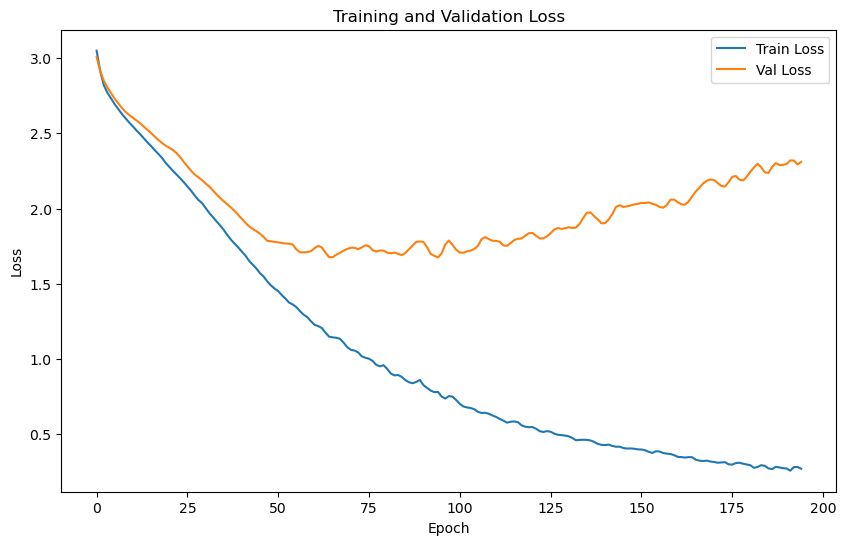

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.6984 | Test Accuracy: 41.66%


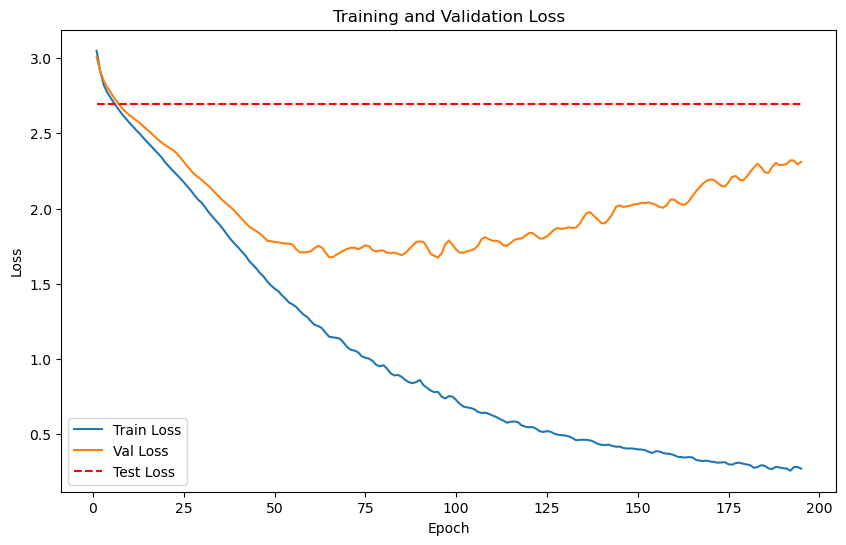

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10089, 64), 
Test labels shape: (10089,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 9.4615
Epoch [1/2000], Avg Train Loss: 9.4615
Epoch [1/2000], Avg Val Loss: 5.5922
Validation loss improved from inf to 5.5922. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.3865
Epoch [2/2000], Avg Train Loss: 9.3865
Epoch [2/2000], Avg Val Loss: 5.5366
Validation loss improved from 5.5922 to 5.5366. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 9.0603
Epoch [3/2000], Avg Train Loss: 9.0603
Epoch [3/2000], Avg Val Loss: 5.4821
Validation loss improved from 5.5366 to 5.4821. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 9.1787
Epoch [4/2000], Avg Train Loss: 9.1787
Epoch [4/2000], Avg Val Loss: 5.4288
Validation loss improved from 5.4821 to 5.4288. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.8069
Epoch [5/2000], Avg Train Loss: 8.8069
Epoch [5/2000], Avg Val Loss: 5.3766
Validation loss improved from 5.4288 to 5.3766. Saving mode

    Batch [1/1], Train Loss: 8.3020
Epoch [16/2000], Avg Train Loss: 8.3020
Epoch [16/2000], Avg Val Loss: 4.8731
Validation loss improved from 4.9138 to 4.8731. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 8.3135
Epoch [17/2000], Avg Train Loss: 8.3135
Epoch [17/2000], Avg Val Loss: 4.8330
Validation loss improved from 4.8731 to 4.8330. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 8.3236
Epoch [18/2000], Avg Train Loss: 8.3236
Epoch [18/2000], Avg Val Loss: 4.7938
Validation loss improved from 4.8330 to 4.7938. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 8.0411
Epoch [19/2000], Avg Train Loss: 8.0411
Epoch [19/2000], Avg Val Loss: 4.7553
Validation loss improved from 4.7938 to 4.7553. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 7.9145
Epoch [20/2000], Avg Train Loss: 7.9145
Epoch [20/2000], Avg Val Loss: 4.7176
Validation loss improved from 4.7553 to 4.

    Batch [1/1], Train Loss: 7.8567
Epoch [24/2000], Avg Train Loss: 7.8567
Epoch [24/2000], Avg Val Loss: 4.5761
Validation loss improved from 4.6100 to 4.5761. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 7.7230
Epoch [25/2000], Avg Train Loss: 7.7230
Epoch [25/2000], Avg Val Loss: 4.5431
Validation loss improved from 4.5761 to 4.5431. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 8.0721
Epoch [26/2000], Avg Train Loss: 8.0721
Epoch [26/2000], Avg Val Loss: 4.5109
Validation loss improved from 4.5431 to 4.5109. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 7.5796
Epoch [27/2000], Avg Train Loss: 7.5796
Epoch [27/2000], Avg Val Loss: 4.4797
Validation loss improved from 4.5109 to 4.4797. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 7.3006
Epoch [28/2000], Avg Train Loss: 7.3006
Epoch [28/2000], Avg Val Loss: 4.4495
Validation loss improved from 4.4797 to 4.

    Batch [1/1], Train Loss: 6.5766
Epoch [46/2000], Avg Train Loss: 6.5766
Epoch [46/2000], Avg Val Loss: 4.0461
Validation loss improved from 4.0624 to 4.0461. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 6.3575
Epoch [47/2000], Avg Train Loss: 6.3575
Epoch [47/2000], Avg Val Loss: 4.0302
Validation loss improved from 4.0461 to 4.0302. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 6.3333
Epoch [48/2000], Avg Train Loss: 6.3333
Epoch [48/2000], Avg Val Loss: 4.0149
Validation loss improved from 4.0302 to 4.0149. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 6.5497
Epoch [49/2000], Avg Train Loss: 6.5497
Epoch [49/2000], Avg Val Loss: 4.0001
Validation loss improved from 4.0149 to 4.0001. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 6.0538
Epoch [50/2000], Avg Train Loss: 6.0538
Epoch [50/2000], Avg Val Loss: 3.9859
Validation loss improved from 4.0001 to 3.

    Batch [1/1], Train Loss: 5.8150
Epoch [59/2000], Avg Train Loss: 5.8150
Epoch [59/2000], Avg Val Loss: 3.8804
Validation loss improved from 3.8903 to 3.8804. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.9309
Epoch [60/2000], Avg Train Loss: 5.9309
Epoch [60/2000], Avg Val Loss: 3.8707
Validation loss improved from 3.8804 to 3.8707. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.7024
Epoch [61/2000], Avg Train Loss: 5.7024
Epoch [61/2000], Avg Val Loss: 3.8616
Validation loss improved from 3.8707 to 3.8616. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.6279
Epoch [62/2000], Avg Train Loss: 5.6279
Epoch [62/2000], Avg Val Loss: 3.8529
Validation loss improved from 3.8616 to 3.8529. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.8488
Epoch [63/2000], Avg Train Loss: 5.8488
Epoch [63/2000], Avg Val Loss: 3.8444
Validation loss improved from 3.8529 to 3.

    Batch [1/1], Train Loss: 5.6568
Epoch [69/2000], Avg Train Loss: 5.6568
Epoch [69/2000], Avg Val Loss: 3.8003
Validation loss improved from 3.8069 to 3.8003. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 5.1651
Epoch [70/2000], Avg Train Loss: 5.1651
Epoch [70/2000], Avg Val Loss: 3.7941
Validation loss improved from 3.8003 to 3.7941. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.6700
Epoch [71/2000], Avg Train Loss: 5.6700
Epoch [71/2000], Avg Val Loss: 3.7880
Validation loss improved from 3.7941 to 3.7880. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.3963
Epoch [72/2000], Avg Train Loss: 5.3963
Epoch [72/2000], Avg Val Loss: 3.7823
Validation loss improved from 3.7880 to 3.7823. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.4081
Epoch [73/2000], Avg Train Loss: 5.4081
Epoch [73/2000], Avg Val Loss: 3.7766
Validation loss improved from 3.7823 to 3.

    Batch [1/1], Train Loss: 4.9333
Epoch [91/2000], Avg Train Loss: 4.9333
Epoch [91/2000], Avg Val Loss: 3.7080
Validation loss improved from 3.7106 to 3.7080. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 4.8751
Epoch [92/2000], Avg Train Loss: 4.8751
Epoch [92/2000], Avg Val Loss: 3.7055
Validation loss improved from 3.7080 to 3.7055. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 4.9325
Epoch [93/2000], Avg Train Loss: 4.9325
Epoch [93/2000], Avg Val Loss: 3.7031
Validation loss improved from 3.7055 to 3.7031. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 4.8388
Epoch [94/2000], Avg Train Loss: 4.8388
Epoch [94/2000], Avg Val Loss: 3.7009
Validation loss improved from 3.7031 to 3.7009. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 4.7065
Epoch [95/2000], Avg Train Loss: 4.7065
Epoch [95/2000], Avg Val Loss: 3.6986
Validation loss improved from 3.7009 to 3.

    Batch [1/1], Train Loss: 4.6819
Epoch [104/2000], Avg Train Loss: 4.6819
Epoch [104/2000], Avg Val Loss: 3.6808
Validation loss improved from 3.6826 to 3.6808. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 4.6709
Epoch [105/2000], Avg Train Loss: 4.6709
Epoch [105/2000], Avg Val Loss: 3.6792
Validation loss improved from 3.6808 to 3.6792. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.4723
Epoch [106/2000], Avg Train Loss: 4.4723
Epoch [106/2000], Avg Val Loss: 3.6775
Validation loss improved from 3.6792 to 3.6775. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.6000
Epoch [107/2000], Avg Train Loss: 4.6000
Epoch [107/2000], Avg Val Loss: 3.6759
Validation loss improved from 3.6775 to 3.6759. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.6937
Epoch [108/2000], Avg Train Loss: 4.6937
Epoch [108/2000], Avg Val Loss: 3.6744
Validation loss improved fro

Epoch [113/2000], Avg Val Loss: 3.6677
Validation loss improved from 3.6690 to 3.6677. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.5058
Epoch [114/2000], Avg Train Loss: 4.5058
Epoch [114/2000], Avg Val Loss: 3.6665
Validation loss improved from 3.6677 to 3.6665. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.5091
Epoch [115/2000], Avg Train Loss: 4.5091
Epoch [115/2000], Avg Val Loss: 3.6652
Validation loss improved from 3.6665 to 3.6652. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 4.5735
Epoch [116/2000], Avg Train Loss: 4.5735
Epoch [116/2000], Avg Val Loss: 3.6641
Validation loss improved from 3.6652 to 3.6641. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.4759
Epoch [117/2000], Avg Train Loss: 4.4759
Epoch [117/2000], Avg Val Loss: 3.6629
Validation loss improved from 3.6641 to 3.6629. Saving model...

LOG: Epoch [118/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2898
Epoch [139/2000], Avg Train Loss: 4.2898
Epoch [139/2000], Avg Val Loss: 3.6430
Validation loss improved from 3.6437 to 3.6430. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 4.2093
Epoch [140/2000], Avg Train Loss: 4.2093
Epoch [140/2000], Avg Val Loss: 3.6423
Validation loss improved from 3.6430 to 3.6423. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 4.2998
Epoch [141/2000], Avg Train Loss: 4.2998
Epoch [141/2000], Avg Val Loss: 3.6415
Validation loss improved from 3.6423 to 3.6415. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 4.3271
Epoch [142/2000], Avg Train Loss: 4.3271
Epoch [142/2000], Avg Val Loss: 3.6408
Validation loss improved from 3.6415 to 3.6408. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 4.2199
Epoch [143/2000], Avg Train Loss: 4.2199
Epoch [143/2000], Avg Val Loss: 3.6401
Validation loss improved fro

Epoch [149/2000], Avg Val Loss: 3.6363
Validation loss improved from 3.6369 to 3.6363. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 4.1714
Epoch [150/2000], Avg Train Loss: 4.1714
Epoch [150/2000], Avg Val Loss: 3.6357
Validation loss improved from 3.6363 to 3.6357. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 4.1979
Epoch [151/2000], Avg Train Loss: 4.1979
Epoch [151/2000], Avg Val Loss: 3.6351
Validation loss improved from 3.6357 to 3.6351. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 4.1628
Epoch [152/2000], Avg Train Loss: 4.1628
Epoch [152/2000], Avg Val Loss: 3.6345
Validation loss improved from 3.6351 to 3.6345. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 4.2142
Epoch [153/2000], Avg Train Loss: 4.2142
Epoch [153/2000], Avg Val Loss: 3.6338
Validation loss improved from 3.6345 to 3.6338. Saving model...

LOG: Epoch [154/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2433
Epoch [156/2000], Avg Train Loss: 4.2433
Epoch [156/2000], Avg Val Loss: 3.6319
Validation loss improved from 3.6326 to 3.6319. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.1224
Epoch [157/2000], Avg Train Loss: 4.1224
Epoch [157/2000], Avg Val Loss: 3.6312
Validation loss improved from 3.6319 to 3.6312. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 4.1429
Epoch [158/2000], Avg Train Loss: 4.1429
Epoch [158/2000], Avg Val Loss: 3.6305
Validation loss improved from 3.6312 to 3.6305. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 4.1969
Epoch [159/2000], Avg Train Loss: 4.1969
Epoch [159/2000], Avg Val Loss: 3.6297
Validation loss improved from 3.6305 to 3.6297. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 4.1238
Epoch [160/2000], Avg Train Loss: 4.1238
Epoch [160/2000], Avg Val Loss: 3.6290
Validation loss improved fro

Epoch [186/2000], Avg Val Loss: 3.6115
Validation loss improved from 3.6122 to 3.6115. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 4.0662
Epoch [187/2000], Avg Train Loss: 4.0662
Epoch [187/2000], Avg Val Loss: 3.6108
Validation loss improved from 3.6115 to 3.6108. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 4.0418
Epoch [188/2000], Avg Train Loss: 4.0418
Epoch [188/2000], Avg Val Loss: 3.6102
Validation loss improved from 3.6108 to 3.6102. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 3.9951
Epoch [189/2000], Avg Train Loss: 3.9951
Epoch [189/2000], Avg Val Loss: 3.6094
Validation loss improved from 3.6102 to 3.6094. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 4.0800
Epoch [190/2000], Avg Train Loss: 4.0800
Epoch [190/2000], Avg Val Loss: 3.6088
Validation loss improved from 3.6094 to 3.6088. Saving model...

LOG: Epoch [191/2000] - Training
    Bat

Epoch [195/2000], Avg Val Loss: 3.6053
Validation loss improved from 3.6060 to 3.6053. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 4.0146
Epoch [196/2000], Avg Train Loss: 4.0146
Epoch [196/2000], Avg Val Loss: 3.6046
Validation loss improved from 3.6053 to 3.6046. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 4.0281
Epoch [197/2000], Avg Train Loss: 4.0281
Epoch [197/2000], Avg Val Loss: 3.6039
Validation loss improved from 3.6046 to 3.6039. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 3.9380
Epoch [198/2000], Avg Train Loss: 3.9380
Epoch [198/2000], Avg Val Loss: 3.6032
Validation loss improved from 3.6039 to 3.6032. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 4.0006
Epoch [199/2000], Avg Train Loss: 4.0006
Epoch [199/2000], Avg Val Loss: 3.6025
Validation loss improved from 3.6032 to 3.6025. Saving model...

LOG: Epoch [200/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0100
Epoch [233/2000], Avg Train Loss: 4.0100
Epoch [233/2000], Avg Val Loss: 3.5806
Validation loss improved from 3.5812 to 3.5806. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 4.0005
Epoch [234/2000], Avg Train Loss: 4.0005
Epoch [234/2000], Avg Val Loss: 3.5800
Validation loss improved from 3.5806 to 3.5800. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 3.9602
Epoch [235/2000], Avg Train Loss: 3.9602
Epoch [235/2000], Avg Val Loss: 3.5794
Validation loss improved from 3.5800 to 3.5794. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 3.9762
Epoch [236/2000], Avg Train Loss: 3.9762
Epoch [236/2000], Avg Val Loss: 3.5789
Validation loss improved from 3.5794 to 3.5789. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 3.9608
Epoch [237/2000], Avg Train Loss: 3.9608
Epoch [237/2000], Avg Val Loss: 3.5783
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8105
Epoch [244/2000], Avg Train Loss: 3.8105
Epoch [244/2000], Avg Val Loss: 3.5742
Validation loss improved from 3.5747 to 3.5742. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 3.8875
Epoch [245/2000], Avg Train Loss: 3.8875
Epoch [245/2000], Avg Val Loss: 3.5736
Validation loss improved from 3.5742 to 3.5736. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 3.9407
Epoch [246/2000], Avg Train Loss: 3.9407
Epoch [246/2000], Avg Val Loss: 3.5730
Validation loss improved from 3.5736 to 3.5730. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 3.9129
Epoch [247/2000], Avg Train Loss: 3.9129
Epoch [247/2000], Avg Val Loss: 3.5724
Validation loss improved from 3.5730 to 3.5724. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 3.8937
Epoch [248/2000], Avg Train Loss: 3.8937
Epoch [248/2000], Avg Val Loss: 3.5718
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8922
Epoch [275/2000], Avg Train Loss: 3.8922
Epoch [275/2000], Avg Val Loss: 3.5536
Validation loss improved from 3.5542 to 3.5536. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 3.8533
Epoch [276/2000], Avg Train Loss: 3.8533
Epoch [276/2000], Avg Val Loss: 3.5530
Validation loss improved from 3.5536 to 3.5530. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 3.8363
Epoch [277/2000], Avg Train Loss: 3.8363
Epoch [277/2000], Avg Val Loss: 3.5524
Validation loss improved from 3.5530 to 3.5524. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 3.8048
Epoch [278/2000], Avg Train Loss: 3.8048
Epoch [278/2000], Avg Val Loss: 3.5518
Validation loss improved from 3.5524 to 3.5518. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 3.8219
Epoch [279/2000], Avg Train Loss: 3.8219
Epoch [279/2000], Avg Val Loss: 3.5513
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7298
Epoch [291/2000], Avg Train Loss: 3.7298
Epoch [291/2000], Avg Val Loss: 3.5438
Validation loss improved from 3.5445 to 3.5438. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 3.7497
Epoch [292/2000], Avg Train Loss: 3.7497
Epoch [292/2000], Avg Val Loss: 3.5431
Validation loss improved from 3.5438 to 3.5431. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 3.7727
Epoch [293/2000], Avg Train Loss: 3.7727
Epoch [293/2000], Avg Val Loss: 3.5425
Validation loss improved from 3.5431 to 3.5425. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 3.8484
Epoch [294/2000], Avg Train Loss: 3.8484
Epoch [294/2000], Avg Val Loss: 3.5418
Validation loss improved from 3.5425 to 3.5418. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 3.7256
Epoch [295/2000], Avg Train Loss: 3.7256
Epoch [295/2000], Avg Val Loss: 3.5410
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7407
Epoch [319/2000], Avg Train Loss: 3.7407
Epoch [319/2000], Avg Val Loss: 3.5265
Validation loss improved from 3.5270 to 3.5265. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 3.6898
Epoch [320/2000], Avg Train Loss: 3.6898
Epoch [320/2000], Avg Val Loss: 3.5259
Validation loss improved from 3.5265 to 3.5259. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 3.7049
Epoch [321/2000], Avg Train Loss: 3.7049
Epoch [321/2000], Avg Val Loss: 3.5253
Validation loss improved from 3.5259 to 3.5253. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 3.6563
Epoch [322/2000], Avg Train Loss: 3.6563
Epoch [322/2000], Avg Val Loss: 3.5248
Validation loss improved from 3.5253 to 3.5248. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 3.7557
Epoch [323/2000], Avg Train Loss: 3.7557
Epoch [323/2000], Avg Val Loss: 3.5241
Validation loss improved fro

Epoch [335/2000], Avg Val Loss: 3.5165
Validation loss improved from 3.5171 to 3.5165. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 3.7331
Epoch [336/2000], Avg Train Loss: 3.7331
Epoch [336/2000], Avg Val Loss: 3.5160
Validation loss improved from 3.5165 to 3.5160. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 3.7082
Epoch [337/2000], Avg Train Loss: 3.7082
Epoch [337/2000], Avg Val Loss: 3.5154
Validation loss improved from 3.5160 to 3.5154. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 3.7045
Epoch [338/2000], Avg Train Loss: 3.7045
Epoch [338/2000], Avg Val Loss: 3.5148
Validation loss improved from 3.5154 to 3.5148. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 3.6871
Epoch [339/2000], Avg Train Loss: 3.6871
Epoch [339/2000], Avg Val Loss: 3.5142
Validation loss improved from 3.5148 to 3.5142. Saving model...

LOG: Epoch [340/2000] - Training
    Bat

Epoch [361/2000], Avg Val Loss: 3.5020
Validation loss improved from 3.5026 to 3.5020. Saving model...

LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 3.7103
Epoch [362/2000], Avg Train Loss: 3.7103
Epoch [362/2000], Avg Val Loss: 3.5014
Validation loss improved from 3.5020 to 3.5014. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 3.7420
Epoch [363/2000], Avg Train Loss: 3.7420
Epoch [363/2000], Avg Val Loss: 3.5009
Validation loss improved from 3.5014 to 3.5009. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 3.6835
Epoch [364/2000], Avg Train Loss: 3.6835
Epoch [364/2000], Avg Val Loss: 3.5003
Validation loss improved from 3.5009 to 3.5003. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 3.6516
Epoch [365/2000], Avg Train Loss: 3.6516
Epoch [365/2000], Avg Val Loss: 3.4998
Validation loss improved from 3.5003 to 3.4998. Saving model...

LOG: Epoch [366/2000] - Training
    Bat

Epoch [373/2000], Avg Val Loss: 3.4956
Validation loss improved from 3.4961 to 3.4956. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 3.6538
Epoch [374/2000], Avg Train Loss: 3.6538
Epoch [374/2000], Avg Val Loss: 3.4950
Validation loss improved from 3.4956 to 3.4950. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 3.6696
Epoch [375/2000], Avg Train Loss: 3.6696
Epoch [375/2000], Avg Val Loss: 3.4945
Validation loss improved from 3.4950 to 3.4945. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 3.6346
Epoch [376/2000], Avg Train Loss: 3.6346
Epoch [376/2000], Avg Val Loss: 3.4939
Validation loss improved from 3.4945 to 3.4939. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 3.6364
Epoch [377/2000], Avg Train Loss: 3.6364
Epoch [377/2000], Avg Val Loss: 3.4933
Validation loss improved from 3.4939 to 3.4933. Saving model...

LOG: Epoch [378/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7701
Epoch [406/2000], Avg Train Loss: 3.7701
Epoch [406/2000], Avg Val Loss: 3.4780
Validation loss improved from 3.4784 to 3.4780. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 3.5685
Epoch [407/2000], Avg Train Loss: 3.5685
Epoch [407/2000], Avg Val Loss: 3.4776
Validation loss improved from 3.4780 to 3.4776. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 3.5922
Epoch [408/2000], Avg Train Loss: 3.5922
Epoch [408/2000], Avg Val Loss: 3.4772
Validation loss improved from 3.4776 to 3.4772. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 3.6588
Epoch [409/2000], Avg Train Loss: 3.6588
Epoch [409/2000], Avg Val Loss: 3.4768
Validation loss improved from 3.4772 to 3.4768. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 3.6647
Epoch [410/2000], Avg Train Loss: 3.6647
Epoch [410/2000], Avg Val Loss: 3.4765
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5803
Epoch [419/2000], Avg Train Loss: 3.5803
Epoch [419/2000], Avg Val Loss: 3.4729
Validation loss improved from 3.4734 to 3.4729. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 3.5132
Epoch [420/2000], Avg Train Loss: 3.5132
Epoch [420/2000], Avg Val Loss: 3.4724
Validation loss improved from 3.4729 to 3.4724. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 3.5513
Epoch [421/2000], Avg Train Loss: 3.5513
Epoch [421/2000], Avg Val Loss: 3.4719
Validation loss improved from 3.4724 to 3.4719. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 3.6001
Epoch [422/2000], Avg Train Loss: 3.6001
Epoch [422/2000], Avg Val Loss: 3.4715
Validation loss improved from 3.4719 to 3.4715. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 3.5174
Epoch [423/2000], Avg Train Loss: 3.5174
Epoch [423/2000], Avg Val Loss: 3.4710
Validation loss improved fro

Epoch [453/2000], Avg Val Loss: 3.4578
Validation loss improved from 3.4582 to 3.4578. Saving model...

LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 3.4934
Epoch [454/2000], Avg Train Loss: 3.4934
Epoch [454/2000], Avg Val Loss: 3.4573
Validation loss improved from 3.4578 to 3.4573. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 3.5145
Epoch [455/2000], Avg Train Loss: 3.5145
Epoch [455/2000], Avg Val Loss: 3.4569
Validation loss improved from 3.4573 to 3.4569. Saving model...

LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 3.5372
Epoch [456/2000], Avg Train Loss: 3.5372
Epoch [456/2000], Avg Val Loss: 3.4565
Validation loss improved from 3.4569 to 3.4565. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 3.4815
Epoch [457/2000], Avg Train Loss: 3.4815
Epoch [457/2000], Avg Val Loss: 3.4561
Validation loss improved from 3.4565 to 3.4561. Saving model...

LOG: Epoch [458/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5065
Epoch [465/2000], Avg Train Loss: 3.5065
Epoch [465/2000], Avg Val Loss: 3.4525
Validation loss improved from 3.4529 to 3.4525. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 3.4674
Epoch [466/2000], Avg Train Loss: 3.4674
Epoch [466/2000], Avg Val Loss: 3.4520
Validation loss improved from 3.4525 to 3.4520. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 3.5291
Epoch [467/2000], Avg Train Loss: 3.5291
Epoch [467/2000], Avg Val Loss: 3.4516
Validation loss improved from 3.4520 to 3.4516. Saving model...

LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 3.5018
Epoch [468/2000], Avg Train Loss: 3.5018
Epoch [468/2000], Avg Val Loss: 3.4511
Validation loss improved from 3.4516 to 3.4511. Saving model...

LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 3.5144
Epoch [469/2000], Avg Train Loss: 3.5144
Epoch [469/2000], Avg Val Loss: 3.4506
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4779
Epoch [500/2000], Avg Train Loss: 3.4779
Epoch [500/2000], Avg Val Loss: 3.4406
Validation loss improved from 3.4409 to 3.4406. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 3.4703
Epoch [501/2000], Avg Train Loss: 3.4703
Epoch [501/2000], Avg Val Loss: 3.4403
Validation loss improved from 3.4406 to 3.4403. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 3.4962
Epoch [502/2000], Avg Train Loss: 3.4962
Epoch [502/2000], Avg Val Loss: 3.4399
Validation loss improved from 3.4403 to 3.4399. Saving model...

LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 3.4561
Epoch [503/2000], Avg Train Loss: 3.4561
Epoch [503/2000], Avg Val Loss: 3.4395
Validation loss improved from 3.4399 to 3.4395. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 3.4829
Epoch [504/2000], Avg Train Loss: 3.4829
Epoch [504/2000], Avg Val Loss: 3.4391
Validation loss improved fro

Epoch [509/2000], Avg Val Loss: 3.4372
Validation loss improved from 3.4375 to 3.4372. Saving model...

LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 3.5314
Epoch [510/2000], Avg Train Loss: 3.5314
Epoch [510/2000], Avg Val Loss: 3.4369
Validation loss improved from 3.4372 to 3.4369. Saving model...

LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 3.4714
Epoch [511/2000], Avg Train Loss: 3.4714
Epoch [511/2000], Avg Val Loss: 3.4366
Validation loss improved from 3.4369 to 3.4366. Saving model...

LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 3.4319
Epoch [512/2000], Avg Train Loss: 3.4319
Epoch [512/2000], Avg Val Loss: 3.4362
Validation loss improved from 3.4366 to 3.4362. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 3.4751
Epoch [513/2000], Avg Train Loss: 3.4751
Epoch [513/2000], Avg Val Loss: 3.4358
Validation loss improved from 3.4362 to 3.4358. Saving model...

LOG: Epoch [514/2000] - Training
    Bat

Epoch [546/2000], Avg Val Loss: 3.4247
Validation loss improved from 3.4250 to 3.4247. Saving model...

LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 3.3577
Epoch [547/2000], Avg Train Loss: 3.3577
Epoch [547/2000], Avg Val Loss: 3.4244
Validation loss improved from 3.4247 to 3.4244. Saving model...

LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 3.4179
Epoch [548/2000], Avg Train Loss: 3.4179
Epoch [548/2000], Avg Val Loss: 3.4242
Validation loss improved from 3.4244 to 3.4242. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 3.4533
Epoch [549/2000], Avg Train Loss: 3.4533
Epoch [549/2000], Avg Val Loss: 3.4239
Validation loss improved from 3.4242 to 3.4239. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 3.3304
Epoch [550/2000], Avg Train Loss: 3.3304
Epoch [550/2000], Avg Val Loss: 3.4237
Validation loss improved from 3.4239 to 3.4237. Saving model...

LOG: Epoch [551/2000] - Training
    Bat

Epoch [556/2000], Avg Val Loss: 3.4218
Validation loss improved from 3.4221 to 3.4218. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 3.4103
Epoch [557/2000], Avg Train Loss: 3.4103
Epoch [557/2000], Avg Val Loss: 3.4215
Validation loss improved from 3.4218 to 3.4215. Saving model...

LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 3.3883
Epoch [558/2000], Avg Train Loss: 3.3883
Epoch [558/2000], Avg Val Loss: 3.4213
Validation loss improved from 3.4215 to 3.4213. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 3.4641
Epoch [559/2000], Avg Train Loss: 3.4641
Epoch [559/2000], Avg Val Loss: 3.4210
Validation loss improved from 3.4213 to 3.4210. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 3.3365
Epoch [560/2000], Avg Train Loss: 3.3365
Epoch [560/2000], Avg Val Loss: 3.4207
Validation loss improved from 3.4210 to 3.4207. Saving model...

LOG: Epoch [561/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.3794
Epoch [592/2000], Avg Train Loss: 3.3794
Epoch [592/2000], Avg Val Loss: 3.4083
Validation loss improved from 3.4086 to 3.4083. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 3.3613
Epoch [593/2000], Avg Train Loss: 3.3613
Epoch [593/2000], Avg Val Loss: 3.4080
Validation loss improved from 3.4083 to 3.4080. Saving model...

LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 3.3308
Epoch [594/2000], Avg Train Loss: 3.3308
Epoch [594/2000], Avg Val Loss: 3.4077
Validation loss improved from 3.4080 to 3.4077. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 3.4123
Epoch [595/2000], Avg Train Loss: 3.4123
Epoch [595/2000], Avg Val Loss: 3.4075
Validation loss improved from 3.4077 to 3.4075. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 3.4016
Epoch [596/2000], Avg Train Loss: 3.4016
Epoch [596/2000], Avg Val Loss: 3.4072
Validation loss improved fro

Epoch [598/2000], Avg Val Loss: 3.4068
Validation loss improved from 3.4070 to 3.4068. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 3.3981
Epoch [599/2000], Avg Train Loss: 3.3981
Epoch [599/2000], Avg Val Loss: 3.4067
Validation loss improved from 3.4068 to 3.4067. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 3.3510
Epoch [600/2000], Avg Train Loss: 3.3510
Epoch [600/2000], Avg Val Loss: 3.4066
Validation loss improved from 3.4067 to 3.4066. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 3.3857
Epoch [601/2000], Avg Train Loss: 3.3857
Epoch [601/2000], Avg Val Loss: 3.4065
Validation loss improved from 3.4066 to 3.4065. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 3.3395
Epoch [602/2000], Avg Train Loss: 3.3395
Epoch [602/2000], Avg Val Loss: 3.4063
Validation loss improved from 3.4065 to 3.4063. Saving model...

LOG: Epoch [603/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2787
Epoch [633/2000], Avg Train Loss: 3.2787
Epoch [633/2000], Avg Val Loss: 3.3972
Validation loss improved from 3.3975 to 3.3972. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 3.3627
Epoch [634/2000], Avg Train Loss: 3.3627
Epoch [634/2000], Avg Val Loss: 3.3972
Validation loss improved from 3.3972 to 3.3972. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 3.3005
Epoch [635/2000], Avg Train Loss: 3.3005
Epoch [635/2000], Avg Val Loss: 3.3972
Validation loss did not improve. Patience: 1/100

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 3.3310
Epoch [636/2000], Avg Train Loss: 3.3310
Epoch [636/2000], Avg Val Loss: 3.3972
Validation loss improved from 3.3972 to 3.3972. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 3.3644
Epoch [637/2000], Avg Train Loss: 3.3644
Epoch [637/2000], Avg Val Loss: 3.3971
Validation loss improved from 3.3972 to 3.3

    Batch [1/1], Train Loss: 3.4303
Epoch [643/2000], Avg Train Loss: 3.4303
Epoch [643/2000], Avg Val Loss: 3.3964
Validation loss improved from 3.3965 to 3.3964. Saving model...

LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 3.3658
Epoch [644/2000], Avg Train Loss: 3.3658
Epoch [644/2000], Avg Val Loss: 3.3962
Validation loss improved from 3.3964 to 3.3962. Saving model...

LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 3.3029
Epoch [645/2000], Avg Train Loss: 3.3029
Epoch [645/2000], Avg Val Loss: 3.3960
Validation loss improved from 3.3962 to 3.3960. Saving model...

LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 3.3263
Epoch [646/2000], Avg Train Loss: 3.3263
Epoch [646/2000], Avg Val Loss: 3.3959
Validation loss improved from 3.3960 to 3.3959. Saving model...

LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 3.3830
Epoch [647/2000], Avg Train Loss: 3.3830
Epoch [647/2000], Avg Val Loss: 3.3958
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2335
Epoch [682/2000], Avg Train Loss: 3.2335
Epoch [682/2000], Avg Val Loss: 3.3860
Validation loss improved from 3.3862 to 3.3860. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 3.3102
Epoch [683/2000], Avg Train Loss: 3.3102
Epoch [683/2000], Avg Val Loss: 3.3857
Validation loss improved from 3.3860 to 3.3857. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 3.2775
Epoch [684/2000], Avg Train Loss: 3.2775
Epoch [684/2000], Avg Val Loss: 3.3854
Validation loss improved from 3.3857 to 3.3854. Saving model...

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 3.2505
Epoch [685/2000], Avg Train Loss: 3.2505
Epoch [685/2000], Avg Val Loss: 3.3853
Validation loss improved from 3.3854 to 3.3853. Saving model...

LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 3.2949
Epoch [686/2000], Avg Train Loss: 3.2949
Epoch [686/2000], Avg Val Loss: 3.3852
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2961
Epoch [727/2000], Avg Train Loss: 3.2961
Epoch [727/2000], Avg Val Loss: 3.3771
Validation loss improved from 3.3773 to 3.3771. Saving model...

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 3.2183
Epoch [728/2000], Avg Train Loss: 3.2183
Epoch [728/2000], Avg Val Loss: 3.3770
Validation loss improved from 3.3771 to 3.3770. Saving model...

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 3.3094
Epoch [729/2000], Avg Train Loss: 3.3094
Epoch [729/2000], Avg Val Loss: 3.3769
Validation loss improved from 3.3770 to 3.3769. Saving model...

LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 3.2094
Epoch [730/2000], Avg Train Loss: 3.2094
Epoch [730/2000], Avg Val Loss: 3.3768
Validation loss improved from 3.3769 to 3.3768. Saving model...

LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 3.2383
Epoch [731/2000], Avg Train Loss: 3.2383
Epoch [731/2000], Avg Val Loss: 3.3768
Validation loss improved fro

Epoch [772/2000], Avg Train Loss: 3.1898
Epoch [772/2000], Avg Val Loss: 3.3703
Validation loss improved from 3.3704 to 3.3703. Saving model...

LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 3.1597
Epoch [773/2000], Avg Train Loss: 3.1597
Epoch [773/2000], Avg Val Loss: 3.3702
Validation loss improved from 3.3703 to 3.3702. Saving model...

LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 3.1349
Epoch [774/2000], Avg Train Loss: 3.1349
Epoch [774/2000], Avg Val Loss: 3.3701
Validation loss improved from 3.3702 to 3.3701. Saving model...

LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 3.1744
Epoch [775/2000], Avg Train Loss: 3.1744
Epoch [775/2000], Avg Val Loss: 3.3700
Validation loss improved from 3.3701 to 3.3700. Saving model...

LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 3.2307
Epoch [776/2000], Avg Train Loss: 3.2307
Epoch [776/2000], Avg Val Loss: 3.3699
Validation loss improved from 3.3700 to 3.3699. Saving model...


    Batch [1/1], Train Loss: 3.1325
Epoch [816/2000], Avg Train Loss: 3.1325
Epoch [816/2000], Avg Val Loss: 3.3693
Validation loss improved from 3.3694 to 3.3693. Saving model...

LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 3.1906
Epoch [817/2000], Avg Train Loss: 3.1906
Epoch [817/2000], Avg Val Loss: 3.3693
Validation loss improved from 3.3693 to 3.3693. Saving model...

LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 3.1546
Epoch [818/2000], Avg Train Loss: 3.1546
Epoch [818/2000], Avg Val Loss: 3.3693
Validation loss did not improve. Patience: 1/100

LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 3.0969
Epoch [819/2000], Avg Train Loss: 3.0969
Epoch [819/2000], Avg Val Loss: 3.3694
Validation loss did not improve. Patience: 2/100

LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 3.1596
Epoch [820/2000], Avg Train Loss: 3.1596
Epoch [820/2000], Avg Val Loss: 3.3694
Validation loss did not improve. Patience: 3/100

LOG: Epo

    Batch [1/1], Train Loss: 3.1973
Epoch [862/2000], Avg Train Loss: 3.1973
Epoch [862/2000], Avg Val Loss: 3.3655
Validation loss improved from 3.3657 to 3.3655. Saving model...

LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 3.1419
Epoch [863/2000], Avg Train Loss: 3.1419
Epoch [863/2000], Avg Val Loss: 3.3651
Validation loss improved from 3.3655 to 3.3651. Saving model...

LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 3.2134
Epoch [864/2000], Avg Train Loss: 3.2134
Epoch [864/2000], Avg Val Loss: 3.3647
Validation loss improved from 3.3651 to 3.3647. Saving model...

LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 3.1182
Epoch [865/2000], Avg Train Loss: 3.1182
Epoch [865/2000], Avg Val Loss: 3.3644
Validation loss improved from 3.3647 to 3.3644. Saving model...

LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 3.1044
Epoch [866/2000], Avg Train Loss: 3.1044
Epoch [866/2000], Avg Val Loss: 3.3642
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1196
Epoch [906/2000], Avg Train Loss: 3.1196
Epoch [906/2000], Avg Val Loss: 3.3674
Validation loss did not improve. Patience: 37/100

LOG: Epoch [907/2000] - Training
    Batch [1/1], Train Loss: 3.1479
Epoch [907/2000], Avg Train Loss: 3.1479
Epoch [907/2000], Avg Val Loss: 3.3673
Validation loss did not improve. Patience: 38/100

LOG: Epoch [908/2000] - Training
    Batch [1/1], Train Loss: 3.0815
Epoch [908/2000], Avg Train Loss: 3.0815
Epoch [908/2000], Avg Val Loss: 3.3672
Validation loss did not improve. Patience: 39/100

LOG: Epoch [909/2000] - Training
    Batch [1/1], Train Loss: 3.0864
Epoch [909/2000], Avg Train Loss: 3.0864
Epoch [909/2000], Avg Val Loss: 3.3672
Validation loss did not improve. Patience: 40/100

LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 3.1150
Epoch [910/2000], Avg Train Loss: 3.1150
Epoch [910/2000], Avg Val Loss: 3.3673
Validation loss did not improve. Patience: 41/100

LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 3.1340
Epoch [949/2000], Avg Train Loss: 3.1340
Epoch [949/2000], Avg Val Loss: 3.3672
Validation loss did not improve. Patience: 80/100

LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 3.1074
Epoch [950/2000], Avg Train Loss: 3.1074
Epoch [950/2000], Avg Val Loss: 3.3671
Validation loss did not improve. Patience: 81/100

LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 3.0534
Epoch [951/2000], Avg Train Loss: 3.0534
Epoch [951/2000], Avg Val Loss: 3.3670
Validation loss did not improve. Patience: 82/100

LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 3.0307
Epoch [952/2000], Avg Train Loss: 3.0307
Epoch [952/2000], Avg Val Loss: 3.3668
Validation loss did not improve. Patience: 83/100

LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 3.0083
Epoch [953/2000], Avg Train Loss: 3.0083
Epoch [953/2000], Avg Val Loss: 3.3667
Validation loss did not improve. Patience: 84/100

LOG: Epoch [954/2000] - Training


Epoch [998/2000], Avg Val Loss: 3.3705
Validation loss did not improve. Patience: 18/100

LOG: Epoch [999/2000] - Training
    Batch [1/1], Train Loss: 3.0076
Epoch [999/2000], Avg Train Loss: 3.0076
Epoch [999/2000], Avg Val Loss: 3.3708
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1000/2000] - Training
    Batch [1/1], Train Loss: 3.0598
Epoch [1000/2000], Avg Train Loss: 3.0598
Epoch [1000/2000], Avg Val Loss: 3.3709
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1001/2000] - Training
    Batch [1/1], Train Loss: 3.0519
Epoch [1001/2000], Avg Train Loss: 3.0519
Epoch [1001/2000], Avg Val Loss: 3.3708
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1002/2000] - Training
    Batch [1/1], Train Loss: 3.0009
Epoch [1002/2000], Avg Train Loss: 3.0009
Epoch [1002/2000], Avg Val Loss: 3.3709
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 3.0052
Epoch [1003/2000], Avg Train Lo

Epoch [1047/2000], Avg Val Loss: 3.3727
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1048/2000] - Training
    Batch [1/1], Train Loss: 3.0915
Epoch [1048/2000], Avg Train Loss: 3.0915
Epoch [1048/2000], Avg Val Loss: 3.3729
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1049/2000] - Training
    Batch [1/1], Train Loss: 2.9810
Epoch [1049/2000], Avg Train Loss: 2.9810
Epoch [1049/2000], Avg Val Loss: 3.3733
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 3.0254
Epoch [1050/2000], Avg Train Loss: 3.0254
Epoch [1050/2000], Avg Val Loss: 3.3737
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1051/2000] - Training
    Batch [1/1], Train Loss: 3.0103
Epoch [1051/2000], Avg Train Loss: 3.0103
Epoch [1051/2000], Avg Val Loss: 3.3741
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 2.9989
Epoch [1052/2000], Avg Trai

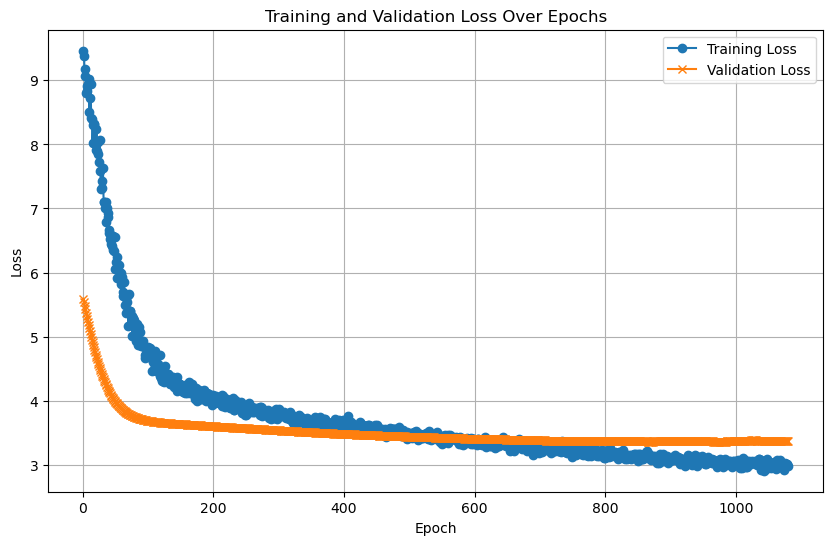

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/40], Loss: 4.7630
Test Batch [20/40], Loss: 5.8325
Test Batch [30/40], Loss: 6.2299
Test Batch [40/40], Loss: 5.0274

Test Loss: 5.3597


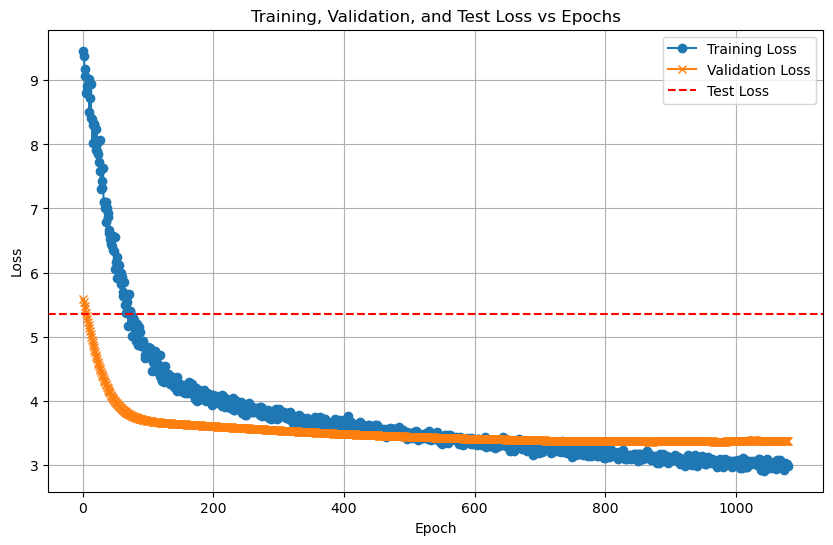

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/40 for test dataset.


  Processed batch 20/40 for test dataset.


  Processed batch 30/40 for test dataset.
  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 55.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.17      0.20      0.18         5
           2       0.00      0.00      0.00         5
           3       0.50      0.20      0.29         5
           4       0.80      0.80      0.80         5
           5       0.57      0.80      0.67         5
           6       0.83      1.00      0.91         5
           7       0.57      0.80      0.67         5
           8       0.71      1.00      0.83         5
           9       0.67      0.80      0.73         5
          10       0.14      0.20      0.17         5
          11       0.33      0.20      0.25         5
          12       0.67      0.80      0.73         5
          13       0.7

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8922  |  Val Loss: 2.8682
Validation loss improved from inf to 2.8682.
[Epoch 2/1000] Train Loss: 2.8779  |  Val Loss: 2.8566
Validation loss improved from 2.8682 to 2.8566.
[Epoch 3/1000] Train Loss: 2.8643  |  Val Loss: 2.8455
Validation loss improved from 2.8566 to 2.8455.
[Epoch 4/1000] Train Loss: 2.8523  |  Val Loss: 2.8345
Validation loss improved from 2.8455 to 2.8345.
[Epoch 5/1000] Train Loss: 2.8392  |  Val Loss: 2.8239
Validation loss improved from 2.8345 to 2.8239.
[Epoch 6/1000] Train Loss: 2.8278  |  Val Loss: 2.8137
Validation loss improved from 2.8239 to 2.8137.
[Epoch 7/1000] Train Loss: 2.8156  |  Val Loss: 2.8037
Validation loss improved from 2.8137 to 2.8037.
[Epoch 8/1000] Train Loss: 2.8036  |  Val Loss: 2.7936
Validation loss improved from 2.8037 to 2.7936.
[Epoch 9/1000] Train Loss: 2.7923  |  Val Loss: 2.7834
Validation loss improved from 2.7936 to 2.7834.
[Epoch 10/1000] Train Loss: 2.7804  |  Val Loss: 2.7735
Validation loss impr

[Epoch 21/1000] Train Loss: 2.6866  |  Val Loss: 2.6956
Validation loss improved from 2.7009 to 2.6956.
[Epoch 22/1000] Train Loss: 2.6803  |  Val Loss: 2.6907
Validation loss improved from 2.6956 to 2.6907.
[Epoch 23/1000] Train Loss: 2.6735  |  Val Loss: 2.6860
Validation loss improved from 2.6907 to 2.6860.
[Epoch 24/1000] Train Loss: 2.6682  |  Val Loss: 2.6814
Validation loss improved from 2.6860 to 2.6814.
[Epoch 25/1000] Train Loss: 2.6613  |  Val Loss: 2.6773
Validation loss improved from 2.6814 to 2.6773.
[Epoch 26/1000] Train Loss: 2.6558  |  Val Loss: 2.6737
Validation loss improved from 2.6773 to 2.6737.
[Epoch 27/1000] Train Loss: 2.6497  |  Val Loss: 2.6703
Validation loss improved from 2.6737 to 2.6703.
[Epoch 28/1000] Train Loss: 2.6441  |  Val Loss: 2.6670
Validation loss improved from 2.6703 to 2.6670.
[Epoch 29/1000] Train Loss: 2.6389  |  Val Loss: 2.6639
Validation loss improved from 2.6670 to 2.6639.
[Epoch 30/1000] Train Loss: 2.6336  |  Val Loss: 2.6608
Validati

[Epoch 34/1000] Train Loss: 2.6135  |  Val Loss: 2.6478
Validation loss improved from 2.6512 to 2.6478.
[Epoch 35/1000] Train Loss: 2.6086  |  Val Loss: 2.6446
Validation loss improved from 2.6478 to 2.6446.
[Epoch 36/1000] Train Loss: 2.6038  |  Val Loss: 2.6413
Validation loss improved from 2.6446 to 2.6413.
[Epoch 37/1000] Train Loss: 2.5988  |  Val Loss: 2.6379
Validation loss improved from 2.6413 to 2.6379.
[Epoch 38/1000] Train Loss: 2.5937  |  Val Loss: 2.6345
Validation loss improved from 2.6379 to 2.6345.
[Epoch 39/1000] Train Loss: 2.5889  |  Val Loss: 2.6310
Validation loss improved from 2.6345 to 2.6310.
[Epoch 40/1000] Train Loss: 2.5839  |  Val Loss: 2.6275
Validation loss improved from 2.6310 to 2.6275.
[Epoch 41/1000] Train Loss: 2.5787  |  Val Loss: 2.6238
Validation loss improved from 2.6275 to 2.6238.
[Epoch 42/1000] Train Loss: 2.5736  |  Val Loss: 2.6201
Validation loss improved from 2.6238 to 2.6201.
[Epoch 43/1000] Train Loss: 2.5685  |  Val Loss: 2.6161
Validati

[Epoch 60/1000] Train Loss: 2.4826  |  Val Loss: 2.5470
Validation loss improved from 2.5510 to 2.5470.
[Epoch 61/1000] Train Loss: 2.4776  |  Val Loss: 2.5428
Validation loss improved from 2.5470 to 2.5428.
[Epoch 62/1000] Train Loss: 2.4725  |  Val Loss: 2.5385
Validation loss improved from 2.5428 to 2.5385.
[Epoch 63/1000] Train Loss: 2.4673  |  Val Loss: 2.5346
Validation loss improved from 2.5385 to 2.5346.
[Epoch 64/1000] Train Loss: 2.4621  |  Val Loss: 2.5309
Validation loss improved from 2.5346 to 2.5309.
[Epoch 65/1000] Train Loss: 2.4572  |  Val Loss: 2.5274
Validation loss improved from 2.5309 to 2.5274.
[Epoch 66/1000] Train Loss: 2.4519  |  Val Loss: 2.5242
Validation loss improved from 2.5274 to 2.5242.
[Epoch 67/1000] Train Loss: 2.4471  |  Val Loss: 2.5209
Validation loss improved from 2.5242 to 2.5209.
[Epoch 68/1000] Train Loss: 2.4419  |  Val Loss: 2.5178
Validation loss improved from 2.5209 to 2.5178.
[Epoch 69/1000] Train Loss: 2.4369  |  Val Loss: 2.5145
Validati

[Epoch 77/1000] Train Loss: 2.3922  |  Val Loss: 2.4815
Validation loss improved from 2.4857 to 2.4815.
[Epoch 78/1000] Train Loss: 2.3858  |  Val Loss: 2.4770
Validation loss improved from 2.4815 to 2.4770.
[Epoch 79/1000] Train Loss: 2.3798  |  Val Loss: 2.4719
Validation loss improved from 2.4770 to 2.4719.
[Epoch 80/1000] Train Loss: 2.3736  |  Val Loss: 2.4671
Validation loss improved from 2.4719 to 2.4671.
[Epoch 81/1000] Train Loss: 2.3674  |  Val Loss: 2.4621
Validation loss improved from 2.4671 to 2.4621.
[Epoch 82/1000] Train Loss: 2.3612  |  Val Loss: 2.4570
Validation loss improved from 2.4621 to 2.4570.
[Epoch 83/1000] Train Loss: 2.3550  |  Val Loss: 2.4520
Validation loss improved from 2.4570 to 2.4520.
[Epoch 84/1000] Train Loss: 2.3493  |  Val Loss: 2.4467
Validation loss improved from 2.4520 to 2.4467.
[Epoch 85/1000] Train Loss: 2.3433  |  Val Loss: 2.4419
Validation loss improved from 2.4467 to 2.4419.
[Epoch 86/1000] Train Loss: 2.3372  |  Val Loss: 2.4373
Validati

[Epoch 101/1000] Train Loss: 2.2494  |  Val Loss: 2.3749
Validation loss improved from 2.3791 to 2.3749.
[Epoch 102/1000] Train Loss: 2.2436  |  Val Loss: 2.3707
Validation loss improved from 2.3749 to 2.3707.
[Epoch 103/1000] Train Loss: 2.2375  |  Val Loss: 2.3664
Validation loss improved from 2.3707 to 2.3664.
[Epoch 104/1000] Train Loss: 2.2319  |  Val Loss: 2.3624
Validation loss improved from 2.3664 to 2.3624.
[Epoch 105/1000] Train Loss: 2.2254  |  Val Loss: 2.3585
Validation loss improved from 2.3624 to 2.3585.
[Epoch 106/1000] Train Loss: 2.2194  |  Val Loss: 2.3549
Validation loss improved from 2.3585 to 2.3549.
[Epoch 107/1000] Train Loss: 2.2133  |  Val Loss: 2.3514
Validation loss improved from 2.3549 to 2.3514.
[Epoch 108/1000] Train Loss: 2.2073  |  Val Loss: 2.3483
Validation loss improved from 2.3514 to 2.3483.
[Epoch 109/1000] Train Loss: 2.2013  |  Val Loss: 2.3458
Validation loss improved from 2.3483 to 2.3458.
[Epoch 110/1000] Train Loss: 2.1951  |  Val Loss: 2.343

[Epoch 119/1000] Train Loss: 2.1418  |  Val Loss: 2.3219
Validation loss improved from 2.3238 to 2.3219.
[Epoch 120/1000] Train Loss: 2.1360  |  Val Loss: 2.3193
Validation loss improved from 2.3219 to 2.3193.
[Epoch 121/1000] Train Loss: 2.1302  |  Val Loss: 2.3166
Validation loss improved from 2.3193 to 2.3166.
[Epoch 122/1000] Train Loss: 2.1249  |  Val Loss: 2.3136
Validation loss improved from 2.3166 to 2.3136.
[Epoch 123/1000] Train Loss: 2.1196  |  Val Loss: 2.3101
Validation loss improved from 2.3136 to 2.3101.
[Epoch 124/1000] Train Loss: 2.1140  |  Val Loss: 2.3059
Validation loss improved from 2.3101 to 2.3059.
[Epoch 125/1000] Train Loss: 2.1086  |  Val Loss: 2.3023
Validation loss improved from 2.3059 to 2.3023.
[Epoch 126/1000] Train Loss: 2.1027  |  Val Loss: 2.2997
Validation loss improved from 2.3023 to 2.2997.
[Epoch 127/1000] Train Loss: 2.0971  |  Val Loss: 2.2970
Validation loss improved from 2.2997 to 2.2970.
[Epoch 128/1000] Train Loss: 2.0914  |  Val Loss: 2.294

[Epoch 140/1000] Train Loss: 2.0206  |  Val Loss: 2.2688
Validation loss improved from 2.2713 to 2.2688.
[Epoch 141/1000] Train Loss: 2.0147  |  Val Loss: 2.2665
Validation loss improved from 2.2688 to 2.2665.
[Epoch 142/1000] Train Loss: 2.0091  |  Val Loss: 2.2643
Validation loss improved from 2.2665 to 2.2643.
[Epoch 143/1000] Train Loss: 2.0031  |  Val Loss: 2.2617
Validation loss improved from 2.2643 to 2.2617.
[Epoch 144/1000] Train Loss: 1.9973  |  Val Loss: 2.2583
Validation loss improved from 2.2617 to 2.2583.
[Epoch 145/1000] Train Loss: 1.9915  |  Val Loss: 2.2547
Validation loss improved from 2.2583 to 2.2547.
[Epoch 146/1000] Train Loss: 1.9856  |  Val Loss: 2.2516
Validation loss improved from 2.2547 to 2.2516.
[Epoch 147/1000] Train Loss: 1.9797  |  Val Loss: 2.2490
Validation loss improved from 2.2516 to 2.2490.
[Epoch 148/1000] Train Loss: 1.9742  |  Val Loss: 2.2465
Validation loss improved from 2.2490 to 2.2465.
[Epoch 149/1000] Train Loss: 1.9684  |  Val Loss: 2.243

[Epoch 156/1000] Train Loss: 1.9272  |  Val Loss: 2.2235
Validation loss improved from 2.2262 to 2.2235.
[Epoch 157/1000] Train Loss: 1.9217  |  Val Loss: 2.2214
Validation loss improved from 2.2235 to 2.2214.
[Epoch 158/1000] Train Loss: 1.9156  |  Val Loss: 2.2193
Validation loss improved from 2.2214 to 2.2193.
[Epoch 159/1000] Train Loss: 1.9097  |  Val Loss: 2.2169
Validation loss improved from 2.2193 to 2.2169.
[Epoch 160/1000] Train Loss: 1.9031  |  Val Loss: 2.2147
Validation loss improved from 2.2169 to 2.2147.
[Epoch 161/1000] Train Loss: 1.8969  |  Val Loss: 2.2127
Validation loss improved from 2.2147 to 2.2127.
[Epoch 162/1000] Train Loss: 1.8906  |  Val Loss: 2.2108
Validation loss improved from 2.2127 to 2.2108.
[Epoch 163/1000] Train Loss: 1.8847  |  Val Loss: 2.2088
Validation loss improved from 2.2108 to 2.2088.
[Epoch 164/1000] Train Loss: 1.8792  |  Val Loss: 2.2065
Validation loss improved from 2.2088 to 2.2065.
[Epoch 165/1000] Train Loss: 1.8731  |  Val Loss: 2.204

[Epoch 183/1000] Train Loss: 1.7640  |  Val Loss: 2.1463
Validation loss improved from 2.1493 to 2.1463.
[Epoch 184/1000] Train Loss: 1.7579  |  Val Loss: 2.1434
Validation loss improved from 2.1463 to 2.1434.
[Epoch 185/1000] Train Loss: 1.7518  |  Val Loss: 2.1406
Validation loss improved from 2.1434 to 2.1406.
[Epoch 186/1000] Train Loss: 1.7460  |  Val Loss: 2.1381
Validation loss improved from 2.1406 to 2.1381.
[Epoch 187/1000] Train Loss: 1.7400  |  Val Loss: 2.1357
Validation loss improved from 2.1381 to 2.1357.
[Epoch 188/1000] Train Loss: 1.7340  |  Val Loss: 2.1334
Validation loss improved from 2.1357 to 2.1334.
[Epoch 189/1000] Train Loss: 1.7282  |  Val Loss: 2.1312
Validation loss improved from 2.1334 to 2.1312.
[Epoch 190/1000] Train Loss: 1.7224  |  Val Loss: 2.1288
Validation loss improved from 2.1312 to 2.1288.
[Epoch 191/1000] Train Loss: 1.7164  |  Val Loss: 2.1262
Validation loss improved from 2.1288 to 2.1262.
[Epoch 192/1000] Train Loss: 1.7104  |  Val Loss: 2.122

[Epoch 196/1000] Train Loss: 1.6870  |  Val Loss: 2.1105
Validation loss improved from 2.1127 to 2.1105.
[Epoch 197/1000] Train Loss: 1.6811  |  Val Loss: 2.1080
Validation loss improved from 2.1105 to 2.1080.
[Epoch 198/1000] Train Loss: 1.6754  |  Val Loss: 2.1061
Validation loss improved from 2.1080 to 2.1061.
[Epoch 199/1000] Train Loss: 1.6699  |  Val Loss: 2.1049
Validation loss improved from 2.1061 to 2.1049.
[Epoch 200/1000] Train Loss: 1.6644  |  Val Loss: 2.1038
Validation loss improved from 2.1049 to 2.1038.
[Epoch 201/1000] Train Loss: 1.6584  |  Val Loss: 2.1022
Validation loss improved from 2.1038 to 2.1022.
[Epoch 202/1000] Train Loss: 1.6526  |  Val Loss: 2.1003
Validation loss improved from 2.1022 to 2.1003.
[Epoch 203/1000] Train Loss: 1.6471  |  Val Loss: 2.0987
Validation loss improved from 2.1003 to 2.0987.
[Epoch 204/1000] Train Loss: 1.6411  |  Val Loss: 2.0965
Validation loss improved from 2.0987 to 2.0965.
[Epoch 205/1000] Train Loss: 1.6352  |  Val Loss: 2.094

[Epoch 222/1000] Train Loss: 1.5386  |  Val Loss: 2.0773
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 223/1000] Train Loss: 1.5333  |  Val Loss: 2.0777
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 224/1000] Train Loss: 1.5280  |  Val Loss: 2.0776
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 225/1000] Train Loss: 1.5221  |  Val Loss: 2.0758
Validation loss improved from 2.0767 to 2.0758.
[Epoch 226/1000] Train Loss: 1.5162  |  Val Loss: 2.0737
Validation loss improved from 2.0758 to 2.0737.
[Epoch 227/1000] Train Loss: 1.5096  |  Val Loss: 2.0716
Validation loss improved from 2.0737 to 2.0716.
[Epoch 228/1000] Train Loss: 1.5039  |  Val Loss: 2.0687
Validation loss improved from 2.0716 to 2.0687.
[Epoch 229/1000] Train Loss: 1.4969  |  Val Loss: 2.0644
Validation loss improved from 2.0687 to 2.0644.
[Epoch 230/1000] Train Loss: 1.4910  |  Val Loss: 2.0600
Validation loss improved from 2.0644 to 2.0600.
[Epoch 231/1000] Train Loss: 1.4847  

[Epoch 239/1000] Train Loss: 1.4411  |  Val Loss: 2.0398
Validation loss improved from 2.0422 to 2.0398.
[Epoch 240/1000] Train Loss: 1.4357  |  Val Loss: 2.0381
Validation loss improved from 2.0398 to 2.0381.
[Epoch 241/1000] Train Loss: 1.4299  |  Val Loss: 2.0372
Validation loss improved from 2.0381 to 2.0372.
[Epoch 242/1000] Train Loss: 1.4245  |  Val Loss: 2.0362
Validation loss improved from 2.0372 to 2.0362.
[Epoch 243/1000] Train Loss: 1.4184  |  Val Loss: 2.0347
Validation loss improved from 2.0362 to 2.0347.
[Epoch 244/1000] Train Loss: 1.4135  |  Val Loss: 2.0328
Validation loss improved from 2.0347 to 2.0328.
[Epoch 245/1000] Train Loss: 1.4079  |  Val Loss: 2.0306
Validation loss improved from 2.0328 to 2.0306.
[Epoch 246/1000] Train Loss: 1.4027  |  Val Loss: 2.0288
Validation loss improved from 2.0306 to 2.0288.
[Epoch 247/1000] Train Loss: 1.3973  |  Val Loss: 2.0282
Validation loss improved from 2.0288 to 2.0282.
[Epoch 248/1000] Train Loss: 1.3920  |  Val Loss: 2.027

[Epoch 263/1000] Train Loss: 1.3115  |  Val Loss: 2.0181
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 264/1000] Train Loss: 1.3066  |  Val Loss: 2.0191
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 265/1000] Train Loss: 1.3023  |  Val Loss: 2.0191
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 266/1000] Train Loss: 1.2965  |  Val Loss: 2.0183
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 267/1000] Train Loss: 1.2910  |  Val Loss: 2.0172
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 268/1000] Train Loss: 1.2854  |  Val Loss: 2.0157
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 269/1000] Train Loss: 1.2800  |  Val Loss: 2.0134
Validation loss improved from 2.0138 to 2.0134.
[Epoch 270/1000] Train Loss: 1.2751  |  Val Loss: 2.0107
Validation loss improved from 2.0134 to 2.0107.
[Epoch 271/1000] Train Loss: 1.2700  |  Val Loss: 2.0088
Validation loss improved from 2.0107 to 2.0088.
[Epoch 272/1000] Tr

[Epoch 278/1000] Train Loss: 1.2359  |  Val Loss: 2.0044
Validation loss improved from 2.0051 to 2.0044.
[Epoch 279/1000] Train Loss: 1.2305  |  Val Loss: 2.0037
Validation loss improved from 2.0044 to 2.0037.
[Epoch 280/1000] Train Loss: 1.2252  |  Val Loss: 2.0026
Validation loss improved from 2.0037 to 2.0026.
[Epoch 281/1000] Train Loss: 1.2199  |  Val Loss: 2.0006
Validation loss improved from 2.0026 to 2.0006.
[Epoch 282/1000] Train Loss: 1.2150  |  Val Loss: 1.9989
Validation loss improved from 2.0006 to 1.9989.
[Epoch 283/1000] Train Loss: 1.2106  |  Val Loss: 1.9986
Validation loss improved from 1.9989 to 1.9986.
[Epoch 284/1000] Train Loss: 1.2060  |  Val Loss: 1.9991
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 285/1000] Train Loss: 1.2009  |  Val Loss: 1.9987
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 286/1000] Train Loss: 1.1961  |  Val Loss: 1.9975
Validation loss improved from 1.9986 to 1.9975.
[Epoch 287/1000] Train Loss: 1.1914  |  Val

[Epoch 302/1000] Train Loss: 1.1231  |  Val Loss: 1.9877
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 303/1000] Train Loss: 1.1188  |  Val Loss: 1.9883
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 304/1000] Train Loss: 1.1143  |  Val Loss: 1.9888
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 305/1000] Train Loss: 1.1101  |  Val Loss: 1.9898
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 306/1000] Train Loss: 1.1056  |  Val Loss: 1.9903
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 307/1000] Train Loss: 1.1025  |  Val Loss: 1.9906
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 308/1000] Train Loss: 1.0982  |  Val Loss: 1.9902
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 309/1000] Train Loss: 1.0942  |  Val Loss: 1.9886
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 310/1000] Train Loss: 1.0904  |  Val Loss: 1.9872
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 316/1000] Train Loss: 1.0668  |  Val Loss: 1.9875
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 317/1000] Train Loss: 1.0621  |  Val Loss: 1.9857
Validation loss improved from 1.9868 to 1.9857.
[Epoch 318/1000] Train Loss: 1.0579  |  Val Loss: 1.9842
Validation loss improved from 1.9857 to 1.9842.
[Epoch 319/1000] Train Loss: 1.0541  |  Val Loss: 1.9834
Validation loss improved from 1.9842 to 1.9834.
[Epoch 320/1000] Train Loss: 1.0503  |  Val Loss: 1.9827
Validation loss improved from 1.9834 to 1.9827.
[Epoch 321/1000] Train Loss: 1.0466  |  Val Loss: 1.9832
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 322/1000] Train Loss: 1.0431  |  Val Loss: 1.9842
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 323/1000] Train Loss: 1.0390  |  Val Loss: 1.9848
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 324/1000] Train Loss: 1.0355  |  Val Loss: 1.9857
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 325/1000] Train Lo

[Epoch 340/1000] Train Loss: 0.9807  |  Val Loss: 1.9907
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 341/1000] Train Loss: 0.9770  |  Val Loss: 1.9906
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 342/1000] Train Loss: 0.9731  |  Val Loss: 1.9896
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 343/1000] Train Loss: 0.9692  |  Val Loss: 1.9875
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 344/1000] Train Loss: 0.9659  |  Val Loss: 1.9855
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 345/1000] Train Loss: 0.9617  |  Val Loss: 1.9845
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 346/1000] Train Loss: 0.9590  |  Val Loss: 1.9841
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 347/1000] Train Loss: 0.9555  |  Val Loss: 1.9844
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 348/1000] Train Loss: 0.9521  |  Val Loss: 1.9845
!! Validation loss did NOT improve !! Patience:

[Epoch 352/1000] Train Loss: 0.9397  |  Val Loss: 1.9848
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 353/1000] Train Loss: 0.9363  |  Val Loss: 1.9842
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 354/1000] Train Loss: 0.9333  |  Val Loss: 1.9841
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 355/1000] Train Loss: 0.9302  |  Val Loss: 1.9845
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 356/1000] Train Loss: 0.9273  |  Val Loss: 1.9847
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 357/1000] Train Loss: 0.9237  |  Val Loss: 1.9847
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 358/1000] Train Loss: 0.9210  |  Val Loss: 1.9847
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 359/1000] Train Loss: 0.9183  |  Val Loss: 1.9853
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 360/1000] Train Loss: 0.9157  |  Val Loss: 1.9850
!! Validation loss did NOT improve !! Patience:

[Epoch 377/1000] Train Loss: 0.8676  |  Val Loss: 2.0002
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 378/1000] Train Loss: 0.8648  |  Val Loss: 1.9992
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 379/1000] Train Loss: 0.8622  |  Val Loss: 1.9982
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 380/1000] Train Loss: 0.8600  |  Val Loss: 1.9975
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 381/1000] Train Loss: 0.8571  |  Val Loss: 1.9986
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 382/1000] Train Loss: 0.8547  |  Val Loss: 2.0006
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 383/1000] Train Loss: 0.8529  |  Val Loss: 2.0013
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 384/1000] Train Loss: 0.8491  |  Val Loss: 2.0006
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 385/1000] Train Loss: 0.8474  |  Val Loss: 2.0012
!! Validation loss did NOT improve !! Patience:

[Epoch 393/1000] Train Loss: 0.8287  |  Val Loss: 2.0105
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 394/1000] Train Loss: 0.8262  |  Val Loss: 2.0103
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 395/1000] Train Loss: 0.8234  |  Val Loss: 2.0101
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 396/1000] Train Loss: 0.8203  |  Val Loss: 2.0088
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 397/1000] Train Loss: 0.8182  |  Val Loss: 2.0078
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 398/1000] Train Loss: 0.8157  |  Val Loss: 2.0087
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 399/1000] Train Loss: 0.8134  |  Val Loss: 2.0091
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 400/1000] Train Loss: 0.8111  |  Val Loss: 2.0091
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 401/1000] Train Loss: 0.8089  |  Val Loss: 2.0096
!! Validation loss did NOT improve !! Patience:

[Epoch 415/1000] Train Loss: 0.7771  |  Val Loss: 2.0194
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 416/1000] Train Loss: 0.7759  |  Val Loss: 2.0196
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 417/1000] Train Loss: 0.7736  |  Val Loss: 2.0202
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 418/1000] Train Loss: 0.7714  |  Val Loss: 2.0206
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 419/1000] Train Loss: 0.7693  |  Val Loss: 2.0209
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 420/1000] Train Loss: 0.7670  |  Val Loss: 2.0225
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 420 !!
No improvement for 100 epochs.


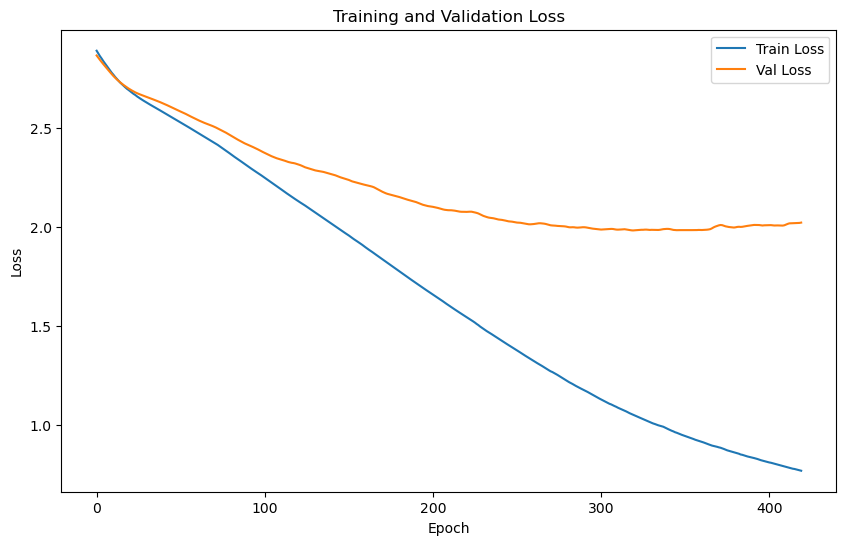

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.1215 | Test Accuracy: 39.37%


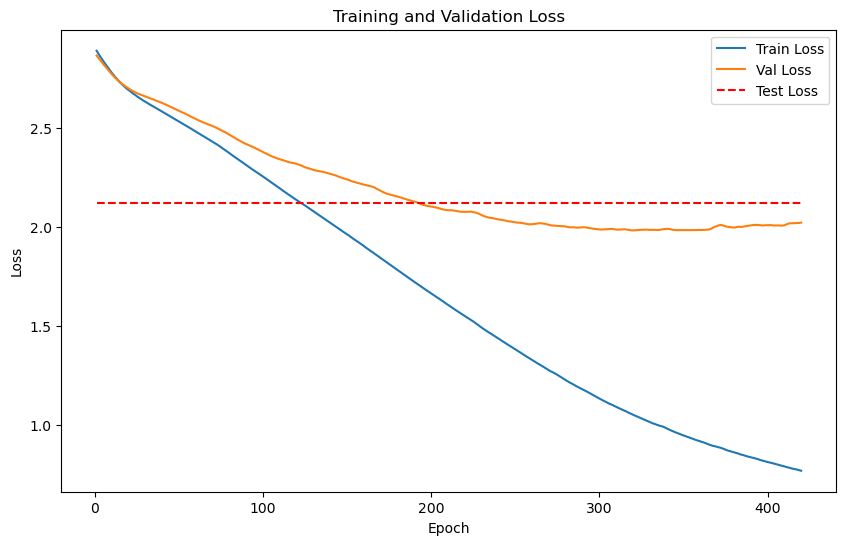

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10089, 64), 
Test labels shape: (10089,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5026
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5141
    Batch [2/2], Val Loss: 0.3440
Epoch [1/2000], Avg Train Loss: 0.5026, Avg Val Loss: 0.4291

Validation loss improved from inf to 0.4291. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5141
    Batch [2/2], Val Loss: 0.3420
Epoch [2/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.4281

Validation loss improved from 0.4291 to 0.4281. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4964
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5143
    Batch [2/2], Val Loss: 0.3402
Epoch [3/2000], Avg Train Loss: 0.4964, Avg Val Loss: 0.4273

Validation loss improved from 0.4281 to 0.4273. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5140
    Batch [2/2], Val Loss: 0.3387
Epoch [4/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.4264

Validation loss improved from 0.4273 to 0.4264. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5011
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.3373
Epoch [5/2000], Avg Train Loss: 0.5011, Avg Val Loss: 0.4254

Validation loss improved from 0.4264 to 0.4254. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4989
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.3358
Epoch [6/2000], Avg Train Loss: 0.4989, Avg Val Loss: 0.4242

Validation loss improved from 0.4254 to 0.4242. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5114
    Batch [2/2], Val Loss: 0.3345
Epoch [7/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.4230

Validation loss improved from 0.4242 to 0.4230. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.5033
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5101
    Batch [2/2], Val Loss: 0.3334
Epoch [8/2000], Avg Train Loss: 0.5033, Avg Val Loss: 0.4218

Validation loss improved from 0.4230 to 0.4218. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.3326
Epoch [9/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.4206

Validation loss improved from 0.4218 to 0.4206. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4967
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5075
    Batch [2/2], Val Loss: 0.3319
Epoch [10/2000], Avg Train Loss: 0.4967, Avg Val Loss: 0.4197

Validation loss improved from 0.4206 to 0.4197. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4989
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.3315
Epoch [11/2000], Avg Train Loss: 0.4989, Avg Val Loss: 0.4192

Validation loss improved from 0.4197 to 0.4192. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.5027
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5058
    Batch [2/2], Val Loss: 0.3310
Epoch [12/2000], Avg Train Loss: 0.5027, Avg Val Loss: 0.4184

Validation loss improved from 0.4192 to 0.4184. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5049
    Batch [2/2], Val Loss: 0.3305
Epoch [13/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.4177

Validation loss improved from 0.4184 to 0.4177. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4958
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5037
    Batch [2/2], Val Loss: 0.3298
Epoch [14/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.4167

Validation loss improved from 0.4177 to 0.4167. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.3291
Epoch [15/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.4157

Validation loss improved from 0.4167 to 0.4157. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5004
    Batch [2/2], Val Loss: 0.3285
Epoch [16/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.4145

Validation loss improved from 0.4157 to 0.4145. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.3279
Epoch [17/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.4132

Validation loss improved from 0.4145 to 0.4132. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4967
    Batch [2/2], Val Loss: 0.3274
Epoch [18/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4120

Validation loss improved from 0.4132 to 0.4120. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4949
    Batch [2/2], Val Loss: 0.3270
Epoch [19/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.4109

Validation loss improved from 0.4120 to 0.4109. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.3267
Epoch [20/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.4099

Validation loss improved from 0.4109 to 0.4099. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4916
    Batch [2/2], Val Loss: 0.3264
Epoch [21/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.4090

Validation loss improved from 0.4099 to 0.4090. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4900
    Batch [2/2], Val Loss: 0.3261
Epoch [22/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4081

Validation loss improved from 0.4090 to 0.4081. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4886
    Batch [2/2], Val Loss: 0.3259
Epoch [23/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.4072

Validation loss improved from 0.4081 to 0.4072. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4873
    Batch [2/2], Val Loss: 0.3257
Epoch [24/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4065

Validation loss improved from 0.4072 to 0.4065. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.3257
Epoch [25/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4059

Validation loss improved from 0.4065 to 0.4059. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4968
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4852
    Batch [2/2], Val Loss: 0.3257
Epoch [26/2000], Avg Train Loss: 0.4968, Avg Val Loss: 0.4055

Validation loss improved from 0.4059 to 0.4055. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.3258
Epoch [27/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.4051

Validation loss improved from 0.4055 to 0.4051. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.3259
Epoch [28/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4047

Validation loss improved from 0.4051 to 0.4047. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4829
    Batch [2/2], Val Loss: 0.3260
Epoch [29/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4044

Validation loss improved from 0.4047 to 0.4044. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.3261
Epoch [30/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4042

Validation loss improved from 0.4044 to 0.4042. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4818
    Batch [2/2], Val Loss: 0.3262
Epoch [31/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.4040

Validation loss improved from 0.4042 to 0.4040. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4812
    Batch [2/2], Val Loss: 0.3264
Epoch [32/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4038

Validation loss improved from 0.4040 to 0.4038. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.3265
Epoch [33/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4036

Validation loss improved from 0.4038 to 0.4036. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.3267
Epoch [34/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4034

Validation loss improved from 0.4036 to 0.4034. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.3268
Epoch [35/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4033

Validation loss improved from 0.4034 to 0.4033. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.3270
Epoch [36/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4031

Validation loss improved from 0.4033 to 0.4031. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.3272
Epoch [37/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4030

Validation loss improved from 0.4031 to 0.4030. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.3275
Epoch [38/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4030

Validation loss improved from 0.4030 to 0.4030. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.3277
Epoch [39/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.4029

Validation loss improved from 0.4030 to 0.4029. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4778
    Batch [2/2], Val Loss: 0.3279
Epoch [40/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4028

Validation loss improved from 0.4029 to 0.4028. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.3280
Epoch [41/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.4028

Validation loss improved from 0.4028 to 0.4028. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.3281
Epoch [42/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4026

Validation loss improved from 0.4028 to 0.4026. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.3281
Epoch [43/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.4025

Validation loss improved from 0.4026 to 0.4025. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.3282
Epoch [44/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.4024

Validation loss improved from 0.4025 to 0.4024. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.3283
Epoch [45/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.4023

Validation loss improved from 0.4024 to 0.4023. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.3284
Epoch [46/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4022

Validation loss improved from 0.4023 to 0.4022. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.3284
Epoch [47/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.4021

Validation loss improved from 0.4022 to 0.4021. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4755
    Batch [2/2], Val Loss: 0.3286
Epoch [48/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4021

Validation loss improved from 0.4021 to 0.4021. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4753
    Batch [2/2], Val Loss: 0.3287
Epoch [49/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.4020

Validation loss improved from 0.4021 to 0.4020. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.3288
Epoch [50/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4019

Validation loss improved from 0.4020 to 0.4019. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4780
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4748
    Batch [2/2], Val Loss: 0.3288
Epoch [51/2000], Avg Train Loss: 0.4780, Avg Val Loss: 0.4018

Validation loss improved from 0.4019 to 0.4018. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4745
    Batch [2/2], Val Loss: 0.3289
Epoch [52/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4017

Validation loss improved from 0.4018 to 0.4017. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4767
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.3290
Epoch [53/2000], Avg Train Loss: 0.4767, Avg Val Loss: 0.4017

Validation loss improved from 0.4017 to 0.4017. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.3291
Epoch [54/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.4016

Validation loss improved from 0.4017 to 0.4016. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4738
    Batch [2/2], Val Loss: 0.3291
Epoch [55/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4015

Validation loss improved from 0.4016 to 0.4015. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4736
    Batch [2/2], Val Loss: 0.3293
Epoch [56/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.4014

Validation loss improved from 0.4015 to 0.4014. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.3293
Epoch [57/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.4013

Validation loss improved from 0.4014 to 0.4013. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4732
    Batch [2/2], Val Loss: 0.3293
Epoch [58/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.4012

Validation loss improved from 0.4013 to 0.4012. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.3293
Epoch [59/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.4011

Validation loss improved from 0.4012 to 0.4011. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.3293
Epoch [60/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4010

Validation loss improved from 0.4011 to 0.4010. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.3292
Epoch [61/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4009

Validation loss improved from 0.4010 to 0.4009. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4724
    Batch [2/2], Val Loss: 0.3291
Epoch [62/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.4008

Validation loss improved from 0.4009 to 0.4008. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4723
    Batch [2/2], Val Loss: 0.3290
Epoch [63/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.4006

Validation loss improved from 0.4008 to 0.4006. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4721
    Batch [2/2], Val Loss: 0.3287
Epoch [64/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.4004

Validation loss improved from 0.4006 to 0.4004. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4720
    Batch [2/2], Val Loss: 0.3285
Epoch [65/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.4002

Validation loss improved from 0.4004 to 0.4002. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4718
    Batch [2/2], Val Loss: 0.3283
Epoch [66/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.4001

Validation loss improved from 0.4002 to 0.4001. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4763
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.3282
Epoch [67/2000], Avg Train Loss: 0.4763, Avg Val Loss: 0.3999

Validation loss improved from 0.4001 to 0.3999. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.3280
Epoch [68/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.3998

Validation loss improved from 0.3999 to 0.3998. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4714
    Batch [2/2], Val Loss: 0.3279
Epoch [69/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.3996

Validation loss improved from 0.3998 to 0.3996. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.3278
Epoch [70/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.3995

Validation loss improved from 0.3996 to 0.3995. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.3277
Epoch [71/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.3994

Validation loss improved from 0.3995 to 0.3994. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4708
    Batch [2/2], Val Loss: 0.3276
Epoch [72/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.3992

Validation loss improved from 0.3994 to 0.3992. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4707
    Batch [2/2], Val Loss: 0.3275
Epoch [73/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.3991

Validation loss improved from 0.3992 to 0.3991. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.3274
Epoch [74/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.3990

Validation loss improved from 0.3991 to 0.3990. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4704
    Batch [2/2], Val Loss: 0.3273
Epoch [75/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.3988

Validation loss improved from 0.3990 to 0.3988. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4703
    Batch [2/2], Val Loss: 0.3270
Epoch [76/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.3987

Validation loss improved from 0.3988 to 0.3987. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.3269
Epoch [77/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.3985

Validation loss improved from 0.3987 to 0.3985. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4701
    Batch [2/2], Val Loss: 0.3268
Epoch [78/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.3984

Validation loss improved from 0.3985 to 0.3984. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4641
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.3266
Epoch [79/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.3983

Validation loss improved from 0.3984 to 0.3983. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.3265
Epoch [80/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.3982

Validation loss improved from 0.3983 to 0.3982. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.3264
Epoch [81/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.3981

Validation loss improved from 0.3982 to 0.3981. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.3263
Epoch [82/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.3980

Validation loss improved from 0.3981 to 0.3980. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4695
    Batch [2/2], Val Loss: 0.3263
Epoch [83/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.3979

Validation loss improved from 0.3980 to 0.3979. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.3263
Epoch [84/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.3978

Validation loss improved from 0.3979 to 0.3978. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.3263
Epoch [85/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.3978

Validation loss improved from 0.3978 to 0.3978. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.3263
Epoch [86/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.3978

Validation loss improved from 0.3978 to 0.3978. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.3264
Epoch [87/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.3977

Validation loss improved from 0.3978 to 0.3977. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4618
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4690
    Batch [2/2], Val Loss: 0.3264
Epoch [88/2000], Avg Train Loss: 0.4618, Avg Val Loss: 0.3977

Validation loss improved from 0.3977 to 0.3977. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4568
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.3265
Epoch [89/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.3977

Validation loss improved from 0.3977 to 0.3977. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.3265
Epoch [90/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.3977

Validation loss improved from 0.3977 to 0.3977. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.3267
Epoch [91/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.3977

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.3268
Epoch [92/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.3269
Epoch [93/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.3271
Epoch [94/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.3979

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.3272
Epoch [95/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.3979

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.3274
Epoch [96/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.3980

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3276
Epoch [97/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.3980

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.3278
Epoch [98/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.3980

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.3279
Epoch [99/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.3981

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.3281
Epoch [100/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.3981

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.3281
Epoch [101/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.3981

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.3282
Epoch [102/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.3981

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.3281
Epoch [103/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.3980

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.3281
Epoch [104/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.3980

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.3279
Epoch [105/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.3979

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4555
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.3279
Epoch [106/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.3280
Epoch [107/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.3281
Epoch [108/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.3281
Epoch [109/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4674
    Batch [2/2], Val Loss: 0.3281
Epoch [110/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.3977

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.3281
Epoch [111/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.3977

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.3280
Epoch [112/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.3976

Validation loss improved from 0.3977 to 0.3976. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.3279
Epoch [113/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.3975

Validation loss improved from 0.3976 to 0.3975. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4671
    Batch [2/2], Val Loss: 0.3278
Epoch [114/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.3975

Validation loss improved from 0.3975 to 0.3975. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4671
    Batch [2/2], Val Loss: 0.3277
Epoch [115/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.3974

Validation loss improved from 0.3975 to 0.3974. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4670
    Batch [2/2], Val Loss: 0.3276
Epoch [116/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.3973

Validation loss improved from 0.3974 to 0.3973. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4670
    Batch [2/2], Val Loss: 0.3274
Epoch [117/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.3972

Validation loss improved from 0.3973 to 0.3972. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.3273
Epoch [118/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.3971

Validation loss improved from 0.3972 to 0.3971. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.3272
Epoch [119/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.3970

Validation loss improved from 0.3971 to 0.3970. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.3270
Epoch [120/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.3969

Validation loss improved from 0.3970 to 0.3969. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.3269
Epoch [121/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.3968

Validation loss improved from 0.3969 to 0.3968. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.3267
Epoch [122/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.3967

Validation loss improved from 0.3968 to 0.3967. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.3265
Epoch [123/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.3966

Validation loss improved from 0.3967 to 0.3966. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.3264
Epoch [124/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.3965

Validation loss improved from 0.3966 to 0.3965. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.3263
Epoch [125/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.3964

Validation loss improved from 0.3965 to 0.3964. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4665
    Batch [2/2], Val Loss: 0.3262
Epoch [126/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.3963

Validation loss improved from 0.3964 to 0.3963. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4664
    Batch [2/2], Val Loss: 0.3261
Epoch [127/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.3962

Validation loss improved from 0.3963 to 0.3962. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.3259
Epoch [128/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.3961

Validation loss improved from 0.3962 to 0.3961. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.3258
Epoch [129/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.3959

Validation loss improved from 0.3961 to 0.3959. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4406
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.3256
Epoch [130/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.3958

Validation loss improved from 0.3959 to 0.3958. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.3254
Epoch [131/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.3956

Validation loss improved from 0.3958 to 0.3956. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4656
    Batch [2/2], Val Loss: 0.3253
Epoch [132/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.3955

Validation loss improved from 0.3956 to 0.3955. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4655
    Batch [2/2], Val Loss: 0.3253
Epoch [133/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.3954

Validation loss improved from 0.3955 to 0.3954. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4654
    Batch [2/2], Val Loss: 0.3252
Epoch [134/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.3953

Validation loss improved from 0.3954 to 0.3953. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4653
    Batch [2/2], Val Loss: 0.3250
Epoch [135/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.3952

Validation loss improved from 0.3953 to 0.3952. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4652
    Batch [2/2], Val Loss: 0.3250
Epoch [136/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.3951

Validation loss improved from 0.3952 to 0.3951. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4651
    Batch [2/2], Val Loss: 0.3249
Epoch [137/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.3950

Validation loss improved from 0.3951 to 0.3950. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4650
    Batch [2/2], Val Loss: 0.3247
Epoch [138/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.3948

Validation loss improved from 0.3950 to 0.3948. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4648
    Batch [2/2], Val Loss: 0.3245
Epoch [139/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.3947

Validation loss improved from 0.3948 to 0.3947. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4647
    Batch [2/2], Val Loss: 0.3243
Epoch [140/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.3945

Validation loss improved from 0.3947 to 0.3945. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4645
    Batch [2/2], Val Loss: 0.3241
Epoch [141/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.3943

Validation loss improved from 0.3945 to 0.3943. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4643
    Batch [2/2], Val Loss: 0.3238
Epoch [142/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.3941

Validation loss improved from 0.3943 to 0.3941. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4641
    Batch [2/2], Val Loss: 0.3236
Epoch [143/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.3939

Validation loss improved from 0.3941 to 0.3939. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4640
    Batch [2/2], Val Loss: 0.3234
Epoch [144/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.3937

Validation loss improved from 0.3939 to 0.3937. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.3233
Epoch [145/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.3936

Validation loss improved from 0.3937 to 0.3936. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4637
    Batch [2/2], Val Loss: 0.3232
Epoch [146/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.3935

Validation loss improved from 0.3936 to 0.3935. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4308
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.3232
Epoch [147/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.3934

Validation loss improved from 0.3935 to 0.3934. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.3232
Epoch [148/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.3933

Validation loss improved from 0.3934 to 0.3933. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4633
    Batch [2/2], Val Loss: 0.3232
Epoch [149/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.3933

Validation loss improved from 0.3933 to 0.3933. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4632
    Batch [2/2], Val Loss: 0.3232
Epoch [150/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.3932

Validation loss improved from 0.3933 to 0.3932. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4630
    Batch [2/2], Val Loss: 0.3232
Epoch [151/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.3931

Validation loss improved from 0.3932 to 0.3931. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.3233
Epoch [152/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3931

Validation loss improved from 0.3931 to 0.3931. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4627
    Batch [2/2], Val Loss: 0.3233
Epoch [153/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.3930

Validation loss improved from 0.3931 to 0.3930. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.3234
Epoch [154/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.3930

Validation loss improved from 0.3930 to 0.3930. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4624
    Batch [2/2], Val Loss: 0.3235
Epoch [155/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.3930

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.3236
Epoch [156/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.3929

Validation loss improved from 0.3930 to 0.3929. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4622
    Batch [2/2], Val Loss: 0.3236
Epoch [157/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.3929

Validation loss improved from 0.3929 to 0.3929. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4621
    Batch [2/2], Val Loss: 0.3237
Epoch [158/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.3929

Validation loss improved from 0.3929 to 0.3929. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.3237
Epoch [159/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.3928

Validation loss improved from 0.3929 to 0.3928. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.3237
Epoch [160/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.3928

Validation loss improved from 0.3928 to 0.3928. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.3237
Epoch [161/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.3928

Validation loss improved from 0.3928 to 0.3928. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.3236
Epoch [162/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.3928

Validation loss improved from 0.3928 to 0.3928. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.3235
Epoch [163/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.3927

Validation loss improved from 0.3928 to 0.3927. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.3234
Epoch [164/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.3927

Validation loss improved from 0.3927 to 0.3927. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.3234
Epoch [165/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.3927

Validation loss improved from 0.3927 to 0.3927. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.3233
Epoch [166/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.3926

Validation loss improved from 0.3927 to 0.3926. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.3231
Epoch [167/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.3925

Validation loss improved from 0.3926 to 0.3925. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.3228
Epoch [168/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.3923

Validation loss improved from 0.3925 to 0.3923. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.3226
Epoch [169/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.3921

Validation loss improved from 0.3923 to 0.3921. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.3223
Epoch [170/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.3920

Validation loss improved from 0.3921 to 0.3920. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.3221
Epoch [171/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.3918

Validation loss improved from 0.3920 to 0.3918. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.3218
Epoch [172/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.3915

Validation loss improved from 0.3918 to 0.3915. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.3216
Epoch [173/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.3913

Validation loss improved from 0.3915 to 0.3913. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.3214
Epoch [174/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.3912

Validation loss improved from 0.3913 to 0.3912. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.3212
Epoch [175/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.3910

Validation loss improved from 0.3912 to 0.3910. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.3212
Epoch [176/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.3909

Validation loss improved from 0.3910 to 0.3909. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.3210
Epoch [177/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.3908

Validation loss improved from 0.3909 to 0.3908. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.3209
Epoch [178/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.3906

Validation loss improved from 0.3908 to 0.3906. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.3208
Epoch [179/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.3905

Validation loss improved from 0.3906 to 0.3905. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4601
    Batch [2/2], Val Loss: 0.3208
Epoch [180/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.3904

Validation loss improved from 0.3905 to 0.3904. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.3207
Epoch [181/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.3903

Validation loss improved from 0.3904 to 0.3903. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4598
    Batch [2/2], Val Loss: 0.3207
Epoch [182/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.3903

Validation loss improved from 0.3903 to 0.3903. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4597
    Batch [2/2], Val Loss: 0.3208
Epoch [183/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.3903

Validation loss improved from 0.3903 to 0.3903. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4596
    Batch [2/2], Val Loss: 0.3208
Epoch [184/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.3902

Validation loss improved from 0.3903 to 0.3902. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4142
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4595
    Batch [2/2], Val Loss: 0.3208
Epoch [185/2000], Avg Train Loss: 0.4142, Avg Val Loss: 0.3901

Validation loss improved from 0.3902 to 0.3901. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.3207
Epoch [186/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.3900

Validation loss improved from 0.3901 to 0.3900. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.3206
Epoch [187/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.3899

Validation loss improved from 0.3900 to 0.3899. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4591
    Batch [2/2], Val Loss: 0.3205
Epoch [188/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.3898

Validation loss improved from 0.3899 to 0.3898. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4591
    Batch [2/2], Val Loss: 0.3204
Epoch [189/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.3898

Validation loss improved from 0.3898 to 0.3898. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4590
    Batch [2/2], Val Loss: 0.3204
Epoch [190/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.3897

Validation loss improved from 0.3898 to 0.3897. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.3205
Epoch [191/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.3897

Validation loss improved from 0.3897 to 0.3897. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.3205
Epoch [192/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.3897

Validation loss improved from 0.3897 to 0.3897. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4234
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.3206
Epoch [193/2000], Avg Train Loss: 0.4234, Avg Val Loss: 0.3897

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.3206
Epoch [194/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.3896

Validation loss improved from 0.3897 to 0.3896. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.3205
Epoch [195/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.3896

Validation loss improved from 0.3896 to 0.3896. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.3205
Epoch [196/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.3896

Validation loss improved from 0.3896 to 0.3896. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4154
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.3205
Epoch [197/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.3896

Validation loss improved from 0.3896 to 0.3896. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.3205
Epoch [198/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.3895

Validation loss improved from 0.3896 to 0.3895. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.3204
Epoch [199/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.3895

Validation loss improved from 0.3895 to 0.3895. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4585
    Batch [2/2], Val Loss: 0.3204
Epoch [200/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.3894

Validation loss improved from 0.3895 to 0.3894. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.3203
Epoch [201/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.3893

Validation loss improved from 0.3894 to 0.3893. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.3202
Epoch [202/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.3892

Validation loss improved from 0.3893 to 0.3892. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.3200
Epoch [203/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.3891

Validation loss improved from 0.3892 to 0.3891. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4580
    Batch [2/2], Val Loss: 0.3198
Epoch [204/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.3889

Validation loss improved from 0.3891 to 0.3889. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.3195
Epoch [205/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.3887

Validation loss improved from 0.3889 to 0.3887. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.3194
Epoch [206/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.3886

Validation loss improved from 0.3887 to 0.3886. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.3194
Epoch [207/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.3886

Validation loss improved from 0.3886 to 0.3886. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.3193
Epoch [208/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.3885

Validation loss improved from 0.3886 to 0.3885. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4196
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.3193
Epoch [209/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.3884

Validation loss improved from 0.3885 to 0.3884. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.3192
Epoch [210/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.3883

Validation loss improved from 0.3884 to 0.3883. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.3190
Epoch [211/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.3882

Validation loss improved from 0.3883 to 0.3882. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.3188
Epoch [212/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.3881

Validation loss improved from 0.3882 to 0.3881. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.3186
Epoch [213/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.3879

Validation loss improved from 0.3881 to 0.3879. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.3183
Epoch [214/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.3877

Validation loss improved from 0.3879 to 0.3877. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.3181
Epoch [215/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.3875

Validation loss improved from 0.3877 to 0.3875. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.3179
Epoch [216/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.3874

Validation loss improved from 0.3875 to 0.3874. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.3178
Epoch [217/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.3873

Validation loss improved from 0.3874 to 0.3873. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.3176
Epoch [218/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.3872

Validation loss improved from 0.3873 to 0.3872. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4567
    Batch [2/2], Val Loss: 0.3176
Epoch [219/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.3871

Validation loss improved from 0.3872 to 0.3871. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.3177
Epoch [220/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.3871

Validation loss improved from 0.3871 to 0.3871. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4565
    Batch [2/2], Val Loss: 0.3177
Epoch [221/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.3871

Validation loss improved from 0.3871 to 0.3871. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.3178
Epoch [222/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.3871

Validation loss improved from 0.3871 to 0.3871. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3179
Epoch [223/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.3871

Validation loss improved from 0.3871 to 0.3871. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3178
Epoch [224/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.3870

Validation loss improved from 0.3871 to 0.3870. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3178
Epoch [225/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.3870

Validation loss improved from 0.3870 to 0.3870. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3177
Epoch [226/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.3869

Validation loss improved from 0.3870 to 0.3869. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4561
    Batch [2/2], Val Loss: 0.3177
Epoch [227/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.3869

Validation loss improved from 0.3869 to 0.3869. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4561
    Batch [2/2], Val Loss: 0.3177
Epoch [228/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.3869

Validation loss improved from 0.3869 to 0.3869. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4560
    Batch [2/2], Val Loss: 0.3177
Epoch [229/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3869

Validation loss improved from 0.3869 to 0.3869. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4559
    Batch [2/2], Val Loss: 0.3177
Epoch [230/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.3868

Validation loss improved from 0.3869 to 0.3868. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4128
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4558
    Batch [2/2], Val Loss: 0.3177
Epoch [231/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.3867

Validation loss improved from 0.3868 to 0.3867. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4557
    Batch [2/2], Val Loss: 0.3177
Epoch [232/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.3867

Validation loss improved from 0.3867 to 0.3867. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4556
    Batch [2/2], Val Loss: 0.3177
Epoch [233/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3866

Validation loss improved from 0.3867 to 0.3866. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4555
    Batch [2/2], Val Loss: 0.3177
Epoch [234/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.3866

Validation loss improved from 0.3866 to 0.3866. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4555
    Batch [2/2], Val Loss: 0.3177
Epoch [235/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.3866

Validation loss improved from 0.3866 to 0.3866. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4554
    Batch [2/2], Val Loss: 0.3176
Epoch [236/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3865

Validation loss improved from 0.3866 to 0.3865. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4553
    Batch [2/2], Val Loss: 0.3176
Epoch [237/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.3864

Validation loss improved from 0.3865 to 0.3864. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4552
    Batch [2/2], Val Loss: 0.3175
Epoch [238/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.3864

Validation loss improved from 0.3864 to 0.3864. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4552
    Batch [2/2], Val Loss: 0.3174
Epoch [239/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3863

Validation loss improved from 0.3864 to 0.3863. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4552
    Batch [2/2], Val Loss: 0.3174
Epoch [240/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.3863

Validation loss improved from 0.3863 to 0.3863. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4552
    Batch [2/2], Val Loss: 0.3174
Epoch [241/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.3863

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4552
    Batch [2/2], Val Loss: 0.3175
Epoch [242/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.3863

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4551
    Batch [2/2], Val Loss: 0.3176
Epoch [243/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.3863

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4550
    Batch [2/2], Val Loss: 0.3175
Epoch [244/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.3863

Validation loss improved from 0.3863 to 0.3863. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4550
    Batch [2/2], Val Loss: 0.3175
Epoch [245/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3862

Validation loss improved from 0.3863 to 0.3862. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4549
    Batch [2/2], Val Loss: 0.3174
Epoch [246/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.3861

Validation loss improved from 0.3862 to 0.3861. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4548
    Batch [2/2], Val Loss: 0.3173
Epoch [247/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.3860

Validation loss improved from 0.3861 to 0.3860. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4547
    Batch [2/2], Val Loss: 0.3172
Epoch [248/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.3860

Validation loss improved from 0.3860 to 0.3860. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4547
    Batch [2/2], Val Loss: 0.3171
Epoch [249/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.3859

Validation loss improved from 0.3860 to 0.3859. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.3169
Epoch [250/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.3857

Validation loss improved from 0.3859 to 0.3857. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4545
    Batch [2/2], Val Loss: 0.3167
Epoch [251/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.3856

Validation loss improved from 0.3857 to 0.3856. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4544
    Batch [2/2], Val Loss: 0.3166
Epoch [252/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.3855

Validation loss improved from 0.3856 to 0.3855. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4543
    Batch [2/2], Val Loss: 0.3165
Epoch [253/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3854

Validation loss improved from 0.3855 to 0.3854. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4542
    Batch [2/2], Val Loss: 0.3164
Epoch [254/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3853

Validation loss improved from 0.3854 to 0.3853. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.3163
Epoch [255/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.3852

Validation loss improved from 0.3853 to 0.3852. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.3161
Epoch [256/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.3851

Validation loss improved from 0.3852 to 0.3851. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.3161
Epoch [257/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3851

Validation loss improved from 0.3851 to 0.3851. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.3161
Epoch [258/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3850

Validation loss improved from 0.3851 to 0.3850. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.3162
Epoch [259/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3850

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.3163
Epoch [260/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.3851

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.3163
Epoch [261/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.3851

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.3163
Epoch [262/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3851

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.3163
Epoch [263/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.3851

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4537
    Batch [2/2], Val Loss: 0.3164
Epoch [264/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.3851

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.3164
Epoch [265/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.3851

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.3166
Epoch [266/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3852

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4537
    Batch [2/2], Val Loss: 0.3167
Epoch [267/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3852

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4536
    Batch [2/2], Val Loss: 0.3169
Epoch [268/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3852

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4535
    Batch [2/2], Val Loss: 0.3169
Epoch [269/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3852

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4534
    Batch [2/2], Val Loss: 0.3169
Epoch [270/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3851

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4533
    Batch [2/2], Val Loss: 0.3167
Epoch [271/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.3850

Validation loss improved from 0.3850 to 0.3850. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.3166
Epoch [272/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3849

Validation loss improved from 0.3850 to 0.3849. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.3165
Epoch [273/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.3848

Validation loss improved from 0.3849 to 0.3848. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.3164
Epoch [274/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.3848

Validation loss improved from 0.3848 to 0.3848. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.3163
Epoch [275/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3847

Validation loss improved from 0.3848 to 0.3847. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.3163
Epoch [276/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3847

Validation loss improved from 0.3847 to 0.3847. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.3161
Epoch [277/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.3846

Validation loss improved from 0.3847 to 0.3846. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.3160
Epoch [278/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.3846

Validation loss improved from 0.3846 to 0.3846. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.3159
Epoch [279/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.3845

Validation loss improved from 0.3846 to 0.3845. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.3158
Epoch [280/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3844

Validation loss improved from 0.3845 to 0.3844. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.3156
Epoch [281/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3843

Validation loss improved from 0.3844 to 0.3843. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.3154
Epoch [282/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.3842

Validation loss improved from 0.3843 to 0.3842. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4530
    Batch [2/2], Val Loss: 0.3152
Epoch [283/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3841

Validation loss improved from 0.3842 to 0.3841. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4529
    Batch [2/2], Val Loss: 0.3150
Epoch [284/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.3840

Validation loss improved from 0.3841 to 0.3840. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4528
    Batch [2/2], Val Loss: 0.3149
Epoch [285/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3839

Validation loss improved from 0.3840 to 0.3839. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4528
    Batch [2/2], Val Loss: 0.3148
Epoch [286/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3838

Validation loss improved from 0.3839 to 0.3838. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4527
    Batch [2/2], Val Loss: 0.3146
Epoch [287/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3837

Validation loss improved from 0.3838 to 0.3837. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4526
    Batch [2/2], Val Loss: 0.3145
Epoch [288/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.3836

Validation loss improved from 0.3837 to 0.3836. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4525
    Batch [2/2], Val Loss: 0.3144
Epoch [289/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.3835

Validation loss improved from 0.3836 to 0.3835. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.3144
Epoch [290/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3834

Validation loss improved from 0.3835 to 0.3834. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.3144
Epoch [291/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.3833

Validation loss improved from 0.3834 to 0.3833. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.3145
Epoch [292/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.3834

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.3145
Epoch [293/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3833

Validation loss improved from 0.3833 to 0.3833. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.3146
Epoch [294/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.3833

Validation loss improved from 0.3833 to 0.3833. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.3146
Epoch [295/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.3832

Validation loss improved from 0.3833 to 0.3832. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.3145
Epoch [296/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.3831

Validation loss improved from 0.3832 to 0.3831. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4516
    Batch [2/2], Val Loss: 0.3144
Epoch [297/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.3830

Validation loss improved from 0.3831 to 0.3830. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4515
    Batch [2/2], Val Loss: 0.3144
Epoch [298/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.3829

Validation loss improved from 0.3830 to 0.3829. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4514
    Batch [2/2], Val Loss: 0.3144
Epoch [299/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.3829

Validation loss improved from 0.3829 to 0.3829. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4512
    Batch [2/2], Val Loss: 0.3142
Epoch [300/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.3827

Validation loss improved from 0.3829 to 0.3827. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4511
    Batch [2/2], Val Loss: 0.3141
Epoch [301/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.3826

Validation loss improved from 0.3827 to 0.3826. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4511
    Batch [2/2], Val Loss: 0.3141
Epoch [302/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.3826

Validation loss improved from 0.3826 to 0.3826. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4511
    Batch [2/2], Val Loss: 0.3141
Epoch [303/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.3826

Validation loss improved from 0.3826 to 0.3826. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4510
    Batch [2/2], Val Loss: 0.3141
Epoch [304/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3826

Validation loss improved from 0.3826 to 0.3826. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4510
    Batch [2/2], Val Loss: 0.3140
Epoch [305/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.3825

Validation loss improved from 0.3826 to 0.3825. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4510
    Batch [2/2], Val Loss: 0.3140
Epoch [306/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.3825

Validation loss improved from 0.3825 to 0.3825. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.3141
Epoch [307/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.3825

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.3141
Epoch [308/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.3825

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.3140
Epoch [309/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.3825

Validation loss improved from 0.3825 to 0.3825. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.3140
Epoch [310/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.3824

Validation loss improved from 0.3825 to 0.3824. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.3141
Epoch [311/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.3825

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.3142
Epoch [312/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.3826

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.3144
Epoch [313/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3826

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.3144
Epoch [314/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.3826

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.3143
Epoch [315/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.3826

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.3140
Epoch [316/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.3824

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4508
    Batch [2/2], Val Loss: 0.3138
Epoch [317/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.3823

Validation loss improved from 0.3824 to 0.3823. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4508
    Batch [2/2], Val Loss: 0.3136
Epoch [318/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.3822

Validation loss improved from 0.3823 to 0.3822. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4507
    Batch [2/2], Val Loss: 0.3135
Epoch [319/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.3821

Validation loss improved from 0.3822 to 0.3821. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4506
    Batch [2/2], Val Loss: 0.3133
Epoch [320/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.3820

Validation loss improved from 0.3821 to 0.3820. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4506
    Batch [2/2], Val Loss: 0.3132
Epoch [321/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.3819

Validation loss improved from 0.3820 to 0.3819. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4505
    Batch [2/2], Val Loss: 0.3128
Epoch [322/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.3817

Validation loss improved from 0.3819 to 0.3817. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.3126
Epoch [323/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.3815

Validation loss improved from 0.3817 to 0.3815. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.3123
Epoch [324/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.3813

Validation loss improved from 0.3815 to 0.3813. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.3120
Epoch [325/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.3811

Validation loss improved from 0.3813 to 0.3811. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.3117
Epoch [326/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.3809

Validation loss improved from 0.3811 to 0.3809. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.3114
Epoch [327/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.3806

Validation loss improved from 0.3809 to 0.3806. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.3112
Epoch [328/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.3805

Validation loss improved from 0.3806 to 0.3805. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.3110
Epoch [329/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.3804

Validation loss improved from 0.3805 to 0.3804. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.3110
Epoch [330/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.3804

Validation loss improved from 0.3804 to 0.3804. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.3110
Epoch [331/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.3804

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.3111
Epoch [332/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.3804

Validation loss improved from 0.3804 to 0.3804. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.3111
Epoch [333/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.3804

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.3113
Epoch [334/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.3805

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.3115
Epoch [335/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.3805

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.3117
Epoch [336/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.3806

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.3119
Epoch [337/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.3807

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.3121
Epoch [338/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.3808

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.3123
Epoch [339/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.3809

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.3123
Epoch [340/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3809

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.3670
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.3123
Epoch [341/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.3808

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.3125
Epoch [342/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.3809

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.3126
Epoch [343/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.3809

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.3127
Epoch [344/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.3810

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.3129
Epoch [345/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.3810

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.3130
Epoch [346/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.3811

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.3130
Epoch [347/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.3811

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.3131
Epoch [348/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.3812

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.3131
Epoch [349/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.3812

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.3130
Epoch [350/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.3811

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.3608
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.3129
Epoch [351/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.3811

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.3127
Epoch [352/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.3810

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.3125
Epoch [353/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.3809

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.3123
Epoch [354/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.3808

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.3120
Epoch [355/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.3807

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.3118
Epoch [356/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.3805

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.3118
Epoch [357/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.3805

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.3117
Epoch [358/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.3804

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.3116
Epoch [359/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.3804

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.3116
Epoch [360/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.3804

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.3115
Epoch [361/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.3803

Validation loss improved from 0.3804 to 0.3803. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.3115
Epoch [362/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.3803

Validation loss improved from 0.3803 to 0.3803. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.3115
Epoch [363/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.3803

Validation loss improved from 0.3803 to 0.3803. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.3114
Epoch [364/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.3803

Validation loss improved from 0.3803 to 0.3803. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.3114
Epoch [365/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.3803

Validation loss improved from 0.3803 to 0.3803. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.3114
Epoch [366/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.3802

Validation loss improved from 0.3803 to 0.3802. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.3114
Epoch [367/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.3802

Validation loss improved from 0.3802 to 0.3802. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.3114
Epoch [368/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.3802

Validation loss improved from 0.3802 to 0.3802. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.3114
Epoch [369/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.3802

Validation loss improved from 0.3802 to 0.3802. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.3114
Epoch [370/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.3802

Validation loss improved from 0.3802 to 0.3802. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.3114
Epoch [371/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.3802

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.3115
Epoch [372/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.3802

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.3747
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.3115
Epoch [373/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.3802

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.3115
Epoch [374/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.3802

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.3115
Epoch [375/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.3802

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.3115
Epoch [376/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.3802

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.3115
Epoch [377/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.3802

Validation loss improved from 0.3802 to 0.3802. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.3115
Epoch [378/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.3802

Validation loss improved from 0.3802 to 0.3802. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.3115
Epoch [379/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.3802

Validation loss improved from 0.3802 to 0.3802. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.3115
Epoch [380/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.3802

Validation loss improved from 0.3802 to 0.3802. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.3115
Epoch [381/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.3802

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.3115
Epoch [382/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.3802

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.3115
Epoch [383/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.3802

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.3115
Epoch [384/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.3802

Validation loss improved from 0.3802 to 0.3802. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.3115
Epoch [385/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.3802

Validation loss improved from 0.3802 to 0.3802. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.3115
Epoch [386/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.3802

Validation loss improved from 0.3802 to 0.3802. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.3115
Epoch [387/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.3802

Validation loss improved from 0.3802 to 0.3802. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.3115
Epoch [388/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.3802

Validation loss improved from 0.3802 to 0.3802. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.3115
Epoch [389/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.3802

Validation loss improved from 0.3802 to 0.3802. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.3114
Epoch [390/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.3801

Validation loss improved from 0.3802 to 0.3801. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3603
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.3114
Epoch [391/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.3801

Validation loss improved from 0.3801 to 0.3801. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3747
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.3114
Epoch [392/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.3801

Validation loss improved from 0.3801 to 0.3801. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.3114
Epoch [393/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.3801

Validation loss improved from 0.3801 to 0.3801. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.3114
Epoch [394/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.3801

Validation loss improved from 0.3801 to 0.3801. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.3113
Epoch [395/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.3801

Validation loss improved from 0.3801 to 0.3801. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.3577
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.3113
Epoch [396/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.3801

Validation loss improved from 0.3801 to 0.3801. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.3584
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.3113
Epoch [397/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.3801

Validation loss improved from 0.3801 to 0.3801. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.3113
Epoch [398/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.3801

Validation loss improved from 0.3801 to 0.3801. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3113
Epoch [399/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.3800

Validation loss improved from 0.3801 to 0.3800. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3113
Epoch [400/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.3800

Validation loss improved from 0.3800 to 0.3800. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3113
Epoch [401/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.3800

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3114
Epoch [402/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.3800

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3114
Epoch [403/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.3800

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3114
Epoch [404/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.3801

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3114
Epoch [405/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.3801

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.3592
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3114
Epoch [406/2000], Avg Train Loss: 0.3592, Avg Val Loss: 0.3801

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3114
Epoch [407/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.3801

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.3113
Epoch [408/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.3800

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3509
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3113
Epoch [409/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.3800

Validation loss improved from 0.3800 to 0.3800. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.3113
Epoch [410/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.3800

Validation loss improved from 0.3800 to 0.3800. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3113
Epoch [411/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.3800

Validation loss improved from 0.3800 to 0.3800. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3113
Epoch [412/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.3800

Validation loss improved from 0.3800 to 0.3800. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3113
Epoch [413/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.3800

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3113
Epoch [414/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.3800

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3113
Epoch [415/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.3800

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3113
Epoch [416/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.3800

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3113
Epoch [417/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.3800

Validation loss improved from 0.3800 to 0.3800. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3113
Epoch [418/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.3800

Validation loss improved from 0.3800 to 0.3800. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3113
Epoch [419/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.3800

Validation loss improved from 0.3800 to 0.3800. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3113
Epoch [420/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.3800

Validation loss improved from 0.3800 to 0.3800. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3113
Epoch [421/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.3800

Validation loss improved from 0.3800 to 0.3800. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3113
Epoch [422/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.3800

Validation loss improved from 0.3800 to 0.3800. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3112
Epoch [423/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.3800

Validation loss improved from 0.3800 to 0.3800. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3112
Epoch [424/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.3799

Validation loss improved from 0.3800 to 0.3799. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3112
Epoch [425/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.3799

Validation loss improved from 0.3799 to 0.3799. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3112
Epoch [426/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.3799

Validation loss improved from 0.3799 to 0.3799. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3111
Epoch [427/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.3799

Validation loss improved from 0.3799 to 0.3799. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3111
Epoch [428/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.3799

Validation loss improved from 0.3799 to 0.3799. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3111
Epoch [429/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.3799

Validation loss improved from 0.3799 to 0.3799. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3111
Epoch [430/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.3799

Validation loss improved from 0.3799 to 0.3799. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3111
Epoch [431/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.3799

Validation loss improved from 0.3799 to 0.3799. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3111
Epoch [432/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.3799

Validation loss improved from 0.3799 to 0.3799. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.3570
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3111
Epoch [433/2000], Avg Train Loss: 0.3570, Avg Val Loss: 0.3799

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3111
Epoch [434/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.3799

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3112
Epoch [435/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.3799

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3112
Epoch [436/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.3799

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3112
Epoch [437/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.3799

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3111
Epoch [438/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3799

Validation loss improved from 0.3799 to 0.3799. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3111
Epoch [439/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.3799

Validation loss improved from 0.3799 to 0.3799. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.3719
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3111
Epoch [440/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.3798

Validation loss improved from 0.3799 to 0.3798. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3111
Epoch [441/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.3798

Validation loss improved from 0.3798 to 0.3798. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3110
Epoch [442/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.3798

Validation loss improved from 0.3798 to 0.3798. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3110
Epoch [443/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.3798

Validation loss improved from 0.3798 to 0.3798. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3110
Epoch [444/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.3798

Validation loss improved from 0.3798 to 0.3798. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [445/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.3798

Validation loss improved from 0.3798 to 0.3798. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [446/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.3798

Validation loss improved from 0.3798 to 0.3798. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [447/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.3798

Validation loss improved from 0.3798 to 0.3798. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [448/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.3797

Validation loss improved from 0.3798 to 0.3797. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [449/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.3797

Validation loss improved from 0.3797 to 0.3797. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [450/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.3797

Validation loss improved from 0.3797 to 0.3797. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [451/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.3797

Validation loss improved from 0.3797 to 0.3797. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [452/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.3797

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [453/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.3797

Validation loss improved from 0.3797 to 0.3797. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [454/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.3797

Validation loss improved from 0.3797 to 0.3797. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [455/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.3797

Validation loss improved from 0.3797 to 0.3797. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [456/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.3797

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [457/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.3797

Validation loss improved from 0.3797 to 0.3797. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [458/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.3797

Validation loss improved from 0.3797 to 0.3797. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [459/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.3797

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [460/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.3797

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [461/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.3797

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [462/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.3797

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [463/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.3797

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [464/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.3797

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [465/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.3797

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [466/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.3797

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3553
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [467/2000], Avg Train Loss: 0.3553, Avg Val Loss: 0.3797

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [468/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.3797

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3599
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [469/2000], Avg Train Loss: 0.3599, Avg Val Loss: 0.3797

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.3564
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [470/2000], Avg Train Loss: 0.3564, Avg Val Loss: 0.3797

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3110
Epoch [471/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.3797

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.3577
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3109
Epoch [472/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.3797

Validation loss improved from 0.3797 to 0.3797. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3109
Epoch [473/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.3797

Validation loss improved from 0.3797 to 0.3797. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.3546
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3109
Epoch [474/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.3797

Validation loss improved from 0.3797 to 0.3797. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.3633
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.3108
Epoch [475/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.3796

Validation loss improved from 0.3797 to 0.3796. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.3108
Epoch [476/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.3796

Validation loss improved from 0.3796 to 0.3796. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.3108
Epoch [477/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.3796

Validation loss improved from 0.3796 to 0.3796. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.3108
Epoch [478/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.3796

Validation loss improved from 0.3796 to 0.3796. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.3107
Epoch [479/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3796

Validation loss improved from 0.3796 to 0.3796. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.3107
Epoch [480/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.3796

Validation loss improved from 0.3796 to 0.3796. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3612
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.3107
Epoch [481/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.3795

Validation loss improved from 0.3796 to 0.3795. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3594
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3107
Epoch [482/2000], Avg Train Loss: 0.3594, Avg Val Loss: 0.3795

Validation loss improved from 0.3795 to 0.3795. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3107
Epoch [483/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.3795

Validation loss improved from 0.3795 to 0.3795. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3107
Epoch [484/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.3795

Validation loss improved from 0.3795 to 0.3795. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3107
Epoch [485/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.3795

Validation loss improved from 0.3795 to 0.3795. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3107
Epoch [486/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.3795

Validation loss improved from 0.3795 to 0.3795. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3107
Epoch [487/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.3795

Validation loss improved from 0.3795 to 0.3795. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3107
Epoch [488/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.3795

Validation loss improved from 0.3795 to 0.3795. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3106
Epoch [489/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.3795

Validation loss improved from 0.3795 to 0.3795. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3106
Epoch [490/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.3795

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3106
Epoch [491/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.3795

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3106
Epoch [492/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.3795

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3106
Epoch [493/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.3794

Validation loss improved from 0.3795 to 0.3794. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3106
Epoch [494/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.3794

Validation loss improved from 0.3794 to 0.3794. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3106
Epoch [495/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.3794

Validation loss improved from 0.3794 to 0.3794. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3106
Epoch [496/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.3794

Validation loss improved from 0.3794 to 0.3794. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.3629
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.3106
Epoch [497/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.3794

Validation loss improved from 0.3794 to 0.3794. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.3105
Epoch [498/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.3794

Validation loss improved from 0.3794 to 0.3794. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.3105
Epoch [499/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.3794

Validation loss improved from 0.3794 to 0.3794. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.3105
Epoch [500/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3793

Validation loss improved from 0.3794 to 0.3793. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.3104
Epoch [501/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.3793

Validation loss improved from 0.3793 to 0.3793. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.3104
Epoch [502/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.3793

Validation loss improved from 0.3793 to 0.3793. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.3104
Epoch [503/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.3793

Validation loss improved from 0.3793 to 0.3793. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.3104
Epoch [504/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.3793

Validation loss improved from 0.3793 to 0.3793. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.3103
Epoch [505/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.3793

Validation loss improved from 0.3793 to 0.3793. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.3103
Epoch [506/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.3792

Validation loss improved from 0.3793 to 0.3792. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3565
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.3103
Epoch [507/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.3792

Validation loss improved from 0.3792 to 0.3792. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.3103
Epoch [508/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.3792

Validation loss improved from 0.3792 to 0.3792. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.3103
Epoch [509/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.3792

Validation loss improved from 0.3792 to 0.3792. Saving model...
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.3102
Epoch [510/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.3792

Validation loss improved from 0.3792 to 0.3792. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.3102
Epoch [511/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.3792

Validation loss improved from 0.3792 to 0.3792. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.3102
Epoch [512/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.3791

Validation loss improved from 0.3792 to 0.3791. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.3102
Epoch [513/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.3791

Validation loss improved from 0.3791 to 0.3791. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.3101
Epoch [514/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.3791

Validation loss improved from 0.3791 to 0.3791. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.3101
Epoch [515/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3791

Validation loss improved from 0.3791 to 0.3791. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.3587
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.3101
Epoch [516/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.3791

Validation loss improved from 0.3791 to 0.3791. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.3101
Epoch [517/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.3791

Validation loss improved from 0.3791 to 0.3791. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.3100
Epoch [518/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.3790

Validation loss improved from 0.3791 to 0.3790. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.3100
Epoch [519/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.3790

Validation loss improved from 0.3790 to 0.3790. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3100
Epoch [520/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.3790

Validation loss improved from 0.3790 to 0.3790. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3100
Epoch [521/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.3790

Validation loss improved from 0.3790 to 0.3790. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3100
Epoch [522/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.3790

Validation loss improved from 0.3790 to 0.3790. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.3608
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3100
Epoch [523/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.3790

Validation loss improved from 0.3790 to 0.3790. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3100
Epoch [524/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.3790

Validation loss improved from 0.3790 to 0.3790. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.3543
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3100
Epoch [525/2000], Avg Train Loss: 0.3543, Avg Val Loss: 0.3790

Validation loss improved from 0.3790 to 0.3790. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3099
Epoch [526/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.3790

Validation loss improved from 0.3790 to 0.3790. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3099
Epoch [527/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.3789

Validation loss improved from 0.3790 to 0.3789. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [528/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.3789

Validation loss improved from 0.3789 to 0.3789. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [529/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.3789

Validation loss improved from 0.3789 to 0.3789. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [530/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.3789

Validation loss improved from 0.3789 to 0.3789. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [531/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.3789

Validation loss improved from 0.3789 to 0.3789. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [532/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.3789

Validation loss improved from 0.3789 to 0.3789. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [533/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.3789

Validation loss improved from 0.3789 to 0.3789. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [534/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.3789

Validation loss improved from 0.3789 to 0.3789. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.3608
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [535/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [536/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.3560
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [537/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.3563
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [538/2000], Avg Train Loss: 0.3563, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [539/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.3574
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [540/2000], Avg Train Loss: 0.3574, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [541/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [542/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [543/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [544/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [545/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.3577
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [546/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [547/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [548/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [549/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [550/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [551/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.3594
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [552/2000], Avg Train Loss: 0.3594, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [553/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [554/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [555/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [556/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [557/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [558/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [559/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [560/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3099
Epoch [561/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3098
Epoch [562/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3098
Epoch [563/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3098
Epoch [564/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.3599
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3098
Epoch [565/2000], Avg Train Loss: 0.3599, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3098
Epoch [566/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [567/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.3607
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [568/2000], Avg Train Loss: 0.3607, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [569/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [570/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [571/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [572/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [573/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [574/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [575/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [576/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [577/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [578/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [579/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [580/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [581/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [582/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.3563
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [583/2000], Avg Train Loss: 0.3563, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [584/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.3571
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [585/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [586/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [587/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [588/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.3542
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [589/2000], Avg Train Loss: 0.3542, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [590/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [591/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [592/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [593/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [594/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [595/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [596/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [597/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [598/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.3566
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [599/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.3578
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [600/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [601/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [602/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.3563
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [603/2000], Avg Train Loss: 0.3563, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [604/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [605/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [606/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [607/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [608/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [609/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [610/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [611/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [612/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [613/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [614/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [615/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.3566
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [616/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [617/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [618/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [619/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [620/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [621/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [622/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [623/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [624/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [625/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [626/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [627/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.3557
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [628/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [629/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [630/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [631/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [632/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [633/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.3608
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3098
Epoch [634/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 634!!
No improvement for 100 epochs


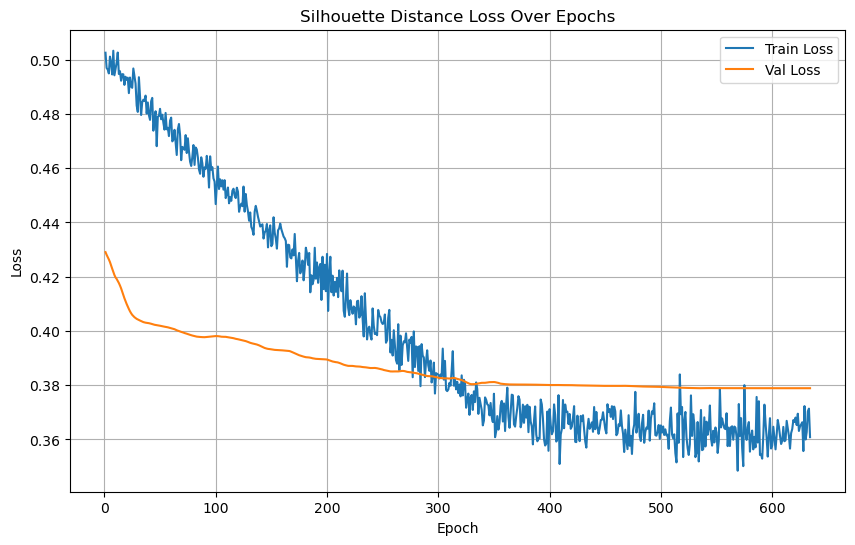

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/158], Loss: 0.4722


Test Batch [20/158], Loss: 0.3902
Test Batch [30/158], Loss: 0.4354
Test Batch [40/158], Loss: 0.2577


Test Batch [50/158], Loss: 0.4569
Test Batch [60/158], Loss: 0.3936
Test Batch [70/158], Loss: 0.2019


Test Batch [80/158], Loss: 0.2458
Test Batch [90/158], Loss: 0.2291
Test Batch [100/158], Loss: 0.2217
Test Batch [110/158], Loss: 0.2793
Test Batch [120/158], Loss: 0.2704


Test Batch [130/158], Loss: 0.5000
Test Batch [140/158], Loss: 0.3897
Test Batch [150/158], Loss: 0.3012

Test Loss: 0.3224


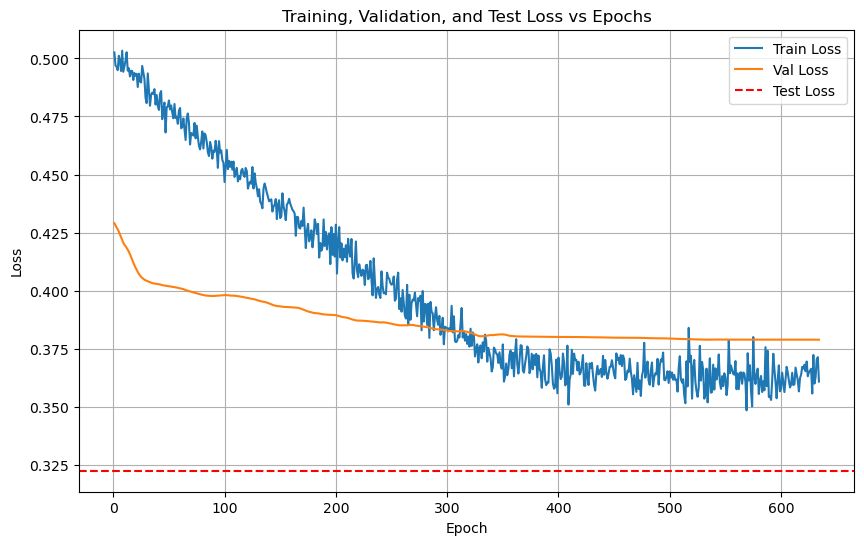

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/158 for test dataset.
  Processed batch 20/158 for test dataset.


  Processed batch 30/158 for test dataset.
  Processed batch 40/158 for test dataset.


  Processed batch 50/158 for test dataset.
  Processed batch 60/158 for test dataset.
  Processed batch 70/158 for test dataset.


  Processed batch 80/158 for test dataset.
  Processed batch 90/158 for test dataset.
  Processed batch 100/158 for test dataset.
  Processed batch 110/158 for test dataset.


  Processed batch 120/158 for test dataset.
  Processed batch 130/158 for test dataset.
  Processed batch 140/158 for test dataset.
  Processed batch 150/158 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 60.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.33      0.40      0.36         5
           2       0.00      0.00      0.00         5
           3       1.00      0.60      0.75         5
           4       0.75      0.60      0.67         5
           5       0.62      1.00      0.77         5
           6       0.71      1.00      0.83         5
           7       0.67      0.80      0.73         5
           8       0.83      1.00      0.91         5
           9       0.50      0.80      0.62         5
          10       0.00      0.00      0.00         5
          11       0.75      0.60      0.67         5
          12       0.67      0.80      0.73         5
          13       0.7

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7739  |  Val Loss: 2.7214
Validation loss improved from inf to 2.7214.
[Epoch 2/1000] Train Loss: 2.7610  |  Val Loss: 2.7141
Validation loss improved from 2.7214 to 2.7141.
[Epoch 3/1000] Train Loss: 2.7487  |  Val Loss: 2.7068
Validation loss improved from 2.7141 to 2.7068.
[Epoch 4/1000] Train Loss: 2.7377  |  Val Loss: 2.6993
Validation loss improved from 2.7068 to 2.6993.
[Epoch 5/1000] Train Loss: 2.7260  |  Val Loss: 2.6920
Validation loss improved from 2.6993 to 2.6920.
[Epoch 6/1000] Train Loss: 2.7151  |  Val Loss: 2.6849
Validation loss improved from 2.6920 to 2.6849.
[Epoch 7/1000] Train Loss: 2.7039  |  Val Loss: 2.6780
Validation loss improved from 2.6849 to 2.6780.
[Epoch 8/1000] Train Loss: 2.6933  |  Val Loss: 2.6713
Validation loss improved from 2.6780 to 2.6713.
[Epoch 9/1000] Train Loss: 2.6825  |  Val Loss: 2.6647
Validation loss improved from 2.6713 to 2.6647.
[Epoch 10/1000] Train Loss: 2.6727  |  Val Loss: 2.6585
Validation loss impr

[Epoch 20/1000] Train Loss: 2.5762  |  Val Loss: 2.6000
Validation loss improved from 2.6061 to 2.6000.
[Epoch 21/1000] Train Loss: 2.5671  |  Val Loss: 2.5939
Validation loss improved from 2.6000 to 2.5939.
[Epoch 22/1000] Train Loss: 2.5573  |  Val Loss: 2.5878
Validation loss improved from 2.5939 to 2.5878.
[Epoch 23/1000] Train Loss: 2.5479  |  Val Loss: 2.5816
Validation loss improved from 2.5878 to 2.5816.
[Epoch 24/1000] Train Loss: 2.5387  |  Val Loss: 2.5755
Validation loss improved from 2.5816 to 2.5755.
[Epoch 25/1000] Train Loss: 2.5292  |  Val Loss: 2.5694
Validation loss improved from 2.5755 to 2.5694.
[Epoch 26/1000] Train Loss: 2.5196  |  Val Loss: 2.5633
Validation loss improved from 2.5694 to 2.5633.
[Epoch 27/1000] Train Loss: 2.5101  |  Val Loss: 2.5572
Validation loss improved from 2.5633 to 2.5572.
[Epoch 28/1000] Train Loss: 2.5007  |  Val Loss: 2.5511
Validation loss improved from 2.5572 to 2.5511.
[Epoch 29/1000] Train Loss: 2.4909  |  Val Loss: 2.5452
Validati

[Epoch 34/1000] Train Loss: 2.4432  |  Val Loss: 2.5155
Validation loss improved from 2.5214 to 2.5155.


[Epoch 35/1000] Train Loss: 2.4338  |  Val Loss: 2.5096
Validation loss improved from 2.5155 to 2.5096.
[Epoch 36/1000] Train Loss: 2.4246  |  Val Loss: 2.5039
Validation loss improved from 2.5096 to 2.5039.
[Epoch 37/1000] Train Loss: 2.4154  |  Val Loss: 2.4982
Validation loss improved from 2.5039 to 2.4982.
[Epoch 38/1000] Train Loss: 2.4064  |  Val Loss: 2.4926
Validation loss improved from 2.4982 to 2.4926.
[Epoch 39/1000] Train Loss: 2.3971  |  Val Loss: 2.4870
Validation loss improved from 2.4926 to 2.4870.
[Epoch 40/1000] Train Loss: 2.3882  |  Val Loss: 2.4813
Validation loss improved from 2.4870 to 2.4813.
[Epoch 41/1000] Train Loss: 2.3791  |  Val Loss: 2.4756
Validation loss improved from 2.4813 to 2.4756.
[Epoch 42/1000] Train Loss: 2.3701  |  Val Loss: 2.4699
Validation loss improved from 2.4756 to 2.4699.
[Epoch 43/1000] Train Loss: 2.3611  |  Val Loss: 2.4643
Validation loss improved from 2.4699 to 2.4643.
[Epoch 44/1000] Train Loss: 2.3519  |  Val Loss: 2.4589
Validati

[Epoch 62/1000] Train Loss: 2.1861  |  Val Loss: 2.3605
Validation loss improved from 2.3660 to 2.3605.
[Epoch 63/1000] Train Loss: 2.1770  |  Val Loss: 2.3551
Validation loss improved from 2.3605 to 2.3551.
[Epoch 64/1000] Train Loss: 2.1674  |  Val Loss: 2.3497
Validation loss improved from 2.3551 to 2.3497.
[Epoch 65/1000] Train Loss: 2.1581  |  Val Loss: 2.3442
Validation loss improved from 2.3497 to 2.3442.
[Epoch 66/1000] Train Loss: 2.1487  |  Val Loss: 2.3388
Validation loss improved from 2.3442 to 2.3388.
[Epoch 67/1000] Train Loss: 2.1392  |  Val Loss: 2.3334
Validation loss improved from 2.3388 to 2.3334.
[Epoch 68/1000] Train Loss: 2.1297  |  Val Loss: 2.3278
Validation loss improved from 2.3334 to 2.3278.
[Epoch 69/1000] Train Loss: 2.1204  |  Val Loss: 2.3223
Validation loss improved from 2.3278 to 2.3223.
[Epoch 70/1000] Train Loss: 2.1109  |  Val Loss: 2.3168
Validation loss improved from 2.3223 to 2.3168.
[Epoch 71/1000] Train Loss: 2.1014  |  Val Loss: 2.3115
Validati

[Epoch 77/1000] Train Loss: 2.0442  |  Val Loss: 2.2794
Validation loss improved from 2.2847 to 2.2794.
[Epoch 78/1000] Train Loss: 2.0347  |  Val Loss: 2.2740
Validation loss improved from 2.2794 to 2.2740.
[Epoch 79/1000] Train Loss: 2.0249  |  Val Loss: 2.2685
Validation loss improved from 2.2740 to 2.2685.
[Epoch 80/1000] Train Loss: 2.0153  |  Val Loss: 2.2631
Validation loss improved from 2.2685 to 2.2631.
[Epoch 81/1000] Train Loss: 2.0054  |  Val Loss: 2.2577
Validation loss improved from 2.2631 to 2.2577.
[Epoch 82/1000] Train Loss: 1.9958  |  Val Loss: 2.2522
Validation loss improved from 2.2577 to 2.2522.
[Epoch 83/1000] Train Loss: 1.9858  |  Val Loss: 2.2469
Validation loss improved from 2.2522 to 2.2469.
[Epoch 84/1000] Train Loss: 1.9760  |  Val Loss: 2.2416
Validation loss improved from 2.2469 to 2.2416.
[Epoch 85/1000] Train Loss: 1.9659  |  Val Loss: 2.2363
Validation loss improved from 2.2416 to 2.2363.
[Epoch 86/1000] Train Loss: 1.9560  |  Val Loss: 2.2308
Validati

[Epoch 104/1000] Train Loss: 1.7745  |  Val Loss: 2.1326
Validation loss improved from 2.1381 to 2.1326.
[Epoch 105/1000] Train Loss: 1.7645  |  Val Loss: 2.1270
Validation loss improved from 2.1326 to 2.1270.
[Epoch 106/1000] Train Loss: 1.7547  |  Val Loss: 2.1215
Validation loss improved from 2.1270 to 2.1215.
[Epoch 107/1000] Train Loss: 1.7444  |  Val Loss: 2.1160
Validation loss improved from 2.1215 to 2.1160.
[Epoch 108/1000] Train Loss: 1.7345  |  Val Loss: 2.1104
Validation loss improved from 2.1160 to 2.1104.
[Epoch 109/1000] Train Loss: 1.7243  |  Val Loss: 2.1050
Validation loss improved from 2.1104 to 2.1050.
[Epoch 110/1000] Train Loss: 1.7142  |  Val Loss: 2.0994
Validation loss improved from 2.1050 to 2.0994.
[Epoch 111/1000] Train Loss: 1.7042  |  Val Loss: 2.0935
Validation loss improved from 2.0994 to 2.0935.
[Epoch 112/1000] Train Loss: 1.6942  |  Val Loss: 2.0873
Validation loss improved from 2.0935 to 2.0873.
[Epoch 113/1000] Train Loss: 1.6841  |  Val Loss: 2.080

[Epoch 122/1000] Train Loss: 1.5949  |  Val Loss: 2.0303
Validation loss improved from 2.0351 to 2.0303.
[Epoch 123/1000] Train Loss: 1.5848  |  Val Loss: 2.0254
Validation loss improved from 2.0303 to 2.0254.
[Epoch 124/1000] Train Loss: 1.5749  |  Val Loss: 2.0207
Validation loss improved from 2.0254 to 2.0207.
[Epoch 125/1000] Train Loss: 1.5651  |  Val Loss: 2.0158
Validation loss improved from 2.0207 to 2.0158.
[Epoch 126/1000] Train Loss: 1.5551  |  Val Loss: 2.0108
Validation loss improved from 2.0158 to 2.0108.
[Epoch 127/1000] Train Loss: 1.5451  |  Val Loss: 2.0060
Validation loss improved from 2.0108 to 2.0060.
[Epoch 128/1000] Train Loss: 1.5352  |  Val Loss: 2.0015
Validation loss improved from 2.0060 to 2.0015.
[Epoch 129/1000] Train Loss: 1.5252  |  Val Loss: 1.9968
Validation loss improved from 2.0015 to 1.9968.
[Epoch 130/1000] Train Loss: 1.5154  |  Val Loss: 1.9921
Validation loss improved from 1.9968 to 1.9921.
[Epoch 131/1000] Train Loss: 1.5053  |  Val Loss: 1.987

[Epoch 146/1000] Train Loss: 1.3600  |  Val Loss: 1.9085
Validation loss improved from 1.9134 to 1.9085.
[Epoch 147/1000] Train Loss: 1.3503  |  Val Loss: 1.9036
Validation loss improved from 1.9085 to 1.9036.
[Epoch 148/1000] Train Loss: 1.3409  |  Val Loss: 1.8990
Validation loss improved from 1.9036 to 1.8990.
[Epoch 149/1000] Train Loss: 1.3311  |  Val Loss: 1.8942
Validation loss improved from 1.8990 to 1.8942.
[Epoch 150/1000] Train Loss: 1.3217  |  Val Loss: 1.8889
Validation loss improved from 1.8942 to 1.8889.
[Epoch 151/1000] Train Loss: 1.3123  |  Val Loss: 1.8833
Validation loss improved from 1.8889 to 1.8833.
[Epoch 152/1000] Train Loss: 1.3030  |  Val Loss: 1.8783
Validation loss improved from 1.8833 to 1.8783.
[Epoch 153/1000] Train Loss: 1.2935  |  Val Loss: 1.8738
Validation loss improved from 1.8783 to 1.8738.
[Epoch 154/1000] Train Loss: 1.2843  |  Val Loss: 1.8689
Validation loss improved from 1.8738 to 1.8689.
[Epoch 155/1000] Train Loss: 1.2753  |  Val Loss: 1.863

[Epoch 165/1000] Train Loss: 1.1845  |  Val Loss: 1.8132
Validation loss improved from 1.8173 to 1.8132.
[Epoch 166/1000] Train Loss: 1.1754  |  Val Loss: 1.8090
Validation loss improved from 1.8132 to 1.8090.
[Epoch 167/1000] Train Loss: 1.1667  |  Val Loss: 1.8051
Validation loss improved from 1.8090 to 1.8051.
[Epoch 168/1000] Train Loss: 1.1577  |  Val Loss: 1.8016
Validation loss improved from 1.8051 to 1.8016.
[Epoch 169/1000] Train Loss: 1.1490  |  Val Loss: 1.7979
Validation loss improved from 1.8016 to 1.7979.
[Epoch 170/1000] Train Loss: 1.1402  |  Val Loss: 1.7937
Validation loss improved from 1.7979 to 1.7937.
[Epoch 171/1000] Train Loss: 1.1318  |  Val Loss: 1.7894
Validation loss improved from 1.7937 to 1.7894.
[Epoch 172/1000] Train Loss: 1.1231  |  Val Loss: 1.7854
Validation loss improved from 1.7894 to 1.7854.
[Epoch 173/1000] Train Loss: 1.1144  |  Val Loss: 1.7818
Validation loss improved from 1.7854 to 1.7818.
[Epoch 174/1000] Train Loss: 1.1062  |  Val Loss: 1.778

[Epoch 186/1000] Train Loss: 1.0091  |  Val Loss: 1.7313
Validation loss improved from 1.7354 to 1.7313.
[Epoch 187/1000] Train Loss: 1.0012  |  Val Loss: 1.7273
Validation loss improved from 1.7313 to 1.7273.
[Epoch 188/1000] Train Loss: 0.9935  |  Val Loss: 1.7233
Validation loss improved from 1.7273 to 1.7233.
[Epoch 189/1000] Train Loss: 0.9857  |  Val Loss: 1.7195
Validation loss improved from 1.7233 to 1.7195.
[Epoch 190/1000] Train Loss: 0.9781  |  Val Loss: 1.7157
Validation loss improved from 1.7195 to 1.7157.
[Epoch 191/1000] Train Loss: 0.9707  |  Val Loss: 1.7118
Validation loss improved from 1.7157 to 1.7118.
[Epoch 192/1000] Train Loss: 0.9631  |  Val Loss: 1.7080
Validation loss improved from 1.7118 to 1.7080.
[Epoch 193/1000] Train Loss: 0.9560  |  Val Loss: 1.7045
Validation loss improved from 1.7080 to 1.7045.
[Epoch 194/1000] Train Loss: 0.9485  |  Val Loss: 1.7011
Validation loss improved from 1.7045 to 1.7011.
[Epoch 195/1000] Train Loss: 0.9412  |  Val Loss: 1.697

[Epoch 205/1000] Train Loss: 0.8722  |  Val Loss: 1.6723
Validation loss improved from 1.6748 to 1.6723.
[Epoch 206/1000] Train Loss: 0.8654  |  Val Loss: 1.6702
Validation loss improved from 1.6723 to 1.6702.
[Epoch 207/1000] Train Loss: 0.8588  |  Val Loss: 1.6680
Validation loss improved from 1.6702 to 1.6680.
[Epoch 208/1000] Train Loss: 0.8524  |  Val Loss: 1.6659
Validation loss improved from 1.6680 to 1.6659.
[Epoch 209/1000] Train Loss: 0.8458  |  Val Loss: 1.6642
Validation loss improved from 1.6659 to 1.6642.
[Epoch 210/1000] Train Loss: 0.8395  |  Val Loss: 1.6622
Validation loss improved from 1.6642 to 1.6622.
[Epoch 211/1000] Train Loss: 0.8327  |  Val Loss: 1.6604
Validation loss improved from 1.6622 to 1.6604.
[Epoch 212/1000] Train Loss: 0.8266  |  Val Loss: 1.6591
Validation loss improved from 1.6604 to 1.6591.
[Epoch 213/1000] Train Loss: 0.8203  |  Val Loss: 1.6579
Validation loss improved from 1.6591 to 1.6579.
[Epoch 214/1000] Train Loss: 0.8140  |  Val Loss: 1.656

[Epoch 226/1000] Train Loss: 0.7435  |  Val Loss: 1.6302
Validation loss improved from 1.6331 to 1.6302.
[Epoch 227/1000] Train Loss: 0.7379  |  Val Loss: 1.6275
Validation loss improved from 1.6302 to 1.6275.
[Epoch 228/1000] Train Loss: 0.7324  |  Val Loss: 1.6249
Validation loss improved from 1.6275 to 1.6249.
[Epoch 229/1000] Train Loss: 0.7271  |  Val Loss: 1.6221
Validation loss improved from 1.6249 to 1.6221.
[Epoch 230/1000] Train Loss: 0.7218  |  Val Loss: 1.6198
Validation loss improved from 1.6221 to 1.6198.
[Epoch 231/1000] Train Loss: 0.7164  |  Val Loss: 1.6176
Validation loss improved from 1.6198 to 1.6176.
[Epoch 232/1000] Train Loss: 0.7112  |  Val Loss: 1.6150
Validation loss improved from 1.6176 to 1.6150.
[Epoch 233/1000] Train Loss: 0.7063  |  Val Loss: 1.6121
Validation loss improved from 1.6150 to 1.6121.
[Epoch 234/1000] Train Loss: 0.7014  |  Val Loss: 1.6093
Validation loss improved from 1.6121 to 1.6093.
[Epoch 235/1000] Train Loss: 0.6962  |  Val Loss: 1.607

[Epoch 244/1000] Train Loss: 0.6529  |  Val Loss: 1.6013
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 245/1000] Train Loss: 0.6484  |  Val Loss: 1.6023
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 246/1000] Train Loss: 0.6440  |  Val Loss: 1.6032
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 247/1000] Train Loss: 0.6396  |  Val Loss: 1.6038
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 248/1000] Train Loss: 0.6353  |  Val Loss: 1.6039
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 249/1000] Train Loss: 0.6309  |  Val Loss: 1.6039
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 250/1000] Train Loss: 0.6265  |  Val Loss: 1.6032
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 251/1000] Train Loss: 0.6221  |  Val Loss: 1.6016
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 252/1000] Train Loss: 0.6177  |  Val Loss: 1.6001
Validation loss improved from 1.6002 to 1.6001.
[Epoch 

[Epoch 263/1000] Train Loss: 0.5723  |  Val Loss: 1.5871
Validation loss improved from 1.5897 to 1.5871.
[Epoch 264/1000] Train Loss: 0.5682  |  Val Loss: 1.5844
Validation loss improved from 1.5871 to 1.5844.
[Epoch 265/1000] Train Loss: 0.5643  |  Val Loss: 1.5813
Validation loss improved from 1.5844 to 1.5813.
[Epoch 266/1000] Train Loss: 0.5604  |  Val Loss: 1.5784
Validation loss improved from 1.5813 to 1.5784.
[Epoch 267/1000] Train Loss: 0.5565  |  Val Loss: 1.5759
Validation loss improved from 1.5784 to 1.5759.
[Epoch 268/1000] Train Loss: 0.5528  |  Val Loss: 1.5743
Validation loss improved from 1.5759 to 1.5743.
[Epoch 269/1000] Train Loss: 0.5490  |  Val Loss: 1.5733
Validation loss improved from 1.5743 to 1.5733.
[Epoch 270/1000] Train Loss: 0.5454  |  Val Loss: 1.5725
Validation loss improved from 1.5733 to 1.5725.
[Epoch 271/1000] Train Loss: 0.5418  |  Val Loss: 1.5714
Validation loss improved from 1.5725 to 1.5714.
[Epoch 272/1000] Train Loss: 0.5381  |  Val Loss: 1.570

[Epoch 282/1000] Train Loss: 0.5046  |  Val Loss: 1.5579
Validation loss improved from 1.5587 to 1.5579.
[Epoch 283/1000] Train Loss: 0.5013  |  Val Loss: 1.5573
Validation loss improved from 1.5579 to 1.5573.
[Epoch 284/1000] Train Loss: 0.4982  |  Val Loss: 1.5573
Validation loss improved from 1.5573 to 1.5573.
[Epoch 285/1000] Train Loss: 0.4949  |  Val Loss: 1.5580
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 286/1000] Train Loss: 0.4918  |  Val Loss: 1.5591
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 287/1000] Train Loss: 0.4887  |  Val Loss: 1.5599
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 288/1000] Train Loss: 0.4858  |  Val Loss: 1.5608
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 289/1000] Train Loss: 0.4826  |  Val Loss: 1.5613
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 290/1000] Train Loss: 0.4794  |  Val Loss: 1.5618
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 291/1000] Tr

[Epoch 302/1000] Train Loss: 0.4444  |  Val Loss: 1.5703
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 303/1000] Train Loss: 0.4419  |  Val Loss: 1.5702
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 304/1000] Train Loss: 0.4391  |  Val Loss: 1.5697
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 305/1000] Train Loss: 0.4363  |  Val Loss: 1.5689
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 306/1000] Train Loss: 0.4336  |  Val Loss: 1.5682
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 307/1000] Train Loss: 0.4309  |  Val Loss: 1.5680
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 308/1000] Train Loss: 0.4282  |  Val Loss: 1.5686
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 309/1000] Train Loss: 0.4257  |  Val Loss: 1.5694
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 310/1000] Train Loss: 0.4230  |  Val Loss: 1.5705
!! Validation loss did NOT improve !! Patience:

[Epoch 327/1000] Train Loss: 0.3817  |  Val Loss: 1.5864
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 328/1000] Train Loss: 0.3794  |  Val Loss: 1.5862
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 329/1000] Train Loss: 0.3771  |  Val Loss: 1.5865
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 330/1000] Train Loss: 0.3750  |  Val Loss: 1.5874
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 331/1000] Train Loss: 0.3727  |  Val Loss: 1.5886
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 332/1000] Train Loss: 0.3703  |  Val Loss: 1.5904
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 333/1000] Train Loss: 0.3684  |  Val Loss: 1.5926
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 334/1000] Train Loss: 0.3660  |  Val Loss: 1.5953
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 335/1000] Train Loss: 0.3639  |  Val Loss: 1.5982
!! Validation loss did NOT improve !! Patience:

[Epoch 346/1000] Train Loss: 0.3419  |  Val Loss: 1.6166
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 347/1000] Train Loss: 0.3399  |  Val Loss: 1.6173
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 348/1000] Train Loss: 0.3381  |  Val Loss: 1.6182
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 349/1000] Train Loss: 0.3361  |  Val Loss: 1.6189
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 350/1000] Train Loss: 0.3342  |  Val Loss: 1.6196
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 351/1000] Train Loss: 0.3322  |  Val Loss: 1.6205
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 352/1000] Train Loss: 0.3304  |  Val Loss: 1.6216
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 353/1000] Train Loss: 0.3286  |  Val Loss: 1.6225
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 354/1000] Train Loss: 0.3268  |  Val Loss: 1.6229
!! Validation loss did NOT improve !! Patience:

[Epoch 366/1000] Train Loss: 0.3065  |  Val Loss: 1.6388
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 367/1000] Train Loss: 0.3051  |  Val Loss: 1.6409
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 368/1000] Train Loss: 0.3035  |  Val Loss: 1.6424
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 369/1000] Train Loss: 0.3018  |  Val Loss: 1.6434
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 370/1000] Train Loss: 0.3002  |  Val Loss: 1.6444
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 371/1000] Train Loss: 0.2986  |  Val Loss: 1.6458
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 372/1000] Train Loss: 0.2973  |  Val Loss: 1.6479
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 373/1000] Train Loss: 0.2958  |  Val Loss: 1.6499
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 374/1000] Train Loss: 0.2943  |  Val Loss: 1.6518
!! Validation loss did NOT improve !! Patience:

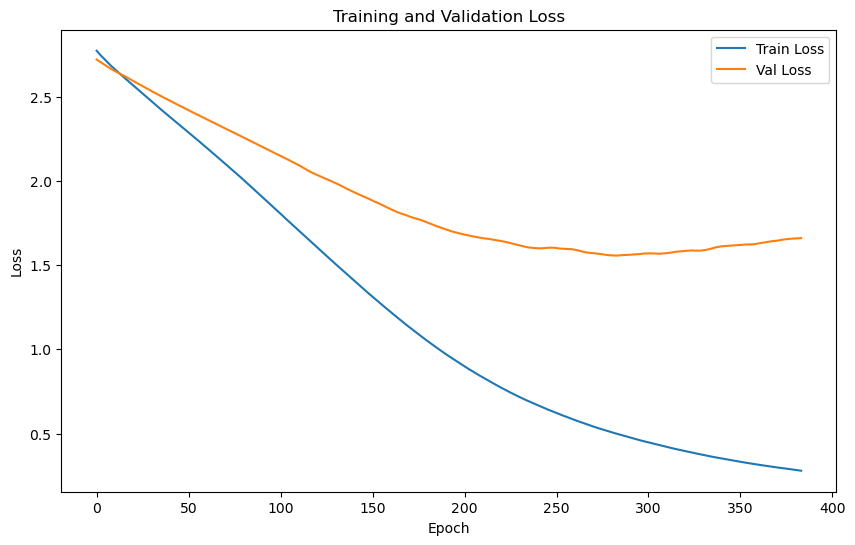

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.0115 | Test Accuracy: 45.88%


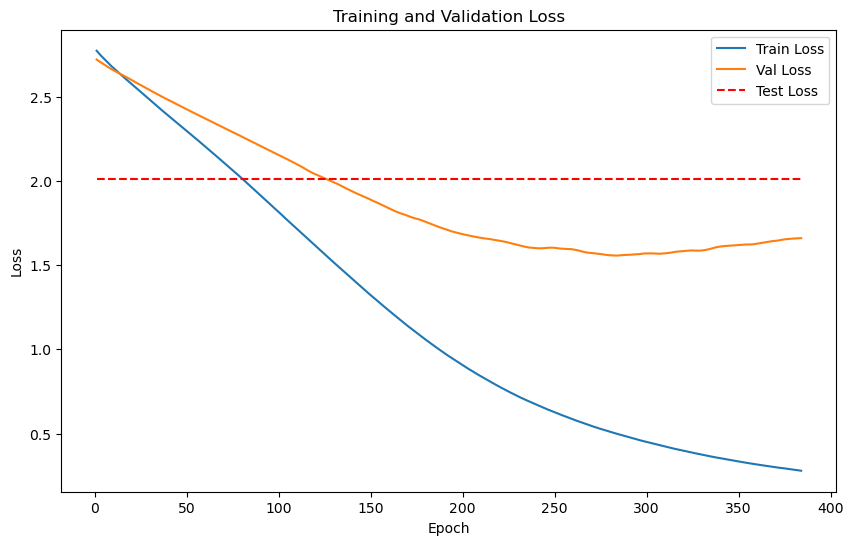

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


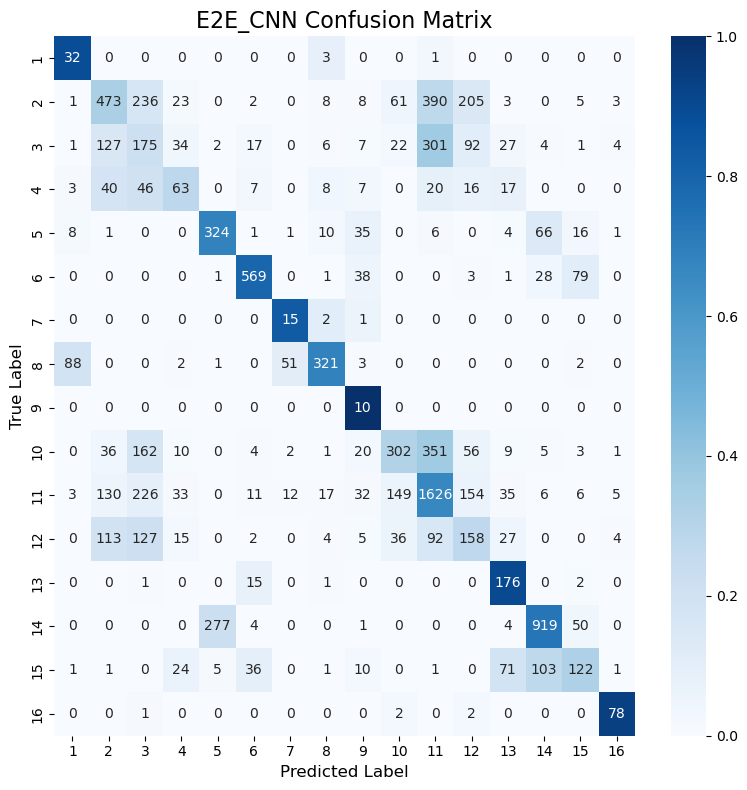

Classification Accuracy: 53.16%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


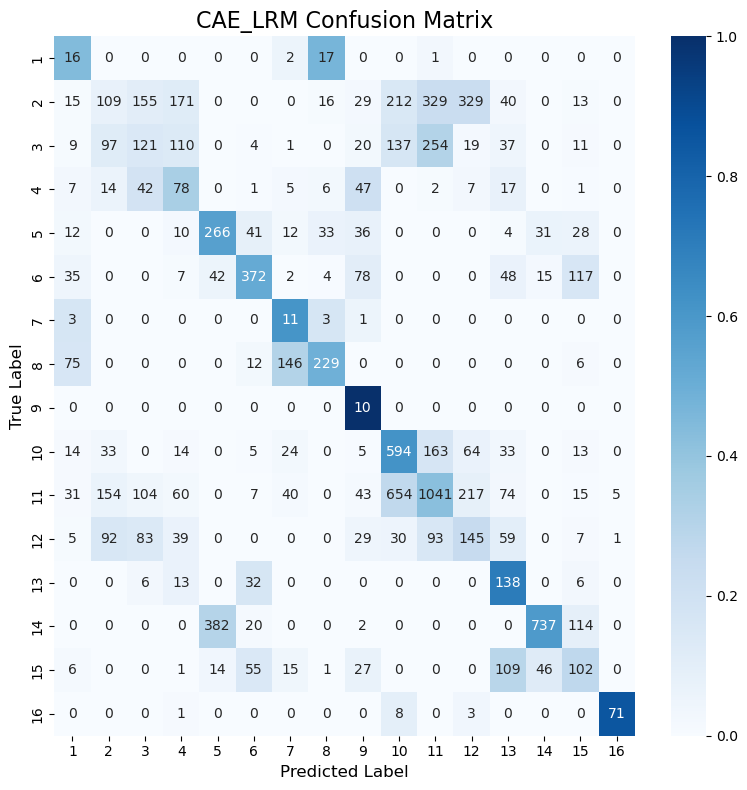

Classification Accuracy: 40.04%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


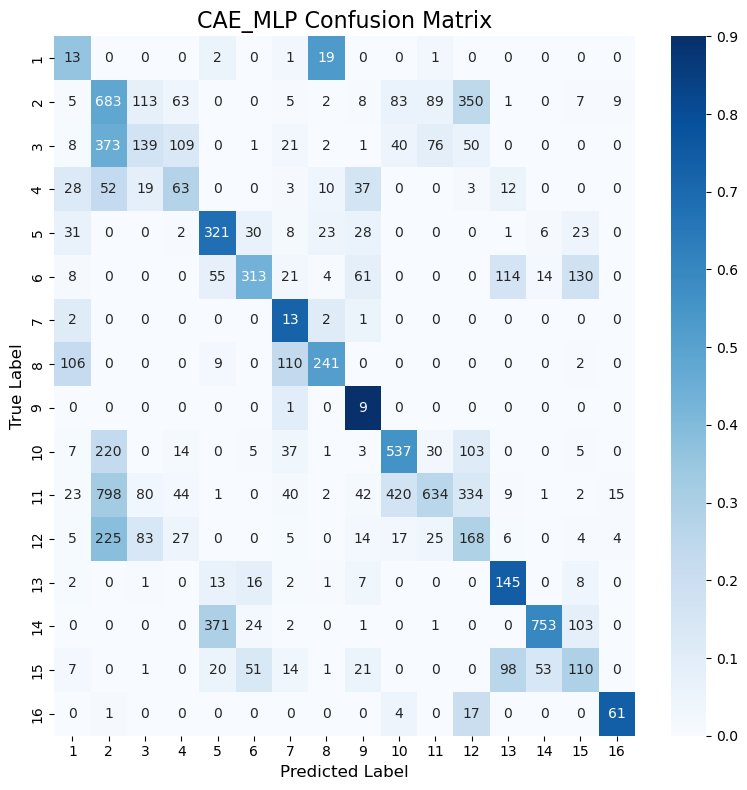

Classification Accuracy: 41.66%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


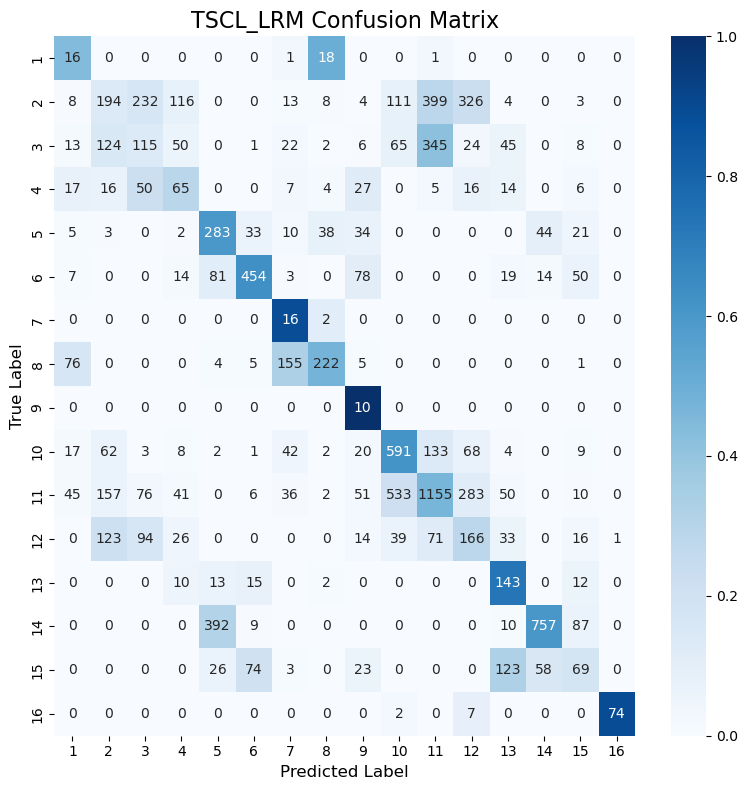

Classification Accuracy: 42.92%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


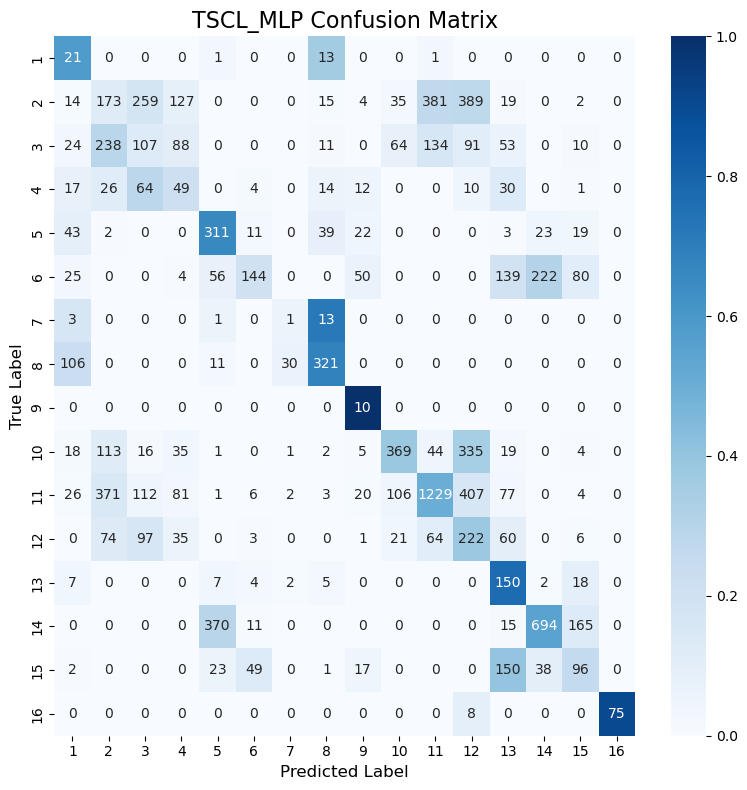

Classification Accuracy: 39.37%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


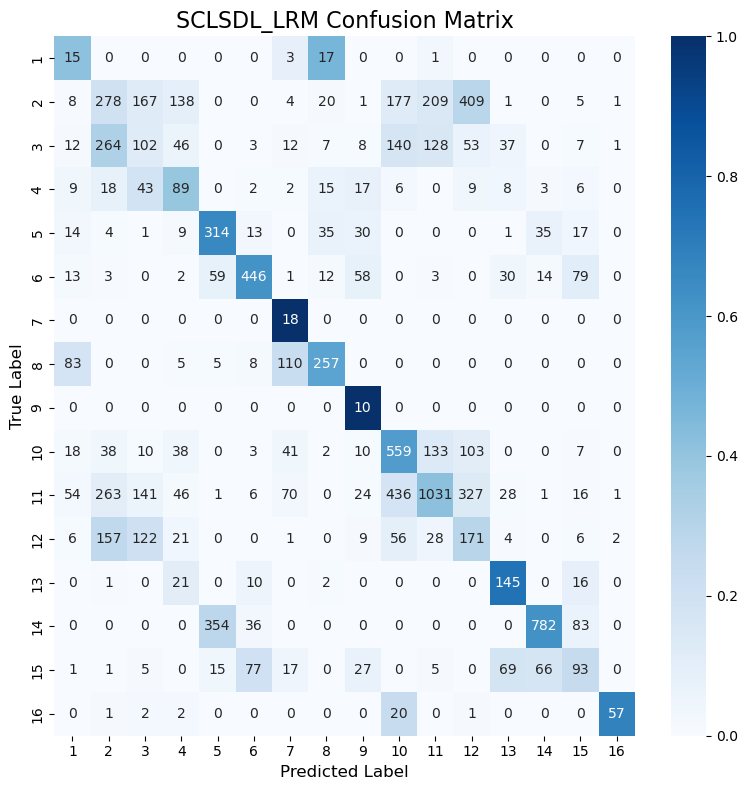

Classification Accuracy: 43.28%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


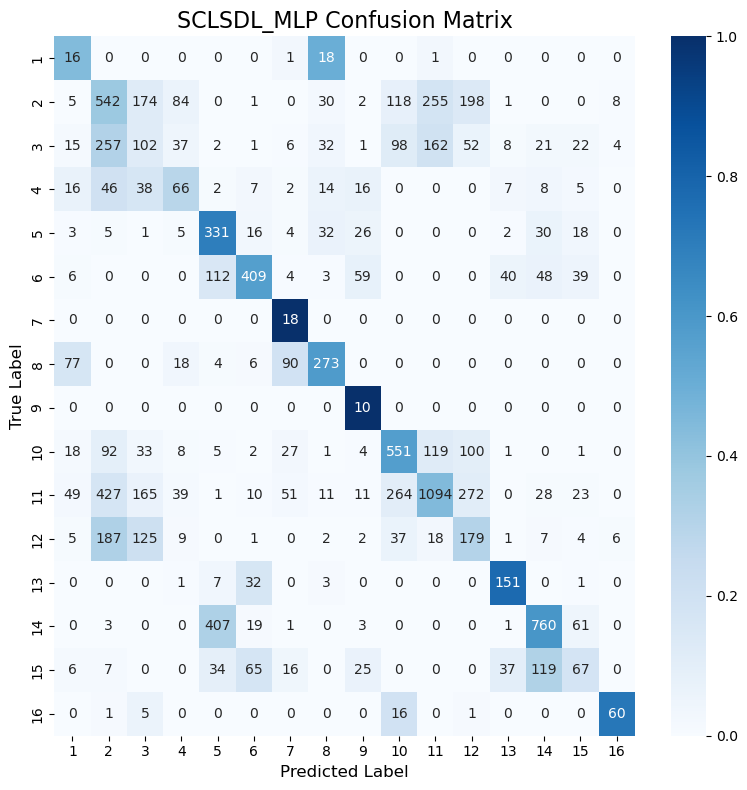

Classification Accuracy: 45.88%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          53.16
1    LRM (CAE)          40.04
2    MLP (CAE)          41.66
3     TSCL LRM          42.92
4     TSCL MLP          39.37
5  SCL_SDL LRM          43.28
6  SCL_SDL MLP          45.88

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          53.16
6  SCL_SDL MLP          45.88
5  SCL_SDL LRM          43.28
3     TSCL LRM          42.92
2    MLP (CAE)          41.66
1    LRM (CAE)          40.04
4     TSCL MLP          39.37
